# Modules

In [141]:
# Importing all necessary modules and functions

%run src/utils/modules_utils.py

In [2]:
# Suppress certain warnings
warnings.filterwarnings("ignore")

# Dataset

The dataset used in this analysis consists of beer reviews from two beer rating websites,**BeerAdvocate** and **RateBeer**, for a period ranging from 2001 to 2017. For each website, we have 5 files:
- users.csv: metadata about reviewers
- beers.csv : metadata about reviewed beers
- breweries.csv : metadata about breweries
- ratings.txt : all reviews given by users, including numerical ratings and sometimes textual reviews
- reviews.txt : only reviews given by users that include both numerical ratings and textual reviews

In our analysis, we will not use textual reviews. Thus, we will only use ratings.txt files and not reviews.txt files, as we will use all reviews, whether or not they include textual reviews.

### Load data into Dataframes

The .csv files are not too large and can efficiently be loaded into DataFrames.

In [3]:
BA_DATA_FOLDER = 'data/BeerAdvocate/'
RB_DATA_FOLDER = 'data/RateBeer/'

BA_USERS = BA_DATA_FOLDER+"users.csv"
BA_BEERS = BA_DATA_FOLDER+"beers.csv"
BA_BREWERIES = BA_DATA_FOLDER+"breweries.csv"

RB_USERS = RB_DATA_FOLDER+"users.csv"
RB_BEERS = RB_DATA_FOLDER+"beers.csv"
RB_BREWERIES = RB_DATA_FOLDER+"breweries.csv"

In [4]:
ba_users = pd.read_csv(BA_USERS)
ba_beers = pd.read_csv(BA_BEERS)
ba_breweries = pd.read_csv(BA_BREWERIES)

rb_users = pd.read_csv(RB_USERS)
rb_beers = pd.read_csv(RB_BEERS)
rb_breweries = pd.read_csv(RB_BREWERIES)

On the other hand, the ratings.txt files are extremely large, and trying to load them directly into DataFrames leads to kernel freezes. In order to circumvent this problem, we wrote a script (review_parser.py, located in src/scripts), which processes each rating file by dividing it into parts, parsing each part, and saving as JSON. In the notebook, we then load the different JSON files into DataFrames, that we concatenate. Dividing the large .txt files into smaller JSON chunks and then loading each chunk separately, avoids trying to load the entire file into memory at once, which can cause kernel freezes due to memory overload. In addition, JSON is a format that pandas can read efficiently.

In [5]:
# Load BeerAdvocate ratings stored in json files into a single DataFrame
ba_json_files = glob.glob(BA_DATA_FOLDER+'*.json')
ba_df_list = [pd.read_json(file) for file in ba_json_files]
ba_ratings = pd.concat(ba_df_list, ignore_index=True)

In [6]:
# Load RateBeer ratings stored in json files into a single DataFrame
rb_json_files = glob.glob(RB_DATA_FOLDER+'*.json')
rb_df_list = [pd.read_json(file) for file in rb_json_files]
rb_ratings = pd.concat(rb_df_list, ignore_index=True)

### First look at the data

We will now examine the different DataFrames in more detail.

**BeerAdvocate beer Dataframe**

In [7]:
ba_beers.sample(4)

beer_id            beer_name  brewery_id                 brewery_name  \
80695    224102         Morado Punch       38745        Fieldwork Brewing Co.   
186638   212431  Xtra-Citra Pale Ale       13014  Surly Brewing Co. Beer Hall   
42323     25813  Leikeim Premium-Dry         472             Brauerei Leikeim   
73590    246082        Cukes N Cream       44285  Torched Hop Brewing Company   

                          style  nbr_ratings  nbr_reviews   avg  ba_score  \
80695              American IPA           14            2  4.30      87.0   
186638  American Pale Ale (APA)          480          111  3.94      88.0   
42323           German Pilsener            0            0   NaN       NaN   
73590                 Cream Ale            1            0  3.84       NaN   

        bros_score  abv  avg_computed    zscore  nbr_matched_valid_ratings  \
80695          NaN  6.8      4.258571  0.588824                          3   
186638        90.0  4.5      3.951792 -0.069058                        120   
42323          NaN  NaN           NaN       NaN                          0   
73590          NaN  5.1      3.840000       NaN                          0   

        avg_matched_valid_ratings  
80695                    4.420000  
186638                   3.938667  
42323                         NaN  
73590                         NaN

Let us explain the different columns of the BeerAdvocate beer Dataframe, in which each row is a beer:
- beer_id, beer_name, brewery_id, brewery_name, style are explicit
- nbr_ratings: total number of reviews for that beer, whether or not they include textual reviews
- nbr_reviews: number of reviews for that beer that include textual reviews
- avg: average rating (out of 5) given to the beer based on user ratings
- ba_score: the BeerAdvocate score assigned to the beer, which corresponds to the beer's overall rating within its style category, calculated using a trimmed mean and a custom Bayesian formula that adjusts for the beer's style, balancing the score based on the number of ratings and the style's average
- bros_score: beer rating given by the site’s founders
- abv: 'Alcohol by volume', which indicates the percentage of alcohol content in the beer
- avg_computed: average rating (out of 5) recalculated using a weighted sum of the different aspect ratings
- zscore: z-score of the beer's average rating, which is a statistical measure that indicates how many standard deviations the average rating is from the mean of all ratings from the BeerAdvocate dataset
- nbr_matched_valid_ratings: number of valid ratings for beers that were successfully matched between two BeerAdvocate and RateBeer
- avg_matched_valid_ratings: average rating of those matched and valid ratings across the sites

The last two columns are related to the analysis performed by Robert West and Gael Lederrey in the following paper: https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf.

**RateBeer beer Dataframe**

In [8]:
rb_beers.sample(4)

beer_id                                     beer_name  brewery_id  \
365340   362266  Off Color Dinosmores - Buffalo Trace Barrel       16683   
47824    100457                        Brewpub København Kant        5734   
417419   107935                               Exeter Darkness        4958   
39606    226792       Az. Agr. Cameli Di Cameli Cheti Giulia        16911   

                           brewery_name                 style  nbr_ratings  \
365340                Off Color Brewing        Imperial Stout            1   
47824                 Brewpub København           Schwarzbier           21   
417419                           Exeter                 Stout           24   
39606   Az. Agr. Cameli Di Cameli Cheti  Golden Ale/Blond Ale            5   

        overall_score  style_score   avg  abv  avg_computed    zscore  \
365340            NaN          NaN  3.11  NaN      3.800000       NaN   
47824            81.0         92.0  3.37  5.5      3.452381       NaN   
417419           75.0         64.0  3.38  5.1      3.445833       NaN   
39606             NaN          NaN  2.83  4.2      2.920000 -0.853556   

        nbr_matched_valid_ratings  avg_matched_valid_ratings  
365340                          0                        NaN  
47824                           0                        NaN  
417419                          0                        NaN  
39606                           5                       2.92

Let us explain the different columns of the RateBeer beer Dataframe, in which each row is a beer:

The beer_id, beer_name, brewery_id, brewery_name, style, nbr_ratings, avg, abv, avg_computed, z-score, nbr_matched_valid_ratings and avg_matched_valid_ratings are the same as for the BeerAdvocate beer Dataframe.

Some columns are missing compared to the BeerAdvocate beer Dataframe: ba_score and bros_score (which makes sense as these are BeerAdvocate-specific scores), and nbr_reviews.

New columns are present compared to the BeerAdvocate beer Dataframe:
- overall_score: score (out of 100) which "reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer", calculated by considering the ratings given by each user and the total number of ratings for the beer
- style_score: score given to the beer (out of 100) specifically within its style category

**Characteristics of the beer data**

Let us determine how many different beers are present in the dataset.

In [9]:
print('Number of different beers reviewed in Beer Advocate:', ba_beers.shape[0])
print('Number of different beers reviewed in Rate Beer:', rb_beers.shape[0])
print('Number of different beers reviewed in the combined datasets:', pd.concat([ba_beers['beer_id'], rb_beers['beer_id']]).nunique())

Number of different beers reviewed in Beer Advocate: 280823
Number of different beers reviewed in Rate Beer: 442081
Number of different beers reviewed in the combined datasets: 502784


Let us determine how many different beer styles are present in the dataset.

In [10]:
print('Number of different beer styles reviewed in Beer Advocate:', ba_beers['style'].nunique())
print('Number of different beer styles reviewed in Rate Beer:', rb_beers['style'].nunique())
print('Number of different beer styles reviewed in the combined datasets:', pd.concat([ba_beers['style'], rb_beers['style']]).nunique())

Number of different beer styles reviewed in Beer Advocate: 104
Number of different beer styles reviewed in Rate Beer: 94
Number of different beer styles reviewed in the combined datasets: 184


**BeerAdvocate user Dataframe**

In [11]:
ba_users.sample(4)

nbr_ratings  nbr_reviews            user_id   user_name        joined  \
74313            5            0   o-dog1998.718366   O-Dog1998  1.360840e+09   
81581            1            0     grem182.784553     grem182  1.393240e+09   
41444            3            0   tmacloco1.825611   TMACLOCO1  1.405332e+09   
39029            3            0  usbbeerguy.885360  USBBeerGuy  1.414667e+09   

                        location  
74313                        NaN  
81581                        NaN  
41444                        NaN  
39029  United States, New Jersey

Let us explain the different columns of the BeerAdvocate user Dataframe, in which each row is a reviewer:
- nbr_ratings, nbr_reviews, user_id, user_name, and location are explicit
- joined: timestamp indicating when the user joined BeerAdvocate in Unix timestamp format (the number of seconds since January 1, 1970, 00:00:00 UTC)

**RateBeer user Dataframe**

In [12]:
rb_users.sample(4)

nbr_ratings  user_id      user_name        joined             location
26176           88   352678  Jared_Clifton  1.421060e+09  United States, Ohio
9760            25   292894    Smallweener  1.387105e+09               Canada
32213            4   154426        plunkie  1.327835e+09                  NaN
59366            1   288508   Norenallaves  1.384427e+09          Puerto Rico

Let us explain the different columns of the RateBeer user Dataframe, in which each row is a reviewer:

The columns are the same as in the BeerAdvocate user Dataframe (joined is obviously the timestamp indicating when the user joined RateBeer and not BeerAdvocate), except that nbr_reviews is missing.

**Number of users in the dataset**

In [13]:
print('Number of users from Beer Advocate:', ba_users.shape[0])
print('Number of users from Rate Beer:', rb_users.shape[0])
print('Total number of users:', (ba_users.shape[0] + rb_users.shape[0]))

Number of users from Beer Advocate: 153704
Number of users from Rate Beer: 70174
Total number of users: 223878


**Brewery Dataframes**

In [14]:
ba_breweries.sample(4)

id                   location                       name  nbr_beers
367     7035                    England           Big Lamp Brewers          5
9311   42209  United States, Washington      Ghost Runners Brewery         10
305    41523                    England                      Crane          4
16253    131       United States, Maine  Rocky Bay Brewing Company         10

In [15]:
rb_breweries.sample(4)

id   location                 name  nbr_beers
23393  31225     France                Diwaz          1
7735   11289  Australia  Lucky Drink Company          1
3667    7946      Italy             La Serra          7
253    14523    Romania          Albrau S.A.         16

The columns are explicit and are the same for the 2 websites. Each row is a brewery.

**Rating Dataframes**

In [16]:
ba_ratings.sample(4)

beer_name   beer_id  \
3872687                Modus Mandarina  128837.0   
6822368  Kuhnhenn Fourth Dementia (4D)   18850.0   
7905370        Trappistes Rochefort 10     645.0   
240663                        Mexicali    9546.0   

                             brewery_name  brewery_id                   style  \
3872687                   Ska Brewing Co.       923.0            American IPA   
6822368          Kuhnhenn Brewing Company      2097.0                 Old Ale   
7905370            Brasserie de Rochefort       207.0        Quadrupel (Quad)   
240663   Cerveceria Mexicana S.A. De C.V.     11174.0  American Adjunct Lager   

          abv                date            user_name  \
3872687   6.8 2016-11-15 11:00:00              GilGarp   
6822368  13.5 2013-01-17 11:00:00               ScottO   
7905370  11.3 2013-07-18 10:00:00         ridiculotron   
240663    4.4 2014-04-10 10:00:00  ChristopherWIU-UTPA   

                            user_id  appearance  aroma  palate  taste  \
3872687              gilgarp.126987        4.25   4.25    4.25   4.25   
6822368               scotto.662885         NaN    NaN     NaN    NaN   
7905370         ridiculotron.740781         NaN    NaN     NaN    NaN   
240663   christopherwiu-utpa.793614        1.00   1.00    1.00   1.00   

         overall  rating  
3872687     4.25    4.25  
6822368      NaN    4.50  
7905370      NaN    4.75  
240663      1.00    1.00

In [17]:
rb_ratings.sample(4)

beer_name   beer_id  \
1973437                                   Mommeriete Blond   41808.0   
5424575  Destihl Saint Dekkera Barrel Reserve Sour: Fla...  120627.0   
2574507                          Schouskjelleren Mega-Hege  401719.0   
6592446                        Boon Oude Geuze Black Label  367485.0   

                          brewery_name  brewery_id                  style  \
1973437           Mommeriete Brouwerij      5464.0            Belgian Ale   
5424575                Destihl Brewery      9189.0         Sour Red/Brown   
2574507  Schouskjelleren Mikrobryggeri     12143.0                 Kölsch   
6592446              Brouwerij F. Boon       748.0  Lambic Style - Gueuze   

         abv                date user_name  user_id  appearance  aroma  \
1973437  5.5 2008-05-25 10:00:00    yngwie  24724.0         4.0    3.0   
5424575  7.2 2015-11-04 11:00:00   hayduke  11952.0         3.0    8.0   
2574507  5.5 2016-03-12 11:00:00      Finn  20300.0         2.0    5.0   
6592446  6.4 2015-11-26 11:00:00  madsberg   5011.0         4.0    8.0   

         palate  taste  overall  rating  
1973437     3.0    2.0      6.0     1.8  
5424575     4.0    8.0     17.0     4.0  
2574507     3.0    5.0     11.0     2.6  
6592446     5.0    9.0     16.0     4.2

The columns are the same for the 2 Dataframes. Each row corresponds to an individual review. Most column names are explicit. 
- 'appearance','aroma', 'palate','taste' correspond to aspect ratings (out of 5)
- 'overall' is the mean of the 4 aspect ratings
- 'rating' is the final rating given by the user to the beer

**Number of reviews in the dataset**

In [18]:
print('Number of reviews from Beer Advocate:', ba_ratings.shape[0])
print('Number of reviews from Rate Beer:', rb_ratings.shape[0])
print('Total number of reviews:', (ba_ratings.shape[0] + rb_ratings.shape[0]))

Number of reviews from Beer Advocate: 8393034
Number of reviews from Rate Beer: 7122076
Total number of reviews: 15515110


# 0) Data cleaning

### **BASIC CLEANING**

## Filtering Dataframes

Let us start by removing columns in the different Dataframes that we will not use in our analysis.

The following rows will not be used in our analysis:
nbr_reviews, ba_score, bros_score, abv, avg_computed, zscore, nbr_matched_valid_ratings and avg_matched_valid_ratings, overall_score and style_score.

Let us remove them.

In [19]:
useless_columns_ba = ['nbr_reviews', 'ba_score', 'bros_score', 'abv', 'avg_computed', 'zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings']
ba_beers = ba_beers.drop(columns=useless_columns_ba)
print(ba_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


In [20]:
useless_columns_rb = [col for col in useless_columns_ba if col not in ['nbr_reviews','ba_score', 'bros_score']] + ['overall_score', 'style_score']
rb_beers = rb_beers.drop(columns=useless_columns_rb)
print(rb_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


We will also not use the timestamps indicating the time when users joined the platforms, so let us remove this as well.

In [21]:
ba_users = ba_users.drop(columns='joined')
rb_users = rb_users.drop(columns='joined')
print(ba_users.columns)

Index(['nbr_ratings', 'nbr_reviews', 'user_id', 'user_name', 'location'], dtype='object')


## Verifying value types

Let us verify that the values in the different columns of the different Dataframes have the appropriate type.

In [22]:
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [23]:
print(ba_users.dtypes,'\n','\n',rb_users.dtypes)

nbr_ratings     int64
nbr_reviews     int64
user_id        object
user_name      object
location       object
dtype: object 
 
 nbr_ratings     int64
user_id         int64
user_name      object
location       object
dtype: object


In [24]:
print(ba_breweries.dtypes,'\n','\n',rb_breweries.dtypes)

id            int64
location     object
name         object
nbr_beers     int64
dtype: object 
 
 id            int64
location     object
name         object
nbr_beers     int64
dtype: object


In [25]:
print(ba_ratings.dtypes,'\n','\n',rb_ratings.dtypes)

beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                 object
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object 
 
 beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                float64
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object


The types of the values in the different columns of the different Dataframes seem appropriate.

## Dealing with missing values

*Beers with no reviews*

Let us verify that all the beers in the beer DataFrames have at least received 1 review.

In [26]:
# get the number of beers with 0 reviews
# Beer Advocate
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)

# Rate Beer
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 32841
Number of beers with no reviews (Rate Beer): 45391


We can see that in Both Dataframes, there are many beers with no reviews. These beers are useless for our analysis and we can remove them from the DataFrames.

In [27]:
# remove beers with zero reviews
# Beer Advocate
ba_beers = ba_beers[ba_beers['nbr_ratings'] != 0]
# Rate Beer
rb_beers = rb_beers[rb_beers['nbr_ratings'] != 0]

# verification:
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 0
Number of beers with no reviews (Rate Beer): 0


*Reviews with no final rating*

Let us now determine if some reviews lack a final rating. If that is the case, we will remove them from the rating DataFrames as we will need final ratings in our analysis. The final rating, unlike the overall rating, cannot be calculated using aspect ratings, so we cannot retrieve missing final rating values. Some reviews may lack certain aspect ratings, but we will not remove them as if they do have a final rating, we will be able to use them in many parts of our analysis.

In [28]:
# get the number of reviews with Nan in the 'rating' column
# Beer Advocate
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
# Rate Beer
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 2
Number of reviews lacking a final rating (Rate Beer): 2


There are only 2 reviews lacking a final rating for each website, but let us remove them anyway.

In [29]:
# remove reviews with no final rating
ba_ratings = ba_ratings.dropna(subset=['rating'])
rb_ratings = rb_ratings.dropna(subset=['rating'])

# verification 
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 0
Number of reviews lacking a final rating (Rate Beer): 0


## Cleaning location information

Let us have a closer look at the values present in the 'location' column of user and brewery DataFrames.

In [30]:
ba_users['location'].value_counts()

location
United States, California       11638
United States, Pennsylvania      8689
United States, New York          7432
United States, Illinois          6866
United States, Massachusetts     6658
                                ...  
Angola                              1
Kazakhstan                          1
Tokelau                             1
Sri Lanka                           1
Sint Maarten                        1
Name: count, Length: 194, dtype: int64

In [31]:
rb_users['location'].value_counts()

location
Canada                         3255
United States, California      2804
England                        2734
Poland                         1701
United States, Pennsylvania    1632
                               ... 
Liechtenstein                     1
Lesotho                           1
East Timor                        1
Falkland Islands                  1
Tibet                             1
Name: count, Length: 222, dtype: int64

In [32]:
ba_breweries['location'].value_counts()

location
Germany                                                                                                                                                                          1431
England                                                                                                                                                                           997
United States, California                                                                                                                                                         929
Canada                                                                                                                                                                            775
United States, Washington                                                                                                                                                         411
                                                                                 

In [33]:
rb_breweries['location'].value_counts()

location
England                      2124
Germany                      1999
Italy                        1051
Canada                        884
United States, California     867
                             ... 
Senegal                         1
Mozambique                      1
French Polynesia                1
Papua New Guinea                1
Gabon                           1
Name: count, Length: 267, dtype: int64

In [34]:
# see all the possibilities for locations containing 'Wales', 'Scotland', 'England' or 'Ireland'
ba_breweries[ba_breweries['location'].str.contains('Wales|Scotland|England|Ireland', case=False, na=False)]['location'].value_counts()

location
England                     997
Scotland                    104
Ireland                      84
Wales                        58
United Kingdom, England      32
Northern Ireland             25
United Kingdom, Scotland      3
United Kingdom, Wales         2
Name: count, dtype: int64

In [35]:
# see all the possibilities for locations starting with 'Canada'
ba_breweries[ba_breweries['location'].str.startswith('Canada', na=False)]['location'].value_counts()

location
Canada                               775
Canada, Quebec                        28
Canada, Ontario                       25
Canada, British Columbia              12
Canada, Nova Scotia                    6
Canada, Alberta                        6
Canada, Manitoba                       3
Canada, Saskatchewan                   2
Canada, New Brunswick                  2
Canada, Newfoundland and Labrador      1
Name: count, dtype: int64

We can make 4 important observations: 
- US locations all contain state information
- some locations contain embedded HTML links
- Canada locations contain province information
- UK countries are represented in 2 different ways: either 'United Kingdom, *country*' or '*country*'

We will remove both these HTML links and the state and province information, as we will not use it in our analysis. We will also make sure that UK countries are represented in only 1 way. We will do so by applying a function named 'clean_location_column' which cleans the location information and that we have written in src/utils/data_utils.py().

In [36]:
# Clean location information in user and brewery dataframes
# Beer Advocate
ba_users = clean_location_column(ba_users)
ba_breweries = clean_location_column(ba_breweries)

# Rate Beer
rb_users = clean_location_column(rb_users)
rb_breweries = clean_location_column(rb_breweries)

Let us now have a look at the cleaned location columns.

In [37]:
ba_users['location'].value_counts()

location
United States                               113223
nan                                          31279
Canada                                        3324
England                                        791
Australia                                      520
                                             ...  
South Georgia and South Sandwich Islands         1
Angola                                           1
Kazakhstan                                       1
Egypt                                            1
Sint Maarten                                     1
Name: count, Length: 146, dtype: int64

In [38]:
rb_users['location'].value_counts()

location
United States       26855
nan                 19582
Canada               3255
England              2734
Poland               1701
                    ...  
Honduras                1
Falkland Islands        1
Kyrgyzstan              1
Papua New Guinea        1
Tibet                   1
Name: count, Length: 174, dtype: int64

In [39]:
ba_breweries['location'].value_counts()

location
United States               7399
Germany                     1431
England                     1029
Canada                       860
France                       402
                            ... 
Dominica                       1
French Guiana                  1
Senegal                        1
Gibraltar                      1
Virgin Islands (British)       1
Name: count, Length: 200, dtype: int64

In [40]:
rb_breweries['location'].value_counts()

location
United States            6921
England                  2124
Germany                  1999
Italy                    1051
Canada                    884
                         ... 
Sao Tome and Principe       1
Iraq                        1
Micronesia                  1
French Guiana               1
Gabon                       1
Name: count, Length: 217, dtype: int64

In [41]:
# see all the possibilities for locations containing 'Wales', 'Scotland', 'England' or 'Ireland'
ba_breweries[ba_breweries['location'].str.contains('Wales|Scotland|England|Ireland', case=False, na=False)]['location'].value_counts()

location
England             1029
Scotland             107
Ireland               84
Wales                 60
Northern Ireland      25
Name: count, dtype: int64

In [42]:
# see all the possibilities for locations starting with 'Canada'
ba_breweries[ba_breweries['location'].str.startswith('Canada', na=False)]['location'].value_counts()

location
Canada    860
Name: count, dtype: int64

Now that the location information has been cleaned, we can look a the distribution of the location of both users and breweries in the dataset.

Let us start by observing the distribution of user locations.

In [43]:
print('Number of distinct user locations:',pd.concat([ba_users['location'],rb_users['location']]).nunique())

Number of distinct user locations: 202


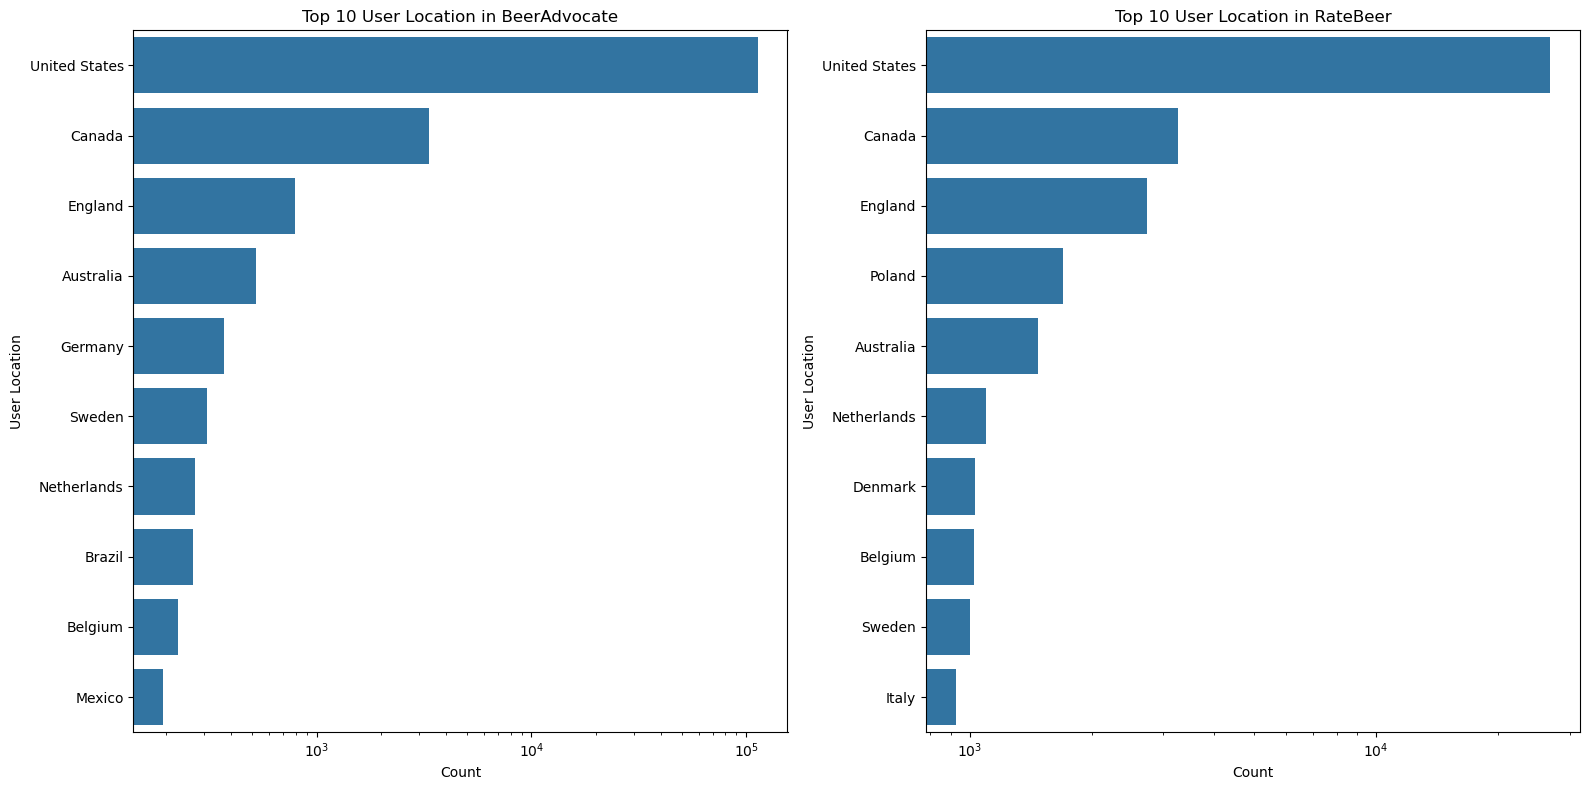

In [44]:
# Distribution of user locations
# 10 most frequent user locations for each dataset (to make plots easier to read)
ba_top_10_user_locations = ba_users[ba_users['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_user_locations = rb_users[rb_users['location'] != 'nan']['location'].value_counts().head(10)

top_10_plots(ba_top_10_user_locations,rb_top_10_user_locations,'User Location') # Plot function

We can see that for the 2 websites, the vast majority of users come from the US. The next most common user locations are Canada and England.

Let us now observe the distribution of brewery locations.

In [45]:
print('Number of distinct brewery locations:',pd.concat([ba_breweries['location'],rb_breweries['location']]).nunique())

Number of distinct brewery locations: 218


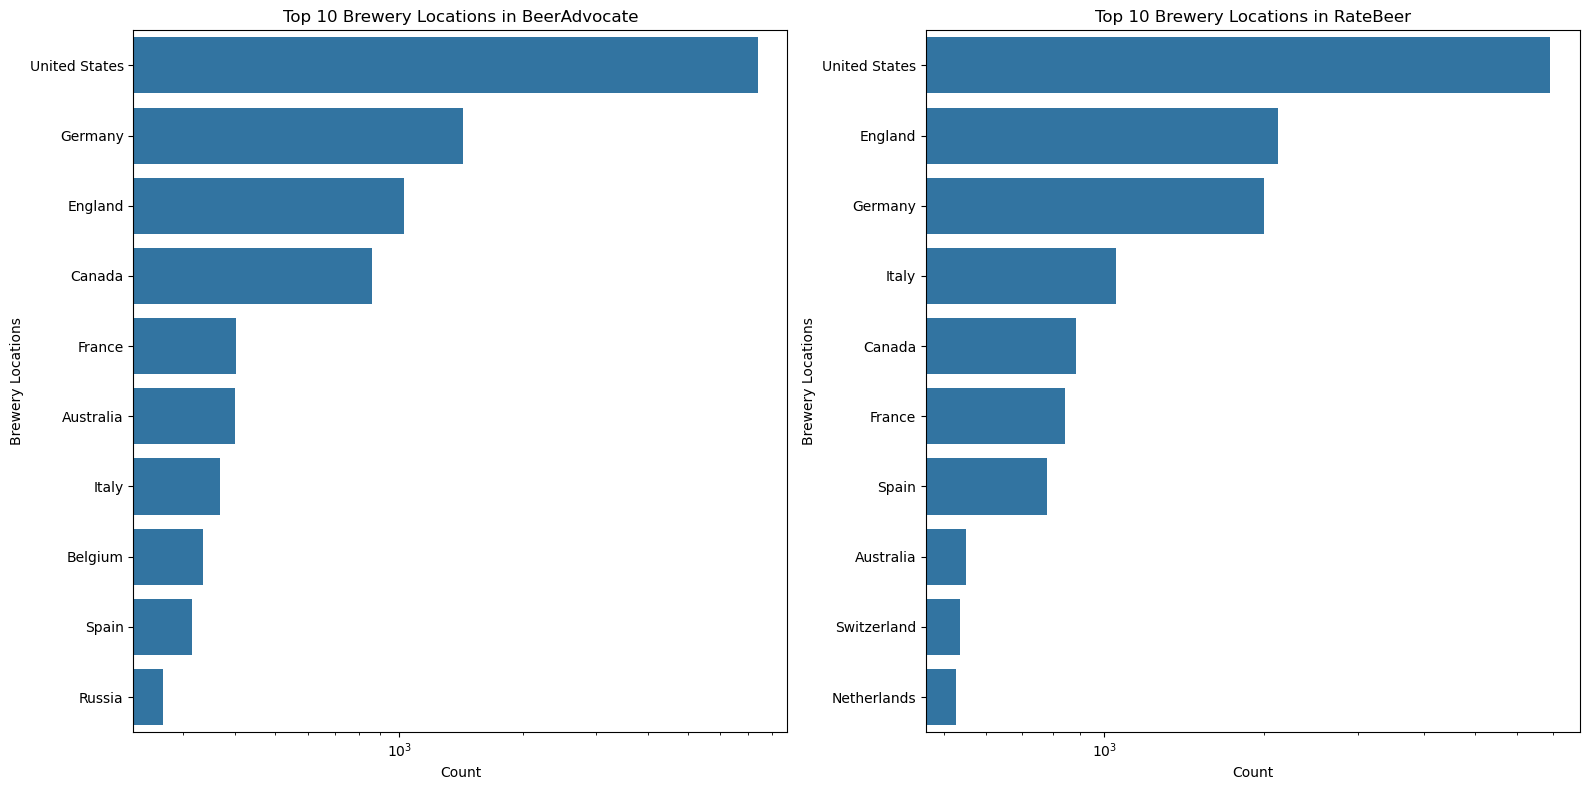

In [46]:
# Distribution of brewery locations
# 10 most frequent brewery locations for each dataset (to make plots easier to read)
ba_top_10_brewery_locations = ba_breweries[ba_breweries['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_brewery_locations = rb_breweries[rb_breweries['location'] != 'nan']['location'].value_counts().head(10)

top_10_plots(ba_top_10_brewery_locations,rb_top_10_brewery_locations,'Brewery Locations')

Similarly, we can observe that the vast majority of breweries included in the 2 datasets are located in the US. The next most common brewery locations are Germany and England.

### **ADDITION OF USEFUL COLUMNS**

To streamline our analysis and avoid redundant computations, we will calculate certain statistics that will be used in several parts of the analysis once and store them as new columns in the respective dataframes.

Let us first add a column to the rating dataframes corresponding to the average rating given by the user who wrote the review.

In [47]:
# calculate the average rating for each user
average_ratings_by_user_ba = ba_ratings.groupby('user_id')['rating'].mean().reset_index()
average_ratings_by_user_ba.rename(columns={'rating': 'user_avg_rating'}, inplace=True)

average_ratings_by_user_rb = rb_ratings.groupby('user_id')['rating'].mean().reset_index()
average_ratings_by_user_rb.rename(columns={'rating': 'user_avg_rating'}, inplace=True)

# add the average ratings by user to the rating dataframes
ba_ratings = ba_ratings.merge(average_ratings_by_user_ba, on='user_id', how='left')
rb_ratings = rb_ratings.merge(average_ratings_by_user_rb, on='user_id', how='left')

ba_ratings.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  aroma  palate  taste  overall  rating  \
0         nmann08.184925        3.25   2.75    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00   3.50    3.50   4.00      3.5    3.67   
2          mdagnew.19527        4.00   3.50    3.50   4.00      3.5    3.73   
3  helloloser12345.10867        4.00   3.50    4.00   4.00      4.5    3.98   
4        cypressbob.3708        4.00   4.00    4.00   4.00      4.0    4.00   

   user_avg_rating  
0         3.730887  
1         3.885664  
2         3.866884  
3         3.563226  
4         3.624354

Let us now add a column to the rating dataframes corresponding to the average rating of all beers coming from the brewery that produced the reviewed beer. This metric can be used as a proxy for brewery reputation and will be used in certain parts of the analysis to account for the fact that some breweries might have established reputations that bias user ratings.

In [48]:
# calculate the average rating for each brewery
average_ratings_by_brewery_ba = ba_ratings.groupby('brewery_id')['rating'].mean().reset_index()
average_ratings_by_brewery_ba.rename(columns={'rating': 'brewery_avg_rating'}, inplace=True)

average_ratings_by_brewery_rb = rb_ratings.groupby('brewery_id')['rating'].mean().reset_index()
average_ratings_by_brewery_rb.rename(columns={'rating': 'brewery_avg_rating'}, inplace=True)

# add the average ratings by brewery to the rating dataframes
ba_ratings = ba_ratings.merge(average_ratings_by_brewery_ba, on='brewery_id', how='left')
rb_ratings = rb_ratings.merge(average_ratings_by_brewery_rb, on='brewery_id', how='left')

ba_ratings.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  aroma  palate  taste  overall  rating  \
0         nmann08.184925        3.25   2.75    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00   3.50    3.50   4.00      3.5    3.67   
2          mdagnew.19527        4.00   3.50    3.50   4.00      3.5    3.73   
3  helloloser12345.10867        4.00   3.50    4.00   4.00      4.5    3.98   
4        cypressbob.3708        4.00   4.00    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  
0         3.730887            2.880000  
1         3.885664            3.526513  
2         3.866884            3.526513  
3         3.563226            3.526513  
4         3.624354            3.526513

We will now add a column to the rating dataframes corresponding to the average rating of all beers with the same style as the reviewed beer. 

In [49]:
# calculate the average rating for each beer style
average_ratings_by_style_ba = ba_ratings.groupby('style')['rating'].mean().reset_index()
average_ratings_by_style_ba.rename(columns={'rating': 'style_avg_rating'}, inplace=True)

average_ratings_by_style_rb = rb_ratings.groupby('style')['rating'].mean().reset_index()
average_ratings_by_style_rb.rename(columns={'rating': 'style_avg_rating'}, inplace=True)

# add the average ratings by style to the rating dataframes
ba_ratings = ba_ratings.merge(average_ratings_by_style_ba, on='style', how='left')
rb_ratings = rb_ratings.merge(average_ratings_by_style_rb, on='style', how='left')

ba_ratings.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  aroma  palate  taste  overall  rating  \
0         nmann08.184925        3.25   2.75    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00   3.50    3.50   4.00      3.5    3.67   
2          mdagnew.19527        4.00   3.50    3.50   4.00      3.5    3.73   
3  helloloser12345.10867        4.00   3.50    4.00   4.00      4.5    3.98   
4        cypressbob.3708        4.00   4.00    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  style_avg_rating  
0         3.730887            2.880000          2.986608  
1         3.885664            3.526513          3.542445  
2         3.866884            3.526513          3.542445  
3         3.563226            3.526513          3.542445  
4         3.624354            3.526513          3.542445

Finally, we will add a column to the rating dataframes corresponding to the number of reviews given by the user who wrote the review.

In [260]:
# merge the rating dataframes with the users dataframes on user_id
ba_ratings = ba_ratings.merge(ba_users[['user_id', 'nbr_reviews']], on='user_id', how='left')
rb_ratings = rb_ratings.merge(rb_users[['user_id', 'nbr_ratings']], on='user_id', how='left')

ba_ratings = ba_ratings.rename(columns={'nbr_reviews': 'user_nb_reviews'})
rb_ratings = rb_ratings.rename(columns={'nbr_ratings': 'user_nb_reviews'})

ba_ratings.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  aroma  palate  taste  overall  rating  \
0         nmann08.184925        3.25   2.75    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00   3.50    3.50   4.00      3.5    3.67   
2          mdagnew.19527        4.00   3.50    3.50   4.00      3.5    3.73   
3  helloloser12345.10867        4.00   3.50    4.00   4.00      4.5    3.98   
4        cypressbob.3708        4.00   4.00    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  style_avg_rating  user_nb_reviews  
0         3.730887            2.880000          2.986608            465.0  
1         3.885664            3.526513          3.542445           2504.0  
2         3.866884            3.526513          3.542445           1143.0  
3         3.563226            3.526513          3.542445             31.0  
4         3.624354            3.526513          3.542445            604.0

### **'LOCATION-SPECIFIC' CLEANING**

Several parts of our analysis will involve comparing data from different countries and will require working with the location information in the user DataFrames. In these parts, we will only consider countries with a 'sufficiently large' number of reviewers, as only a few reviewers may not be representative of an entire country. We will thus filter out countries that we consider to have not enough reviewers. We decide arbitrarily to filter out countries with less than 50 different reviewers.

In this part of the data cleaning, we will work on a copy of the original DataFrames, and we will use these copies only for the parts of the analysis where we compare certain countries. Indeed, this filtering is not relevant for the parts that do not involve comparing certain countries.

In [51]:
# create copies of the user and rating DataFrames, which will undergo filtering related to the location information
ba_users_loc_filtered = ba_users.copy()
rb_users_loc_filtered = rb_users.copy()
ba_ratings_loc_filtered = ba_ratings.copy()
rb_ratings_loc_filtered = rb_ratings.copy()

## Removing users with missing location information

First, let us determine if some users are missing the location information.

In [52]:
# get the number of users with 'nan' in the 'location' column
# Beer Advocate
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
# Rate Beer
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 31279
Number of users lacking the location information (Rate Beer): 19582


We can see that there are indeed some users missing the location information. Let us remove these users.

In [53]:
# remove users with 'nan' in the 'location' column
ba_users_loc_filtered = ba_users_loc_filtered[ba_users_loc_filtered['location'] != 'nan']
rb_users_loc_filtered = rb_users_loc_filtered[rb_users_loc_filtered['location'] != 'nan']

# verification
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 0
Number of users lacking the location information (Rate Beer): 0


## Filtering out users and reviews written by users from countries with too few users

Let us first identify the countries with a number of users that is smaller than the threshold we set earlier, that is, 10 users.

In [54]:
USER_NB_THRESHOLD = 50

# concatenate the 'location' columns from the 2 user dataframes
combined_locations = pd.concat([ba_users_loc_filtered['location'], rb_users_loc_filtered['location']])

# get the counts of each unique value in 'location'
location_counts = combined_locations.value_counts()

# keep only locations with less than 50 counts
locations_with_few_counts = location_counts[location_counts < USER_NB_THRESHOLD]

# Get the list of location values with less than 50 counts
countries_with_few_users = locations_with_few_counts.index.tolist()

print("Countries with less than 50 users across both DataFrames:")
print(countries_with_few_users)

Countries with less than 50 users across both DataFrames:
['Aotearoa', 'Panama', 'Colombia', 'Bosnia and Herzegovina', 'Costa Rica', 'Cyprus', 'Luxembourg', 'Belarus', 'Dominican Republic', 'El Salvador', 'Peru', 'Moldova', 'Guatemala', 'Ecuador', 'Macedonia', 'Venezuela', 'Paraguay', 'Uruguay', 'Lebanon', 'Malaysia', 'Vietnam', 'Indonesia', 'Virgin Islands (U.S.)', 'Bahamas', 'Faroe Islands', 'Afghanistan', 'Malta', 'Andorra', 'Cambodia', 'Guam', 'Kenya', 'United Arab Emirates', 'Isle of Man', 'Antarctica', 'Cayman Islands', 'Bermuda', 'Bolivia', 'Honduras', 'Montenegro', 'Egypt', 'Tanzania', 'Uganda', 'Botswana', 'Zimbabwe', 'Albania', 'Tajikistan', 'Azerbaijan', 'Trinidad and Tobago', 'American Samoa', 'Tunisia', 'Jersey', 'Vanuatu', 'Pakistan', 'Jordan', 'Mauritius', 'Belize', 'Nicaragua', 'Barbados', 'Mozambique', 'Aruba', 'Uzbekistan', 'Nigeria', 'Palestine', 'Namibia', 'Abkhazia', 'Papua New Guinea', 'Armenia', 'Morocco', 'Nepal', 'Burkina Faso', 'Marshall Islands', 'Ascension I

Let us determine if filtering out these 113 countries would leave us with enough data, ie with enough countries, to perform our analysis comparing different countries.

In [55]:
print('Remaining countries after filtering:',(len(location_counts)-len(locations_with_few_counts)))

Remaining countries after filtering: 55


Filtering out those countries would leave us with 55 countries, which is enough to perform our analysis.

Ultimately, we would like to remove reviews from users coming from countries with too few reviewers. 
To do so, we will start by adding the user location information to review DataFrames. This will facilitate the filtering and analysis.

In [56]:
# merge rating dataframes with user dataframes on 'user_id' to add the'location' column to rating dataframes as 'user_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'user_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'user_location'})

ba_ratings_loc_filtered.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  aroma  palate  taste  overall  rating  \
0         nmann08.184925        3.25   2.75    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00   3.50    3.50   4.00      3.5    3.67   
2          mdagnew.19527        4.00   3.50    3.50   4.00      3.5    3.73   
3  helloloser12345.10867        4.00   3.50    4.00   4.00      4.5    3.98   
4        cypressbob.3708        4.00   4.00    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  style_avg_rating     user_location  
0         3.730887            2.880000          2.986608     United States  
1         3.885664            3.526513          3.542445     United States  
2         3.866884            3.526513          3.542445  Northern Ireland  
3         3.563226            3.526513          3.542445  Northern Ireland  
4         3.624354            3.526513          3.542445  Northern Ireland

We now must remove the reviews from users whose location is NaN. Such users correspond to the users lacking a ocation information that have been previously removed from the user dataframes, but which are still present in the review dataframes.

In [57]:
# remove reviews from users for which the location is NaN
ba_ratings_loc_filtered = ba_ratings_loc_filtered.dropna(subset=['user_location'])
rb_ratings_loc_filtered = rb_ratings_loc_filtered.dropna(subset=['user_location'])

We can now remove reviews from users coming from countries with too few reviewers.

In [58]:
# remove reviews where 'user_location' is in the 'countries_with_few_users' list
ba_ratings_loc_filtered = ba_ratings_loc_filtered[~ba_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]
rb_ratings_loc_filtered = rb_ratings_loc_filtered[~rb_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]

We will now remove users coming from countries with too few reviewers from the user dataframes.

In [59]:
# remove users for which 'location' is in the 'countries_with_few_users' list
ba_users_loc_filtered = ba_users_loc_filtered[~ba_users_loc_filtered['location'].isin(countries_with_few_users)]
rb_users_loc_filtered = rb_users_loc_filtered[~rb_users_loc_filtered['location'].isin(countries_with_few_users)]

In [60]:
ba_users_loc_filtered.head()

nbr_ratings  nbr_reviews                user_id        user_name  \
0         7820          465         nmann08.184925          nmann08   
1         2521         2504     stjamesgate.163714      StJamesGate   
2         1797         1143          mdagnew.19527          mdagnew   
3           31           31  helloloser12345.10867  helloloser12345   
4          604          604        cypressbob.3708       cypressbob   

           location  
0     United States  
1     United States  
2  Northern Ireland  
3  Northern Ireland  
4  Northern Ireland

In [61]:
rb_users_loc_filtered.head()

nbr_ratings  user_id     user_name location
0         1890   175852       Manslow   Poland
1           89   442761  MAGICuenca91    Spain
2          169   288889        Sibarh   Poland
3         3371   250510       fombe89    Spain
4        13043   122778    kevnic2008  Germany

## Adding brewery location information to filtered review DataFrames

Finally, to facilitate our analysis, we will add the brewery location information for each beer reviewed in the review dataframes. 

In [62]:
ba_breweries_loc_filtered = ba_breweries.copy()
rb_breweries_loc_filtered = rb_breweries.copy()

In [63]:
# rename 'id' column to 'brewerie_id' column in brewery dataframes to facilitate merging with rating dataframes
ba_breweries_loc_filtered = ba_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})
rb_breweries_loc_filtered = rb_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})

# merge rating dataframes with brewery dataframes on 'brewery_id' to add the'location' column to rating dataframes as 'brewerie_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

ba_ratings_loc_filtered.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  aroma  palate  taste  overall  rating  \
0         nmann08.184925        3.25   2.75    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00   3.50    3.50   4.00      3.5    3.67   
2          mdagnew.19527        4.00   3.50    3.50   4.00      3.5    3.73   
3  helloloser12345.10867        4.00   3.50    4.00   4.00      4.5    3.98   
4        cypressbob.3708        4.00   4.00    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  style_avg_rating     user_location  \
0         3.730887            2.880000          2.986608     United States   
1         3.885664            3.526513          3.542445     United States   
2         3.866884            3.526513          3.542445  Northern Ireland   
3         3.563226            3.526513          3.542445  Northern Ireland   
4         3.624354            3.526513          3.542445  Northern Ireland   

   brewery_location  
0             Gabon  
1  Northern Ireland  
2  Northern Ireland  
3  Northern Ireland  
4  Northern Ireland

# 1) Link between culture and taste

## a) Beer style preferences

In this part, we will examine how different beer styles are reviewed across different countries. 

For P2, we will start by comparing the number of reviews for different beer styles in different countries. 

For P3, we will use the average rating of certain beer styles as features of a given country and use a clustering algorithm to determine if certain countries cluster together in terms of beer style preferences. We will also use the time information in reviews to determine if regional beer style preferences remain stable over time — supporting the hypothesis that they are influenced by culture — or if they fluctuate, suggesting other contributing factors.

Here we concanated the two data frames together and added a source column so that we are not losing track of the origin of each rating.This data frame will be the main data frame for linear regression analysis and the clustering as it will give us the total ratings

In [64]:
total_ratings_loc_filtered = pd.concat([ba_ratings_loc_filtered, rb_ratings_loc_filtered], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_loc_filtered = total_ratings_loc_filtered.reset_index(drop=True)
total_ratings_loc_filtered.head()

source      beer_name   beer_id                               brewery_name  \
0     ba          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4     ba  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  ...  aroma  palate  taste  overall  rating  \
0         nmann08.184925  ...   2.75    3.25   2.75      3.0    2.88   
1     stjamesgate.163714  ...   3.50    3.50   4.00      3.5    3.67   
2          mdagnew.19527  ...   3.50    3.50   4.00      3.5    3.73   
3  helloloser12345.10867  ...   3.50    4.00   4.00      4.5    3.98   
4        cypressbob.3708  ...   4.00    4.00   4.00      4.0    4.00   

   user_avg_rating  brewery_avg_rating  style_avg_rating     user_location  \
0         3.730887            2.880000          2.986608     United States   
1         3.885664            3.526513          3.542445     United States   
2         3.866884            3.526513          3.542445  Northern Ireland   
3         3.563226            3.526513          3.542445  Northern Ireland   
4         3.624354            3.526513          3.542445  Northern Ireland   

   brewery_location  
0             Gabon  
1  Northern Ireland  
2  Northern Ireland  
3  Northern Ireland  
4  Northern Ireland  

[5 rows x 21 columns]

Let's start with initial statistics about the which beers and beer styles are most commonly rated in overall data. Before analyzing the beer style preferences in each country or region, we should ensure that we have enough information in the data and whether it is consistent (for example, low variance and low bias) or not for clustering.

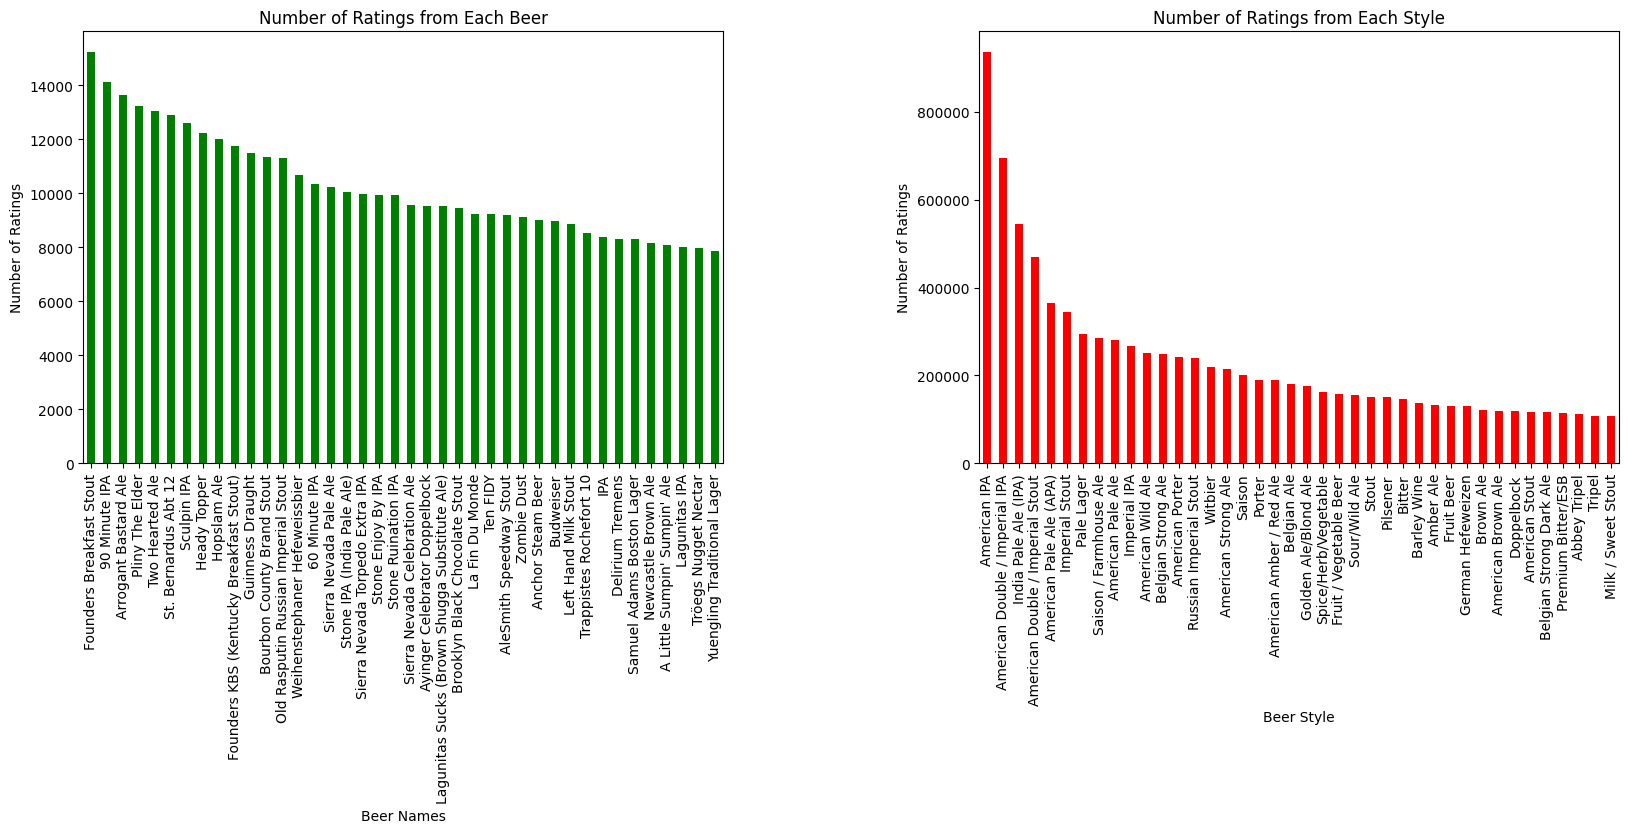

In [65]:
beer_name_values = total_ratings_loc_filtered['beer_name'].value_counts()
beer_style_values = total_ratings_loc_filtered['style'].value_counts()

plt.subplot(1,2,1)
beer_name_values[0:40].plot(kind='bar',color='g')
plt.title("Number of Ratings from Each Beer")
plt.xlabel("Beer Names")
plt.ylabel("Number of Ratings")

plt.subplot(1,2,2)
beer_style_values[0:40].plot(kind='bar',color='r')
plt.title("Number of Ratings from Each Style")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")

plt.subplots_adjust(left=1.5,bottom=0.1, right=3.9, top=1, wspace=0.4, hspace=2)

plt.show()

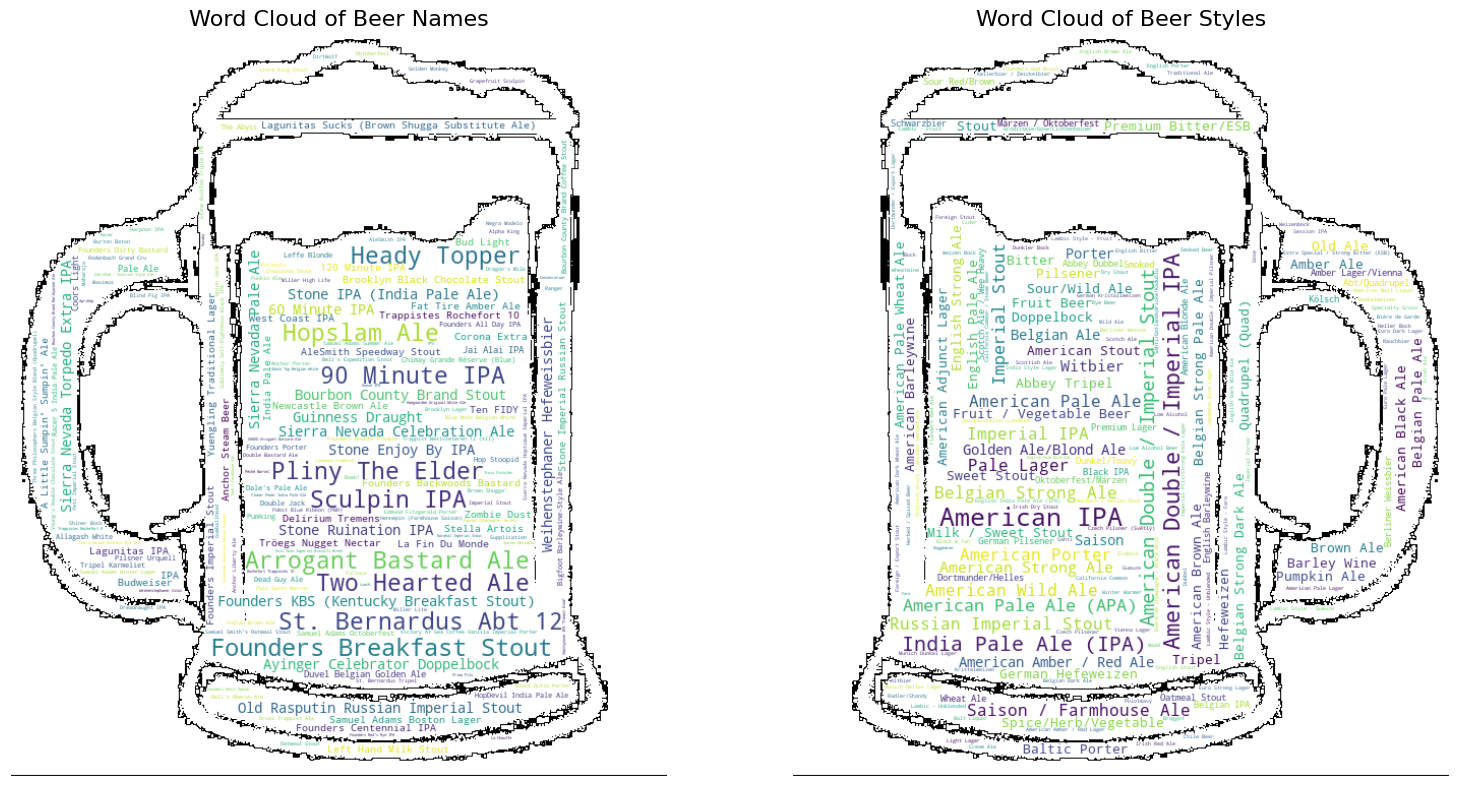

In [66]:
mask_image_path1 = "data/Oktoberfest_Beer_Mug_processed_mask_flipped.png"
mask_image_path2 = "data/Oktoberfest_Beer_Mug_processed_mask.png"

 # Generating wordclouds with the function that we wrote in data_utils

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
generate_wordcloud_from_series(beer_name_values,"Word Cloud of Beer Names", mask_image_path1, ax=axes[0] )
generate_wordcloud_from_series(beer_style_values,"Word Cloud of Beer Styles", mask_image_path2, ax=axes[1] )

plt.tight_layout()
plt.show()

The **histograms** and **word cloud maps** show that the distribution of ratings of popular beer brands and styles across the world based on BeerAdvocate and RateBeer data. In the left chart, the most-rated beer brand, "St. Bernardus Abt 12," received over 8,000 ratings, followed closely by "Guinness Draught" and other popular brands that have between 5,000 and 8,000 ratings. This partially indicates that there is almost an uniform distribution among the well-known brands. 

On the other hand, the right chart reveals that specific beer styles dominate in popularity. "American IPA" leads with over 550,000 ratings, followed by "India Pale Ale (IPA)" at around 500,000 ratings. Other styles like "Imperial Stout" and "Pale Ale" also feature prominently, with over 200,000 ratings each.

Let's further analyze the popular beer styles, for example consider the most famous one which is **'American IPA'**. Where are its ratings coming from? Is it really the most popular beer in the world or it is the leading one because of the number of users from specific regions dominate the ratings (in other words, basically it is the favorite preference of associated region)

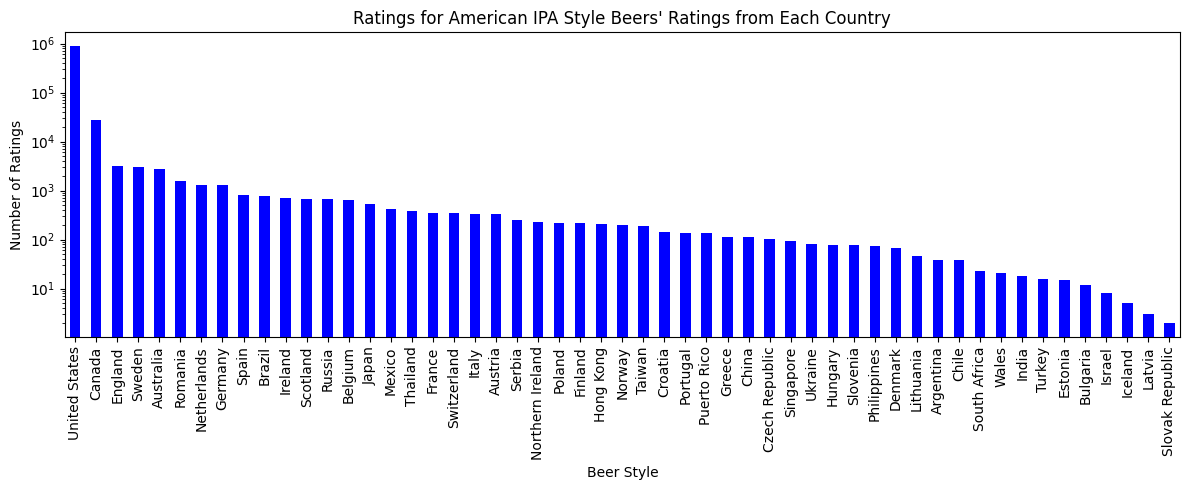

In [67]:
american_IPA_country_values = total_ratings_loc_filtered[total_ratings_loc_filtered['style'] == 'American IPA']
counts_american_IPA_values = american_IPA_country_values['user_location'].value_counts()

plt.figure(figsize=(12, 5))
counts_american_IPA_values[0:60].plot(kind='bar',color='b',logy = True)
plt.title("Ratings for American IPA Style Beers' Ratings from Each Country")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")
plt.tight_layout()

plt.show()

From the log scaled plot, we observe that the United States has a dominant lead in the number of ratings, reaching around 10^5 ratings, which is significantly higher than any other country. This dominance suggests that American IPA is extremely popular in its country of origin, aligning with the general preference for this style in the U.S. Following the U.S., Canada, Denmark, England, and Sweden also show notable levels of engagement, although their rating counts are much lower, in the range of 10^3 to 10^4. These countries represent regions with a strong craft beer culture, indicating that American IPA has gained substantial popularity internationally as well. The presence of other countries with moderate ratings, such as Germany, Netherlands, and Japan, suggests a widespread appreciation for this style, though at a smaller scale.

**To sum up, the chart demonstrates significant variation in preferences for the American IPA style across countries, with the United States showing an overwhelming number of ratings compared to other regions. This suggests that beer preferences are not uniform globally; instead, they exhibit clear regional patterns**

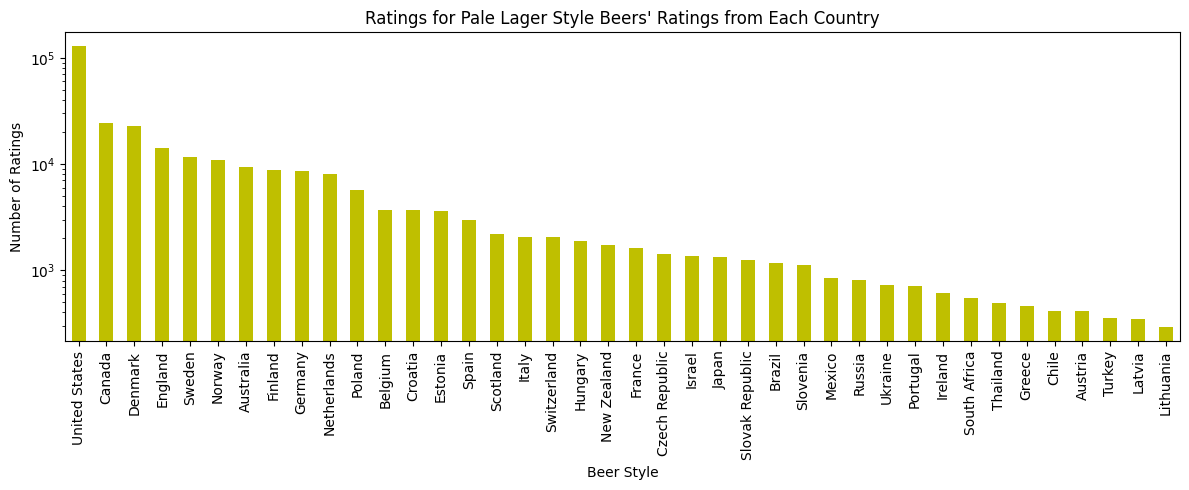

In [68]:
pale_lager_country_values = total_ratings_loc_filtered[total_ratings_loc_filtered['style'] == 'Pale Lager']
counts_pale_lager_values = pale_lager_country_values['user_location'].value_counts()

plt.figure(figsize=(12, 5))
counts_pale_lager_values[0:40].plot(kind='bar',color='y',logy = True)
plt.title("Ratings for Pale Lager Style Beers' Ratings from Each Country")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")
plt.tight_layout()

plt.show()

Let's also look at **Pale Lager** data which demonstrates that the difference between the U.S. and other countries is notably smaller for this beer style. European countries such as Denmark, England, Germany, and Sweden have substantial ratings even though the United States still leads with the highest number of ratings(because there are a significant number of users in particularly from U.S). This is in contrast to the American IPA style, which had a much stronger concentration of ratings in the United States, underscoring its origins and specific popularity in American craft beer culture. This distribution suggests that Pale Lager, in European countries, which have long-established beer cultures, particularly favor this style. This trend highlights the importance of considering regional preferences in beer style analysis, as Pale Lager’s popularity spans multiple regions, reflecting its acceptance as a global standard. It also underscores the need for clustering techniques to identify and analyze patterns based on these regional preferences.

**To implement the clustering to decide which beer style is most popular in each country / geographic area first we need to consider these steps:**

- Determine the axes initially, in our case these are the 1) countries, 2) beer styles and 3) number of ratings. Therefore, this suggests 3D dimensional visualization.
- For the countries, region of interests should be decided, we should determine each region that includes the choosing the countries (for example, we can divide Europe in different subsets such as West/East etc.) We are planning to use K-means clustering because we do not have the labels, we want to discover & reveal patterns like regional preferences or popular beer styles in specific countries.
- Morever, simply number of ratings from each country are not enough to decide which beer style is most preferrable in the particular regions. Overall ratings, time effects should also be considered. Because of the possible dimension increase in the data, we will need to apply PCA to reduce the dimensionality of the dataset.

Let's visualize the initial data we have. First, we need to convert to data into useful frame:

In [69]:
merged_df = merge_data_(total_ratings_loc_filtered) # Merging existing data into new dataframe in order to visualize it

merged_df.head()

user_location            Argentina  Australia  Austria  Belgium  Brazil  \
Euro Pale Lager               27.0      923.0    196.0    378.0   209.0   
English Pale Ale              20.0     2803.0     94.0    414.0   274.0   
English Bitter                 1.0      483.0      8.0     65.0    42.0   
American Pale Wheat Ale        2.0      260.0     10.0     32.0    87.0   
American Blonde Ale            3.0      360.0     18.0     64.0    55.0   

user_location            Bulgaria  Canada  Chile  China  Croatia  ...  \
Euro Pale Lager              50.0  4581.0   21.0   59.0    173.0  ...   
English Pale Ale             11.0  9683.0   68.0   56.0    227.0  ...   
English Bitter                1.0  1743.0    1.0   21.0     17.0  ...   
American Pale Wheat Ale       0.0  2523.0    0.0   15.0      5.0  ...   
American Blonde Ale           2.0  3257.0    0.0    8.0      9.0  ...   

user_location            South Korea  Spain  Sweden  Switzerland  Taiwan  \
Euro Pale Lager                  0.0  449.0  1106.0        262.0    40.0   
English Pale Ale                 1.0  763.0  2885.0        307.0    51.0   
English Bitter                   0.0   83.0   329.0         36.0     8.0   
American Pale Wheat Ale          0.0   60.0   161.0         20.0    12.0   
American Blonde Ale              0.0   79.0   131.0         20.0    13.0   

user_location            Thailand  Turkey  Ukraine  United States  Wales  
Euro Pale Lager             127.0   136.0     82.0        36591.0    8.0  
English Pale Ale            163.0    34.0     56.0        67073.0   35.0  
English Bitter               32.0     4.0     15.0        16840.0   22.0  
American Pale Wheat Ale      24.0     1.0      4.0        95343.0    1.0  
American Blonde Ale          21.0     4.0      2.0        58958.0    4.0  

[5 rows x 55 columns]

Initially, we have the country names randomly distributed along the chosen axis; however, this makes clustering almost impossible and chaotic. As one can know, clustering depends on Euclidean (or it can be Non-Euclidean based on clustering method) distances. In addition to country sorting, we have 3D dimensional data which also makes clustering difficult; therefore, we implement
- Sorting the countries according to their regions (we group them using their region information from widely known classifications)
- Using Principal Component Analysis (PCA), we reduced the dimension of the data


In [70]:
country_region_mapping,merged_with_regions_sorted_0 = region_mapping(merged_df)  # To shorten Euclidean distance of the data, we manually sorted the countries and give them region labelling

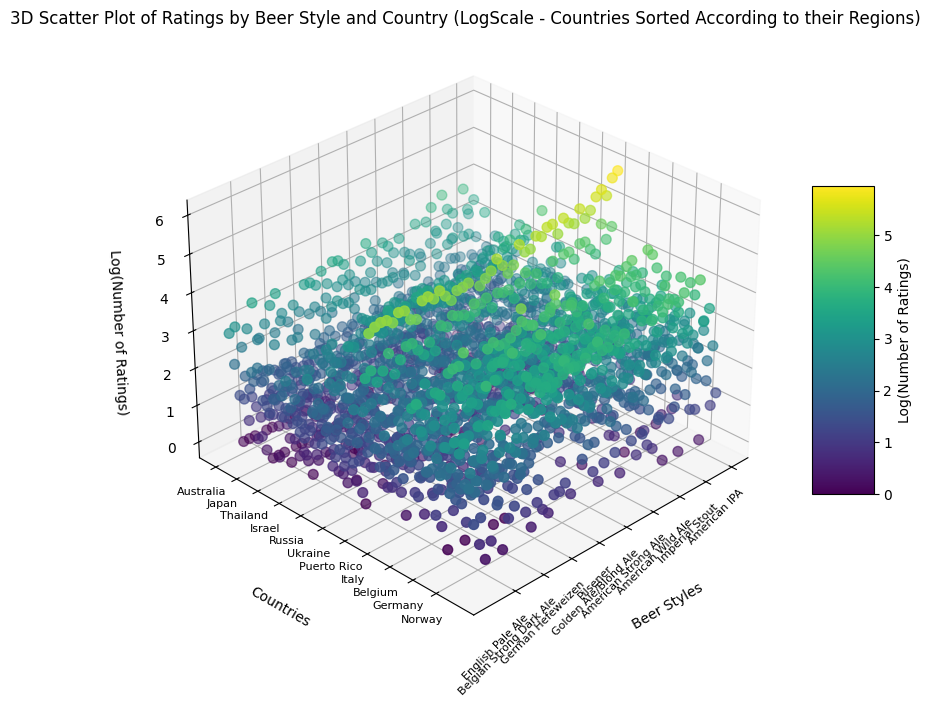

In [71]:
merged_with_regions_sorted = merged_with_regions_sorted_0[:-1]
merged_with_regions_sorted = merged_with_regions_sorted.apply(pd.to_numeric, errors='coerce')
top_styles_sorted = merged_with_regions_sorted.sum(axis=1).nlargest(45).index  # Sum ratings by style and select top 45

subset_df_ = merged_with_regions_sorted.loc[top_styles_sorted, :]

plot_3D_scatter(subset_df_,"3D Scatter Plot of Ratings by Beer Style and Country (LogScale - Countries Sorted According to their Regions)")

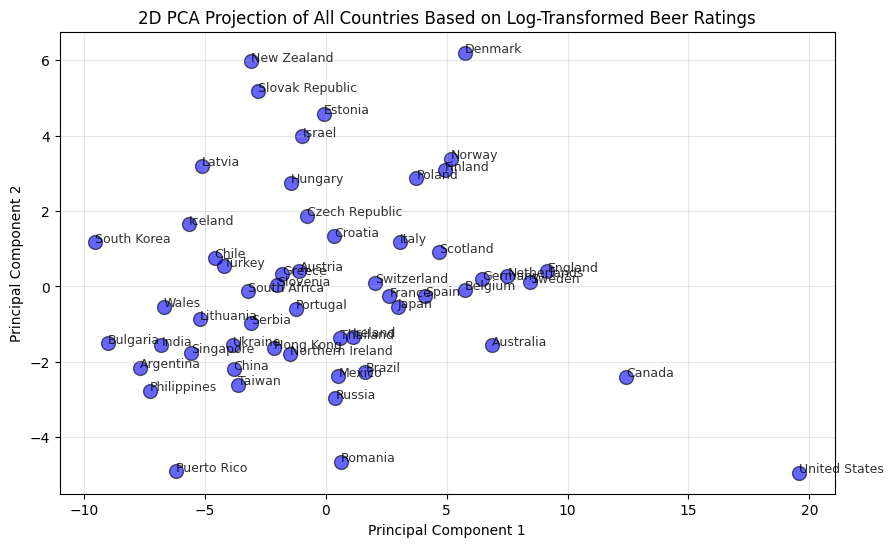

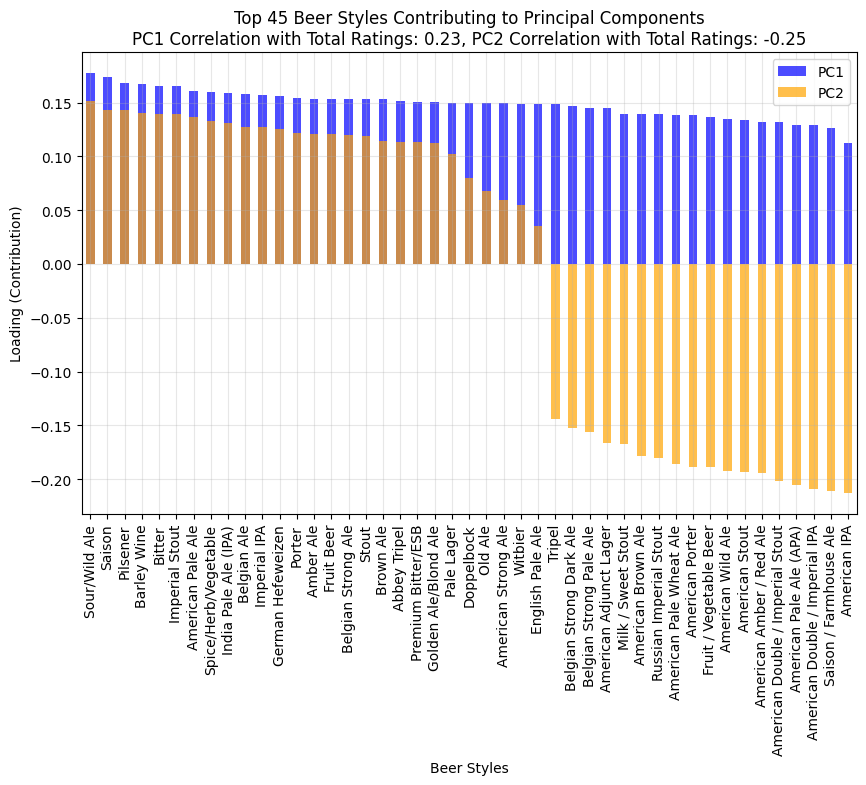

<Figure size 640x480 with 0 Axes>

In [72]:
# Apply the PCA to the our DataFrame with logarithmic scaling for all countries

pca_componentss,loadingss = plot_PCA_2D_with_loadings(subset_df_,'2D PCA Projection of All Countries Based on Log-Transformed Beer Ratings')

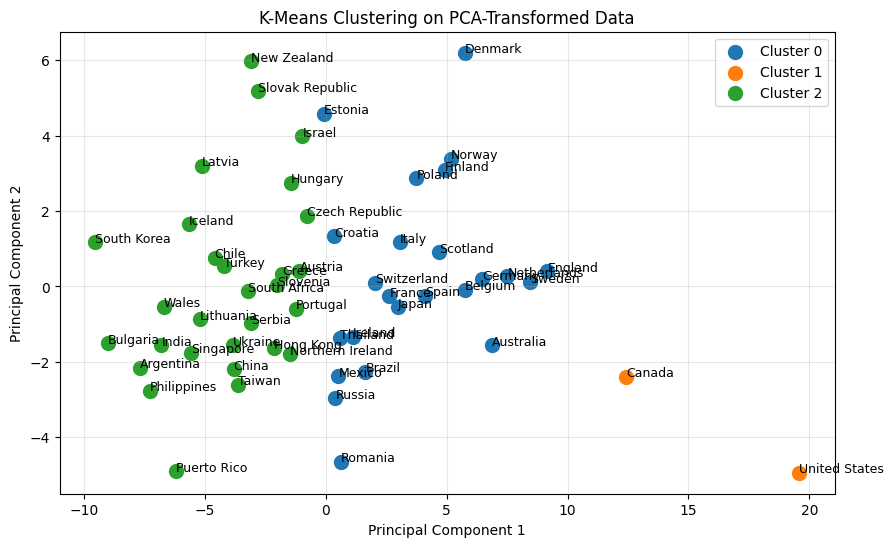

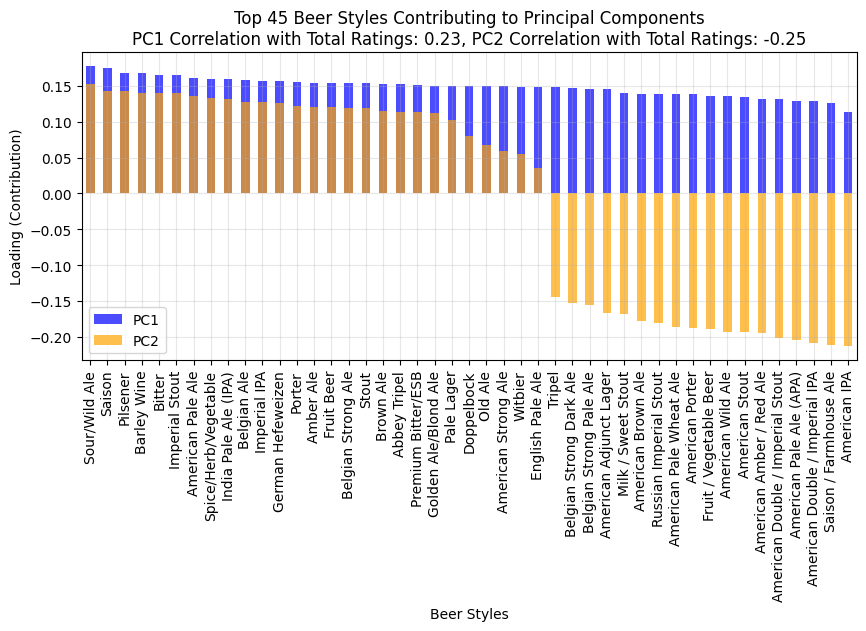

<Figure size 640x480 with 0 Axes>

In [73]:
country_names = list(subset_df_.columns)
#K-Means Clustering (Initially the number of clusters was chosen as n=3 to see how it works)

kmeans = KMeans(n_clusters=3, random_state=42)  # Choose number of clusters
clusters = kmeans.fit_predict(pca_componentss)

pca_transformed = pd.DataFrame(pca_componentss, columns=["PC1", "PC2"])
pca_transformed['Cluster'] = clusters
pca_transformed['Country'] = country_names

plt.figure(figsize=(10, 6))
plot_clusters(pca_transformed)  #Visualize the Clusters

# Calculate the correlation between the number of ratings and PCA loadings
total_ratings = subset_df_.sum(axis=1)
loadingss['Total Ratings'] = total_ratings
pc1_corr = loadingss[['PC1', 'Total Ratings']].corr().iloc[0, 1]
pc2_corr = loadingss[['PC2', 'Total Ratings']].corr().iloc[0, 1]

plt.figure(figsize=(10, 4))
plot_pca_loadings(loadingss,pc1_corr,pc2_corr)  # Plotting the PCA loadings

plt.tight_layout()
plt.show()

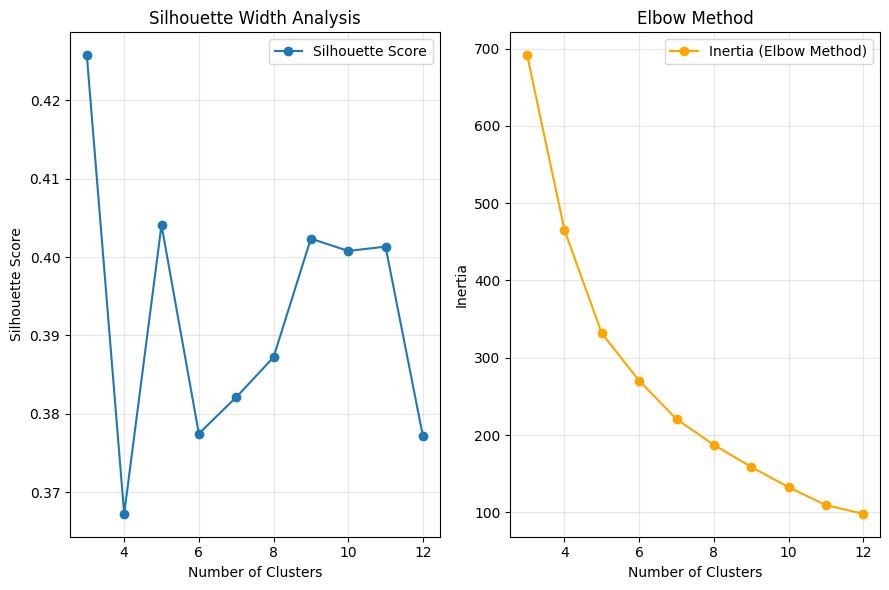

In [74]:
cluster_range = range(3, 13)  # From 3 to 12 clusters to find the optimum one
silhoutte_inertia_plotting(cluster_range,pca_componentss) # Plotting Silhouette Width and Inertia Scores

From the analysis, optimum number of clusters is chosen as **n = 5**

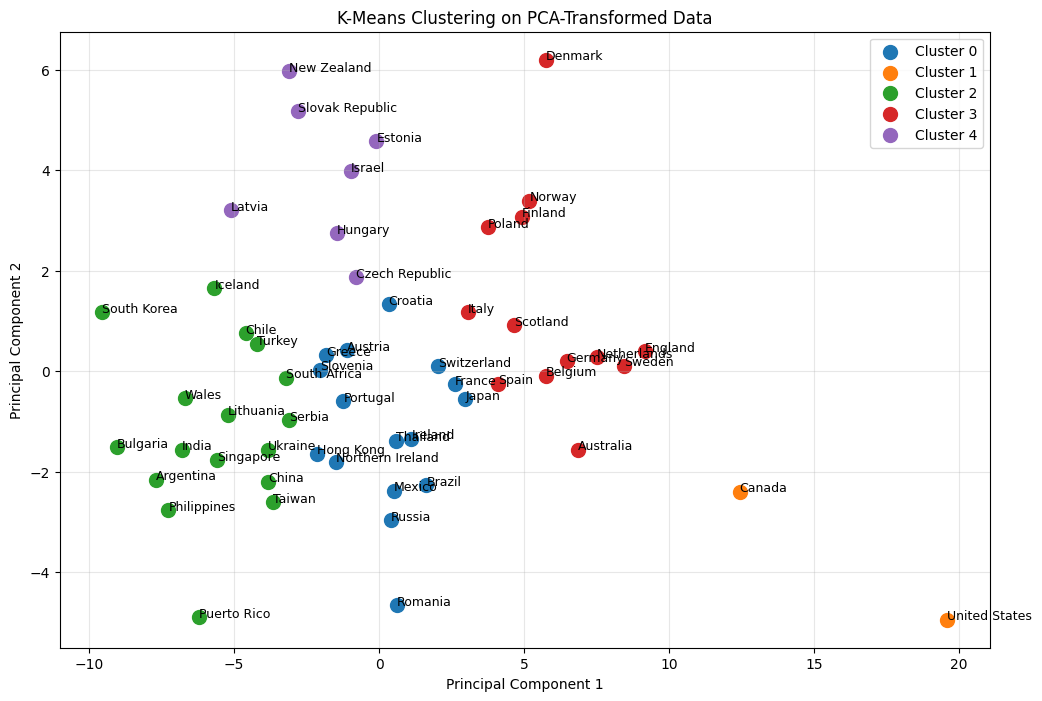

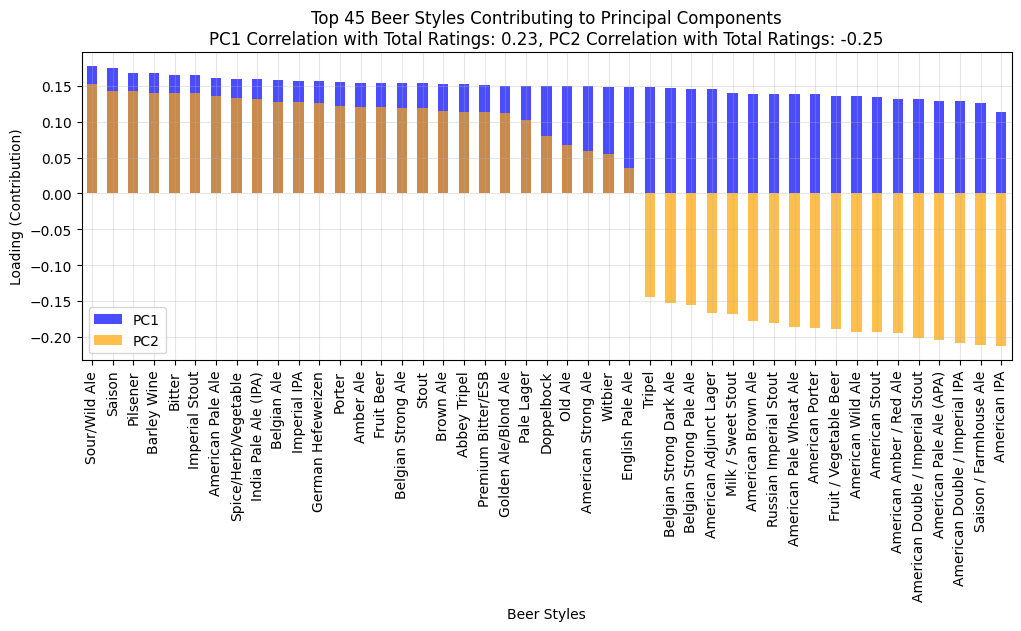

<Figure size 640x480 with 0 Axes>

In [75]:
# Extracting country names
country_names = list(subset_df_.columns)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose number of clusters
clusters = kmeans.fit_predict(pca_componentss)

# Combine Clustering Results with Country Names
pca_transformed = pd.DataFrame(pca_componentss, columns=["PC1", "PC2"])
pca_transformed['Cluster'] = clusters
pca_transformed['Country'] = country_names


plt.figure(figsize=(12, 8))
plot_clusters(pca_transformed) # Visualize the Clusters

# Calculate the correlation between the number of ratings and PCA loadings
total_ratings = subset_df_.sum(axis=1)
loadingss['Total Ratings'] = total_ratings
pc1_corr = loadingss[['PC1', 'Total Ratings']].corr().iloc[0, 1]
pc2_corr = loadingss[['PC2', 'Total Ratings']].corr().iloc[0, 1]

plt.figure(figsize=(12, 4))
plot_pca_loadings(loadingss,pc1_corr,pc2_corr)  # Plotting the PCA loadings

plt.tight_layout()
plt.show()

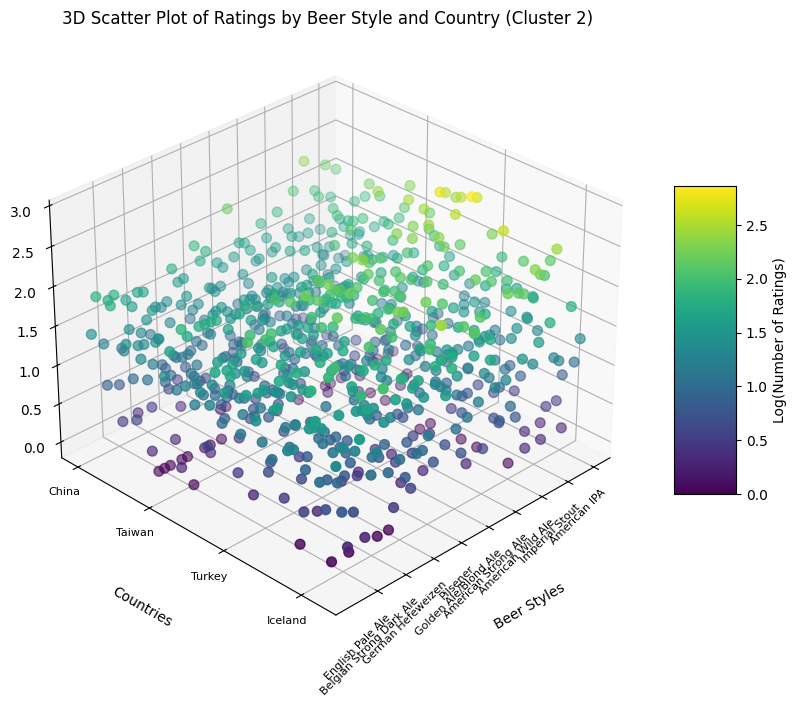

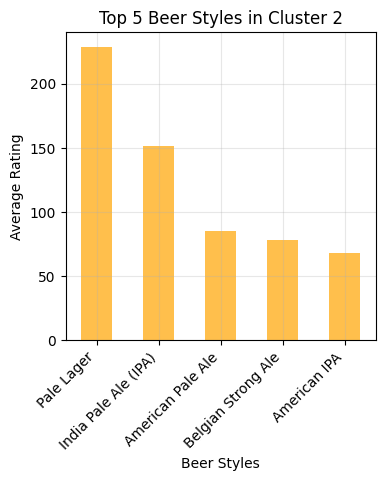

In [76]:
#  Extracting countries in the current cluster and filtering the actual data accordingly
subset_df_.columns = subset_df_.columns.str.strip()  # Clean column names
cluster_2_countries = pca_transformed.loc[pca_transformed['Cluster'] == 2, 'Country'].str.strip().tolist()
countries = [country for country in cluster_2_countries if country in subset_df_.columns]
cluster_2_data = subset_df_[countries]

plot_3D_scatter(cluster_2_data,'3D Scatter Plot of Ratings by Beer Style and Country (Cluster 2)')

# Visualize the top 5 beer styles
cluster_2_data['average_number_of_ratings'] = cluster_2_data.mean(axis=1)  #Calculate the average number of ratings for each beer style across valid countries

top_5_beer_styles = cluster_2_data['average_number_of_ratings'].sort_values(ascending=False).head(5)  #Sort the beer styles by average rating in descending order


top_5_beer_styles.plot(kind='bar', figsize=(4, 4), color='orange', alpha=0.7)
plt.title("Top 5 Beer Styles in Cluster 2")
plt.xlabel("Beer Styles")
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()

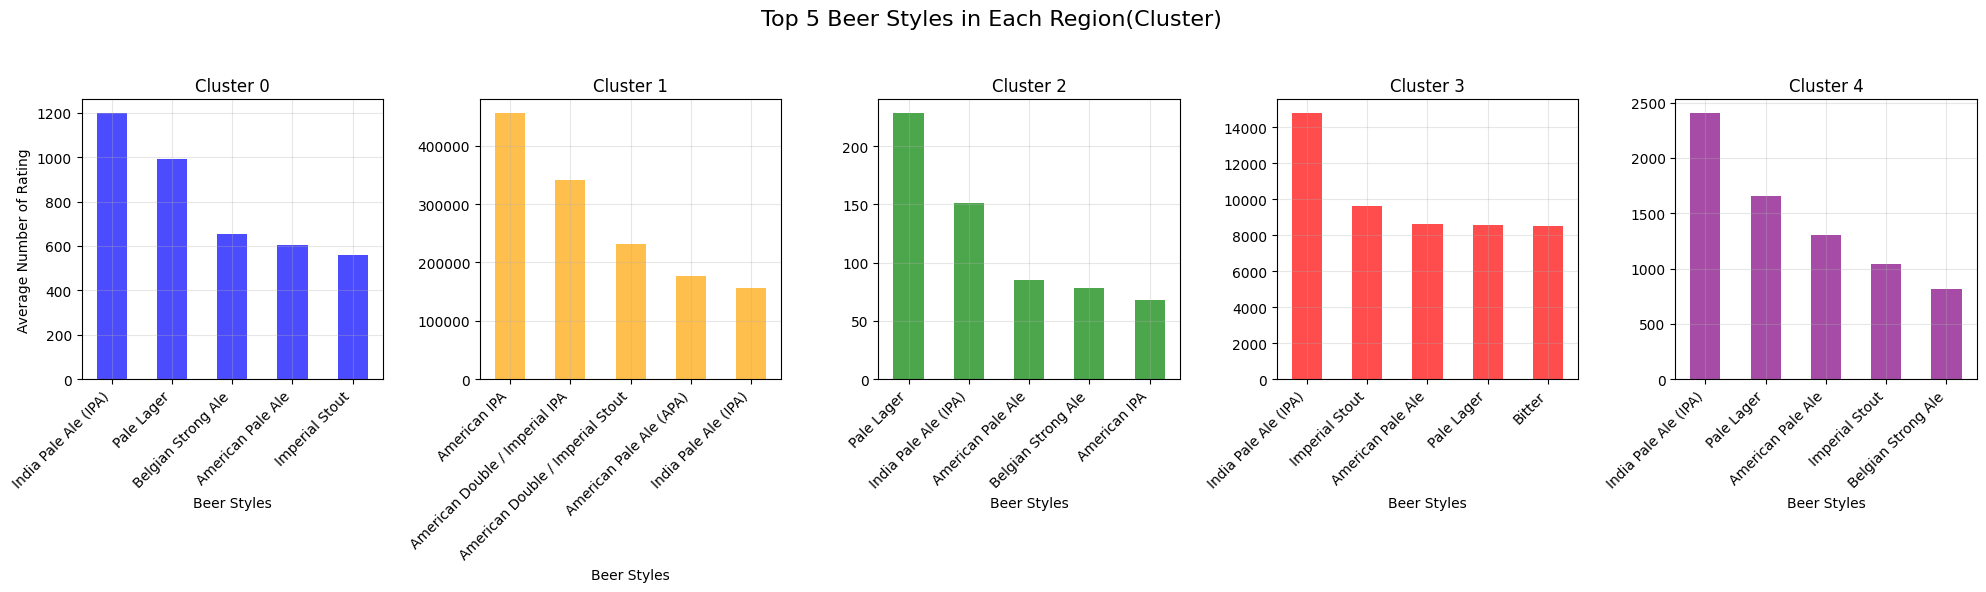

In [77]:
c,b= plot_regional_preferences(pca_transformed,subset_df_)

In [78]:
merged_df_counts_avg_ratings = merge_data_with_counts_and_avg_ratings(total_ratings_loc_filtered)
merged_df_counts_avg_ratings

Argentina_count  Australia_count  Austria_count  \
Euro Pale Lager                     27.0            923.0          196.0   
English Pale Ale                    20.0           2803.0           94.0   
English Bitter                       1.0            483.0            8.0   
American Pale Wheat Ale              2.0            260.0           10.0   
American Blonde Ale                  3.0            360.0           18.0   
...                                  ...              ...            ...   
Saké - Koshu                         0.0              0.0            0.0   
Saké - Taru                          0.0              0.0            0.0   
Saké - Honjozo                       0.0              0.0            0.0   
Saké - Genshu                        0.0              0.0            0.0   
Saké - Futsu-shu                     0.0              0.0            0.0   

                         Belgium_count  Brazil_count  Bulgaria_count  \
Euro Pale Lager                  378.0         209.0            50.0   
English Pale Ale                 414.0         274.0            11.0   
English Bitter                    65.0          42.0             1.0   
American Pale Wheat Ale           32.0          87.0             0.0   
American Blonde Ale               64.0          55.0             2.0   
...                                ...           ...             ...   
Saké - Koshu                       3.0           0.0             0.0   
Saké - Taru                        0.0           0.0             0.0   
Saké - Honjozo                     0.0           0.0             0.0   
Saké - Genshu                      1.0           0.0             0.0   
Saké - Futsu-shu                   3.0           0.0             0.0   

                         Canada_count  Chile_count  China_count  \
Euro Pale Lager                4581.0         21.0         59.0   
English Pale Ale               9683.0         68.0         56.0   
English Bitter                 1743.0          1.0         21.0   
American Pale Wheat Ale        2523.0          0.0         15.0   
American Blonde Ale            3257.0          0.0          8.0   
...                               ...          ...          ...   
Saké - Koshu                      0.0          0.0          0.0   
Saké - Taru                       0.0          0.0          0.0   
Saké - Honjozo                    0.0          0.0          0.0   
Saké - Genshu                     0.0          0.0          0.0   
Saké - Futsu-shu                  0.0          0.0          0.0   

                         Croatia_count  ...  South Korea_avg_rating  \
Euro Pale Lager                  173.0  ...                     0.0   
English Pale Ale                 227.0  ...                     3.2   
English Bitter                    17.0  ...                     0.0   
American Pale Wheat Ale            5.0  ...                     0.0   
American Blonde Ale                9.0  ...                     0.0   
...                                ...  ...                     ...   
Saké - Koshu                       0.0  ...                     0.0   
Saké - Taru                        0.0  ...                     0.0   
Saké - Honjozo                     0.0  ...                     0.0   
Saké - Genshu                      0.0  ...                     0.0   
Saké - Futsu-shu                   6.0  ...                     0.0   

                         Spain_avg_rating  Sweden_avg_rating  \
Euro Pale Lager                  2.722494           2.565615   
English Pale Ale                 3.004915           3.085109   
English Bitter                   3.493735           3.456626   
American Pale Wheat Ale          3.452667           3.414596   
American Blonde Ale              3.223671           3.359160   
...                                   ...                ...   
Saké - Koshu                     0.000000           0.000000   
Saké - Taru                      0.000000           3.366667   
Saké - Honjoz

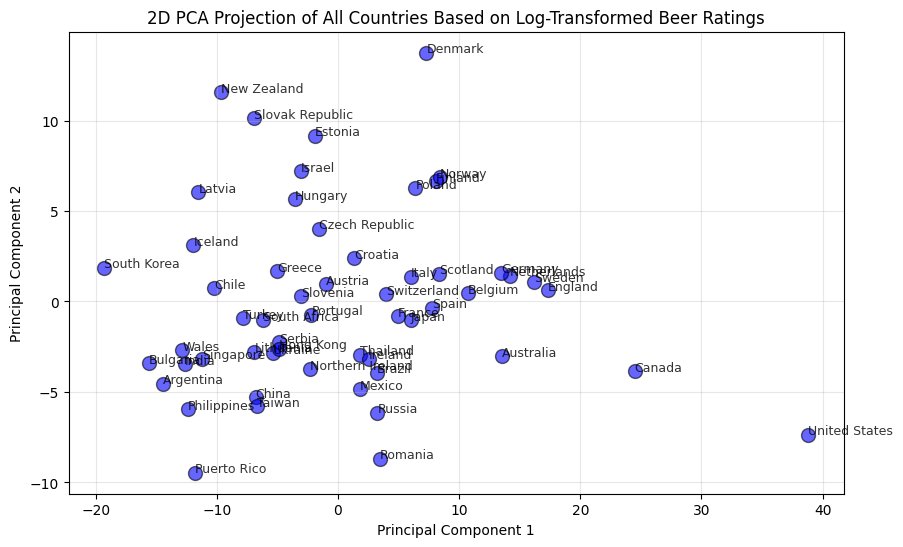

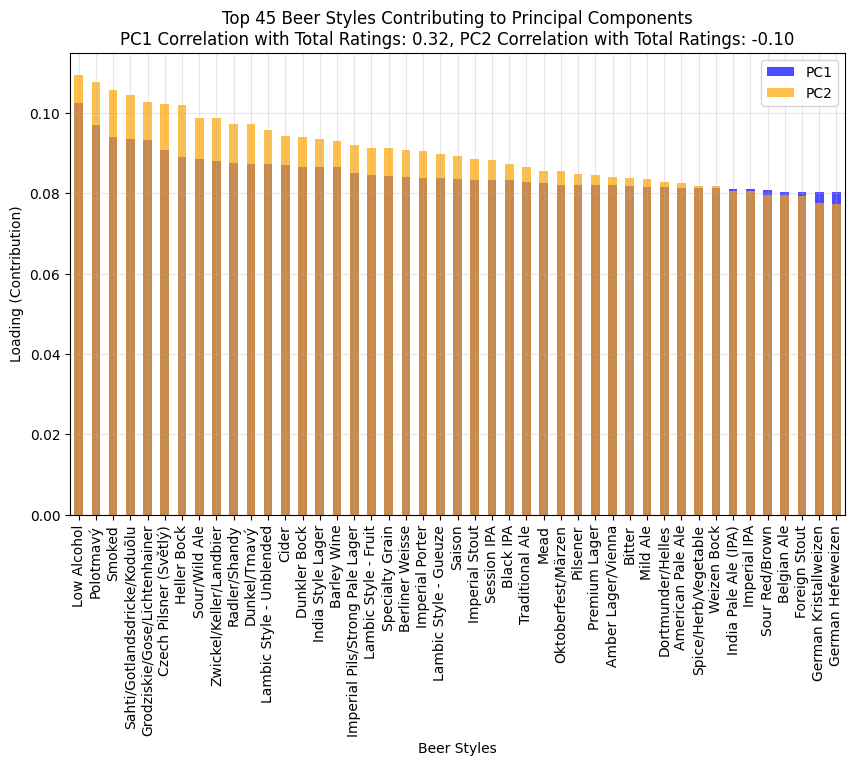

<Figure size 640x480 with 0 Axes>

In [79]:
reduced_to_3D = reduce_data_to_3D(merged_df_counts_avg_ratings)
pca_componentsss, loadingsss = plot_PCA_2D_with_loadings(reduced_to_3D,'2D PCA Projection of All Countries Based on Log-Transformed Beer Ratings')

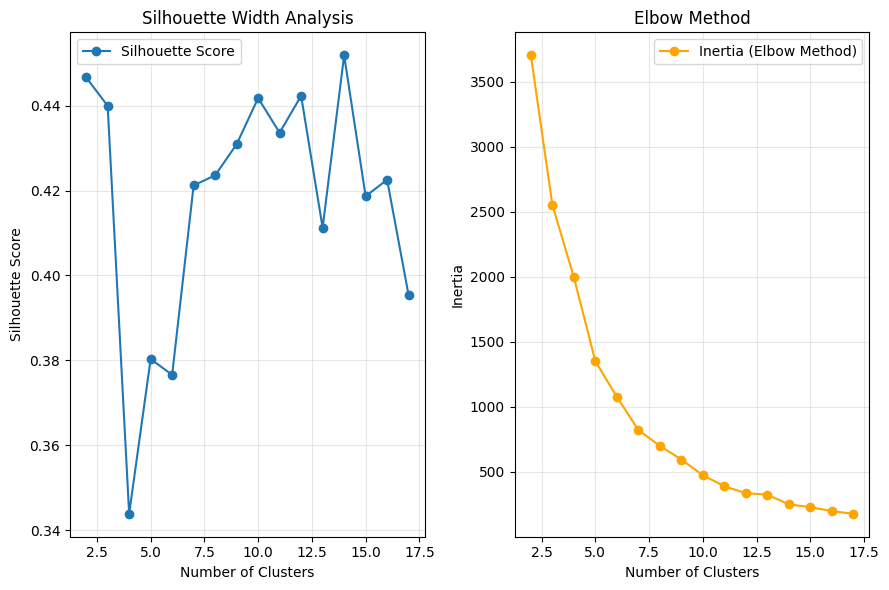

In [80]:
cluster_range1 = range(2,18)
silhoutte_inertia_plotting(cluster_range1,pca_componentsss) # Plotting Silhouette Width and Inertia Scores

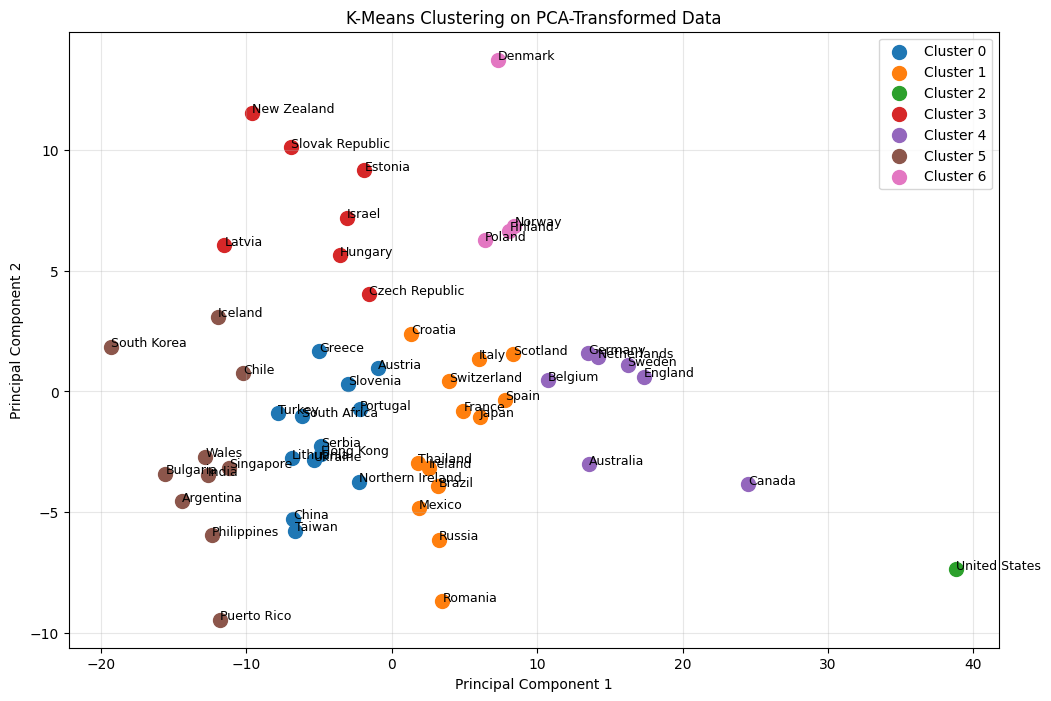

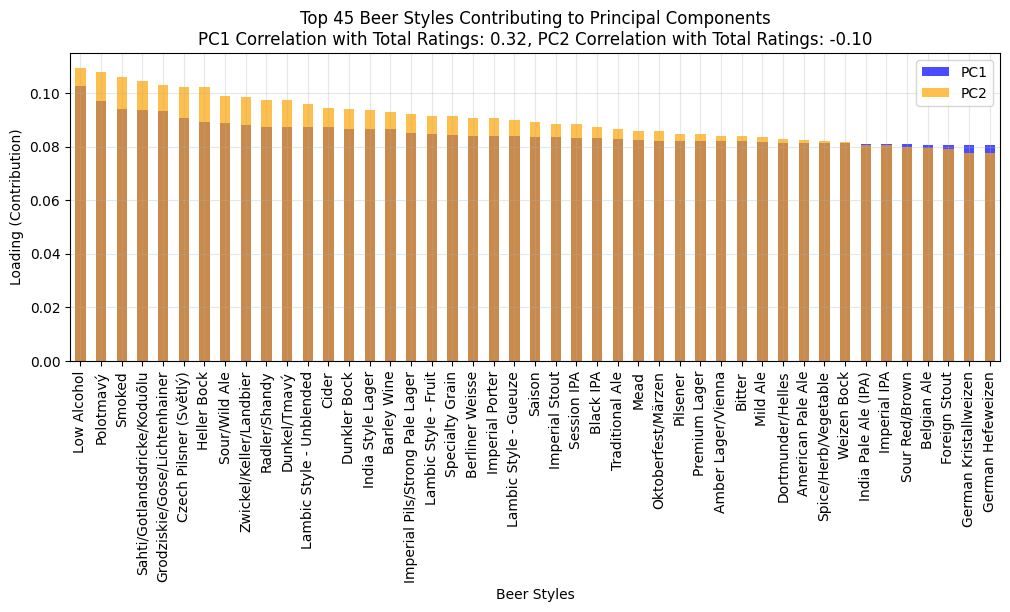

<Figure size 640x480 with 0 Axes>

In [81]:
# Extracting country names
country_names = list(reduced_to_3D.columns)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=7, random_state=42)  # Choose number of clusters
clusters = kmeans.fit_predict(pca_componentsss)

# Combine Clustering Results with Country Names
pca_transformed = pd.DataFrame(pca_componentsss, columns=["PC1", "PC2"])
pca_transformed['Cluster'] = clusters
pca_transformed['Country'] = country_names


plt.figure(figsize=(12, 8))
plot_clusters(pca_transformed) # Visualize the Clusters

# Calculate the correlation between the number of ratings and PCA loadings
total_ratings = reduced_to_3D.sum(axis=1)
loadingss['Total Ratings'] = total_ratings
pc1_corr = loadingsss[['PC1', 'Total Ratings']].corr().iloc[0, 1]
pc2_corr = loadingsss[['PC2', 'Total Ratings']].corr().iloc[0, 1]

plt.figure(figsize=(12, 4))
plot_pca_loadings(loadingsss,pc1_corr,pc2_corr)  # Plotting the PCA loadings

plt.tight_layout()
plt.show()

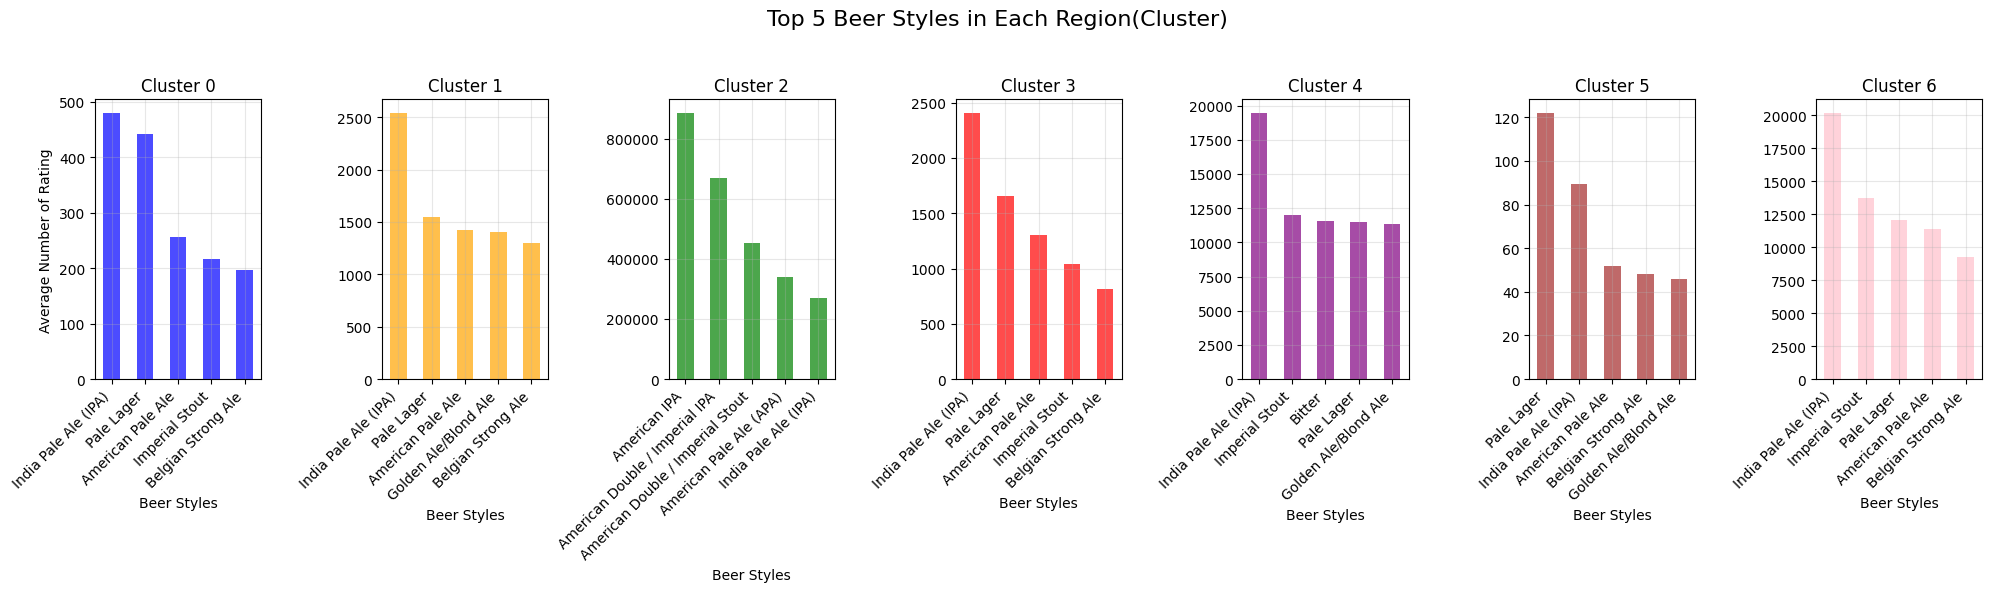

In [82]:
c,b= plot_regional_preferences(pca_transformed,subset_df_)

**We will also use the time information to determine if regional beer style preferences are stable (which would suggest that they are strongly affected by culture)or if they vary over**. Basically, we will use linear regression to see that beer style preferences are stable or not. To demonstrate that this is useful and feasible, we will analyze the some countries like U.S, Canada and England where we have enough data and the relatively same cultural habits to see time evolution of the ratings for the chosen beer styles.

In [83]:
data = total_ratings_loc_filtered[['style', 'user_location', 'rating','date']] # Choosing relavant columns
data.dropna(inplace=True) # Removing missing values

data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year  # Extract the year for trend analysis

agg_data = data.groupby(['user_location', 'style', 'year']).agg(   #Data by Year, Region, and Beer Style
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'size')   # Calculate the average rating per year, per region, and per beer style
).reset_index()

regions = ['United States', 'Canada', 'England']
styles = ['American IPA', 'Pale Lager']

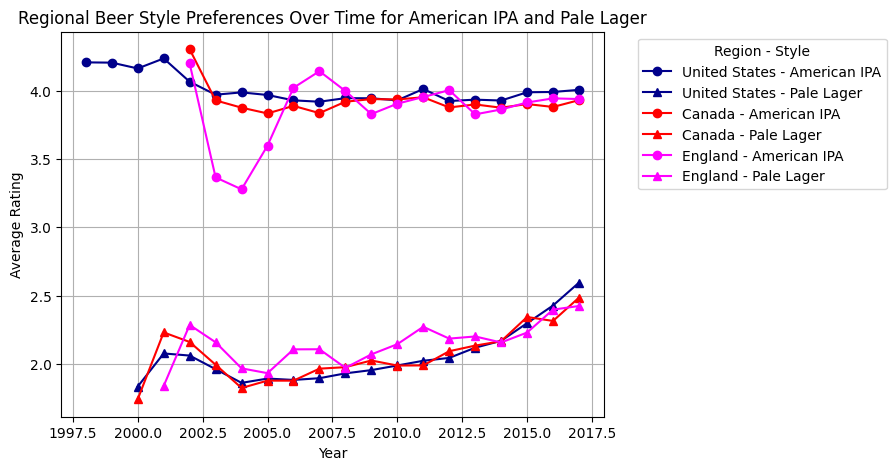

In [84]:
plot_over_time(agg_data,regions,styles)

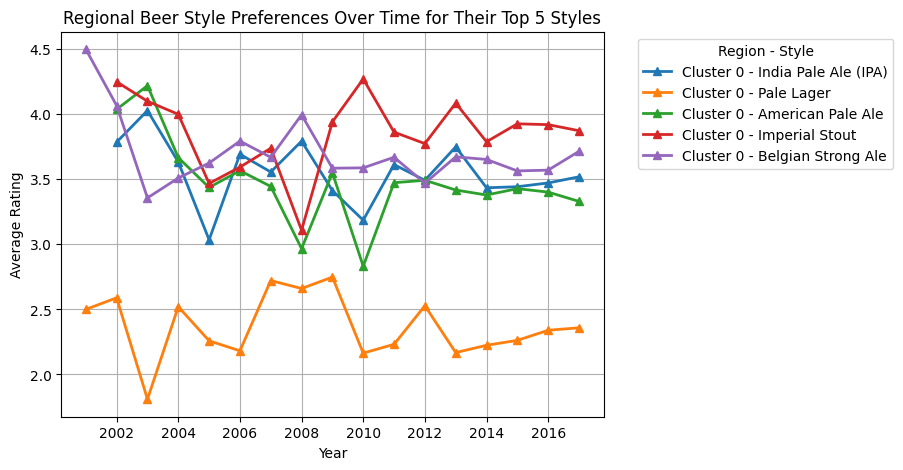

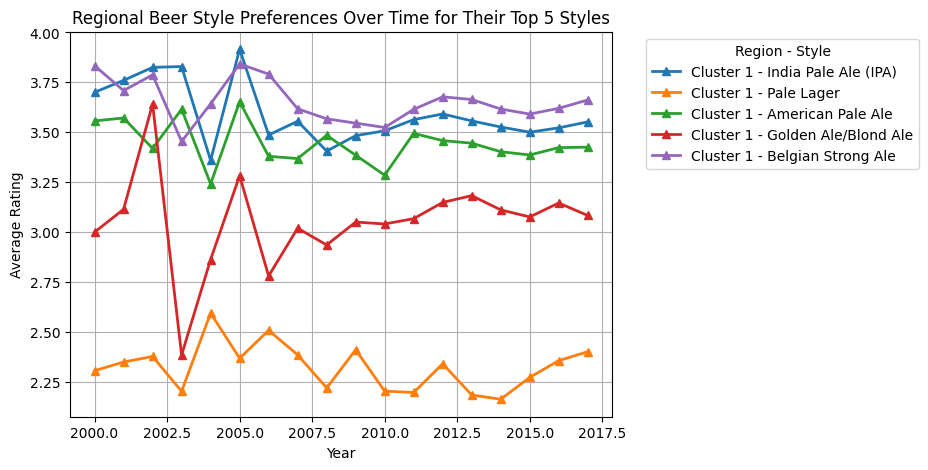

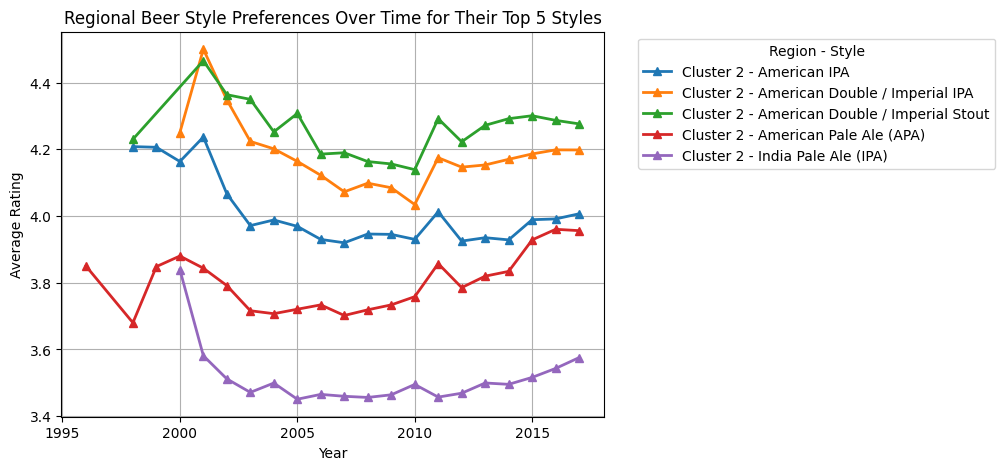

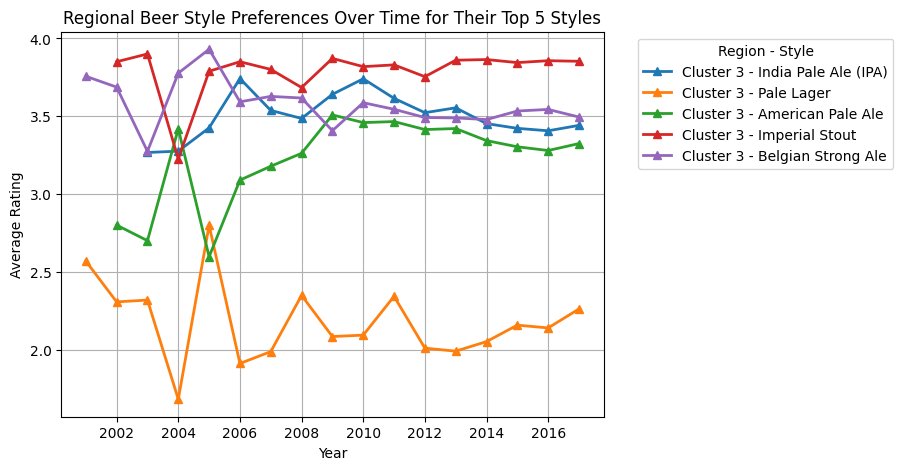

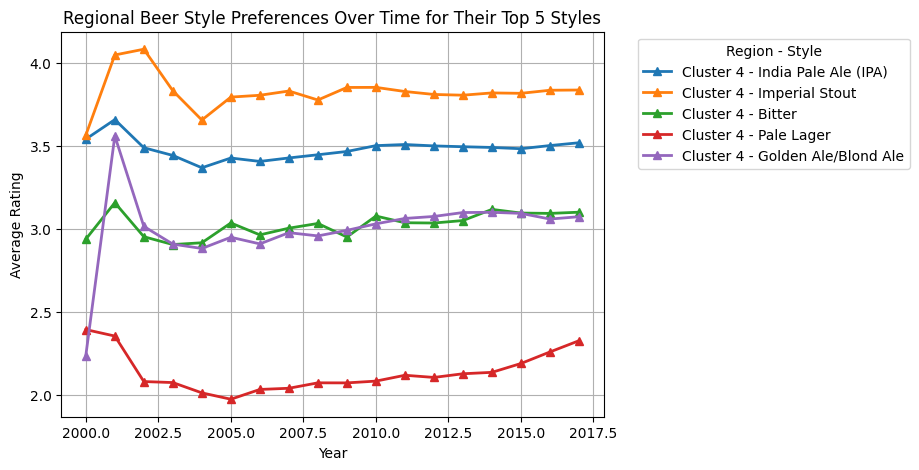

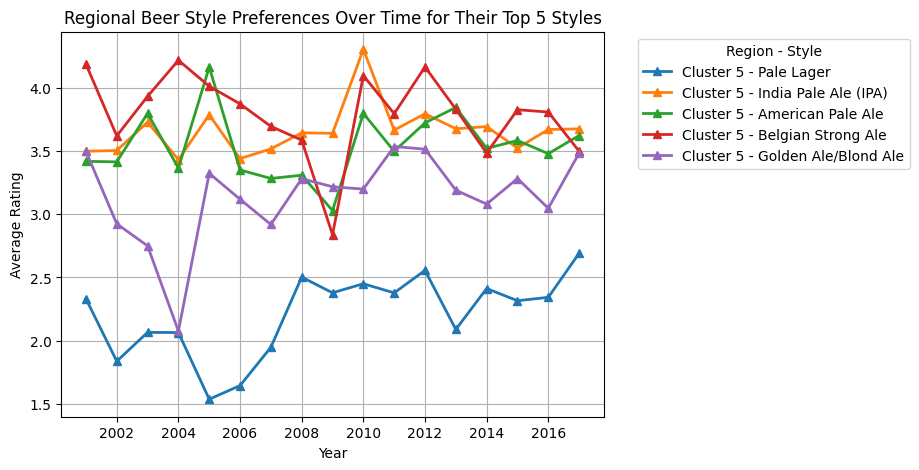

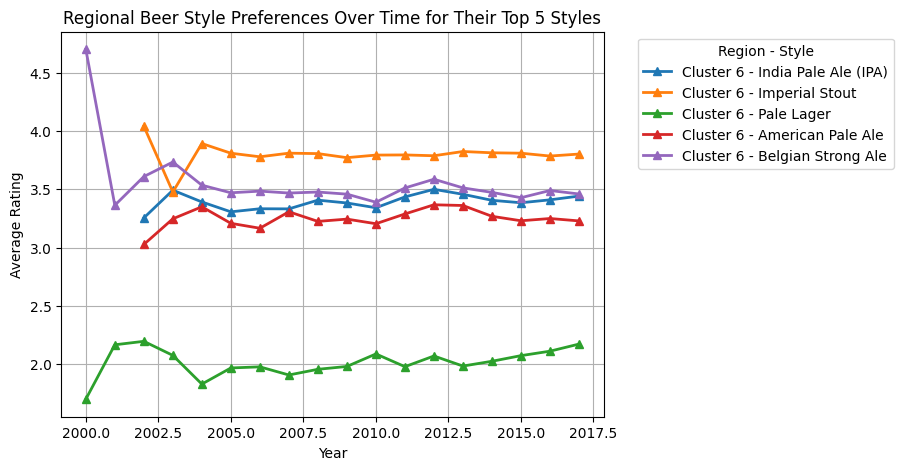

In [85]:
plot_top_styles_over_time(agg_data, clusters, pca_transformed,b,c)   

For the sake of simplicity of the plot, since trends are obvious, we will not plot the linear models. First of all, average ratings show that American IPA is more preferable than Pale Lager in these three chosen countries. Time evolution of the average ratings reveals that American IPA ratings remain relatively stable for these countries, suggesting a steady but not markedly increasing interest. Only in England, there is a significant deviation between the year 2000-2006. Interestingly, Pale Lager ratings in these three counts increase constantly over time. It suggests that there is a noticeable evolution in tastes over time, likely driven by global beer trends and expanding market availability, challenging the idea of stable, regionally bound beer preferences. *More importantly, these patterns reveals that certain preferences may be culturally rooted because trends are really close to each other in U.S, Canada and England.*

In [86]:
trends = agg_data.groupby(['user_location', 'style']).apply(calculate_trend).reset_index(name='trend')
filtered_agg_data = agg_data[              # Filter `agg_data` to include only the selected regions and beer styles
(agg_data['user_location'].isin(regions)) &
(agg_data['style'].isin(styles))]

trends = filtered_agg_data.groupby(['user_location', 'style']).apply(calculate_trend).reset_index(name='trend')

trends

user_location         style     trend
0         Canada  American IPA -0.007611
1         Canada    Pale Lager  0.023907
2        England  American IPA  0.016012
3        England    Pale Lager  0.021224
4  United States  American IPA -0.011967
5  United States    Pale Lager  0.028856

## b) Importance of specific beer attributes

We will now examine the importance of the different beer attributes in determining the final rating. 

To this aim, we will start by using linear regression with attribute ratings as features and the final rating as the outcome variable across all countries combined. We will then compare the coefficients of each attribute to evaluate their relative influence. After that, we will investigate how the importance of these attributes varies between countries by repeating this analysis separately for each country and examining the distribution of attribute coefficients across different countries.

For P2, we will start by exploring the attribute ratings data, and we will perform a linear regression analysis on both a country with little data and on a country with big data to assess the feasibility of the above analysis.

To perform these analyses, we will attribute ratings data. Thus, we will start by removing reviews lacking one or several attribute rating values.

In [87]:
attributes = ['appearance', 'aroma', 'palate', 'taste'] 
ba_ratings_no_missing_attributes= ba_ratings.dropna(subset= attributes )
rb_ratings_no_missing_attributes= rb_ratings.dropna(subset= attributes )
ba_ratings_loc_filtered_no_missing= ba_ratings_loc_filtered.dropna(subset= attributes )
rb_ratings_loc_filtered_no_missing = rb_ratings_loc_filtered.dropna(subset= attributes )
#rb_ratings_loc_filtered_no_missing.head()
rb_ratings_no_missing_attributes.head()

beer_name   beer_id brewery_name  brewery_id       style  abv  \
0    33 Export (Gabon)  410549.0      Sobraga      3198.0  Pale Lager  5.0   
1  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   
2  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   
3  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   
4  Castel Beer (Gabon)  105273.0      Sobraga      3198.0  Pale Lager  5.2   

                 date     user_name   user_id  appearance  aroma  palate  \
0 2016-04-26 10:00:00       Manslow  175852.0         2.0    4.0     2.0   
1 2017-02-17 11:00:00  MAGICuenca91  442761.0         2.0    3.0     2.0   
2 2016-06-24 10:00:00        Sibarh  288889.0         3.0    3.0     2.0   
3 2016-01-01 11:00:00       fombe89  250510.0         4.0    3.0     1.0   
4 2015-10-23 10:00:00    kevnic2008  122778.0         2.0    4.0     2.0   

   taste  overall  rating  user_avg_rating  brewery_avg_rating  \
0    4.0      8.0     2.0         2.941377            1.842105   
1    4.0      8.0     1.9         3.146914            1.842105   
2    3.0      5.0     1.6         2.019136            1.842105   
3    2.0      5.0     1.5         3.257624            1.842105   
4    4.0      7.0     1.9         2.703590            1.842105   

   style_avg_rating  
0          2.046774  
1          2.046774  
2          2.046774  
3          2.046774  
4          2.046774

We will now observe the distribution of each attribute ratings in the Beer Advocate and the Rate Beer datasets using histogram plots.

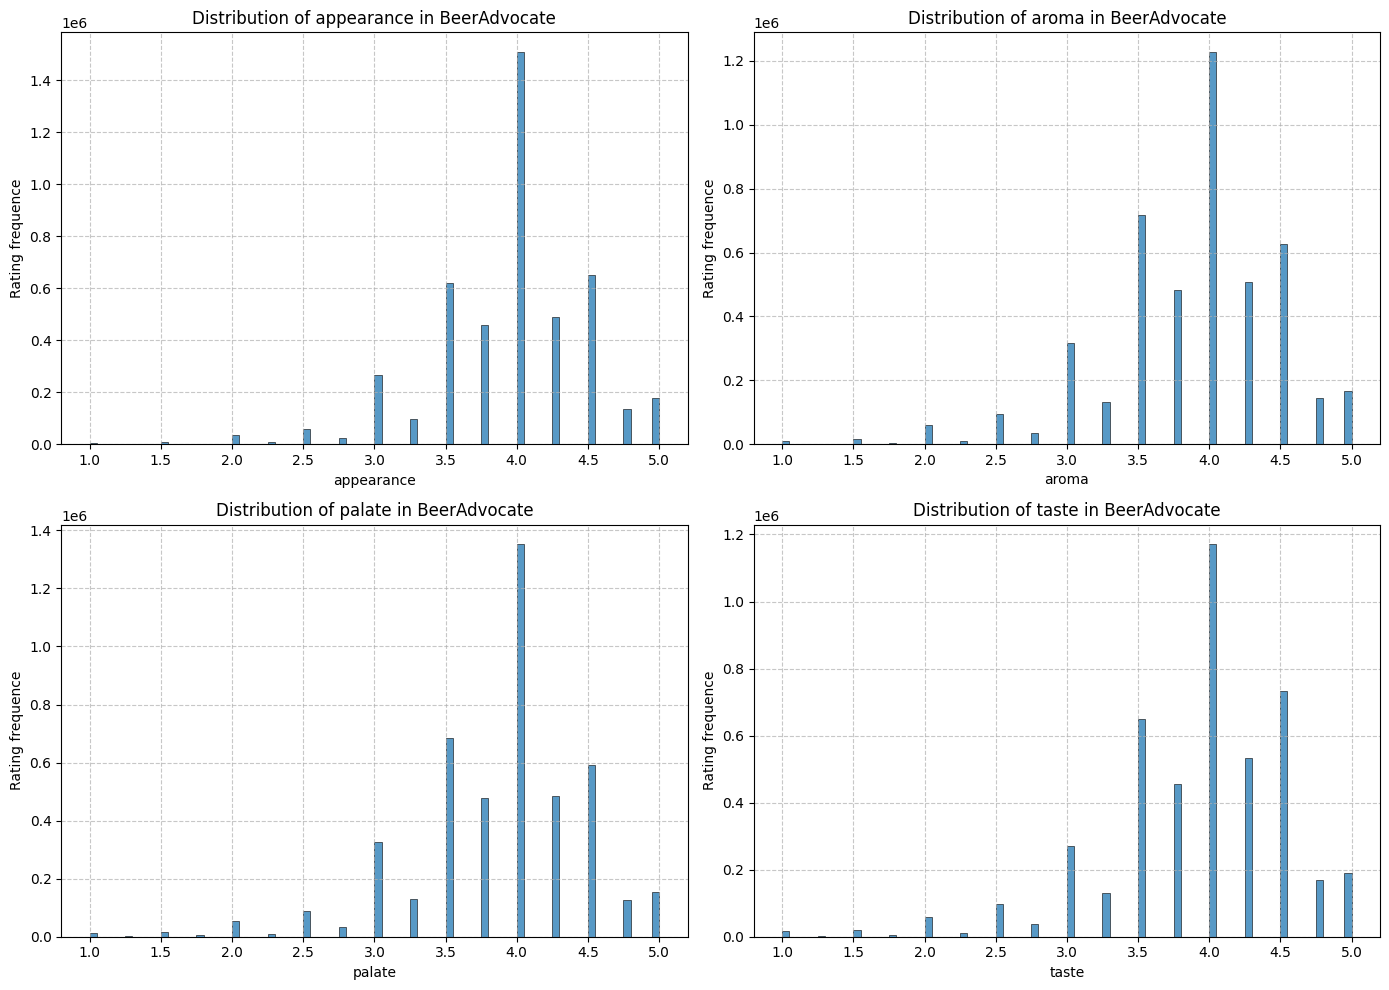

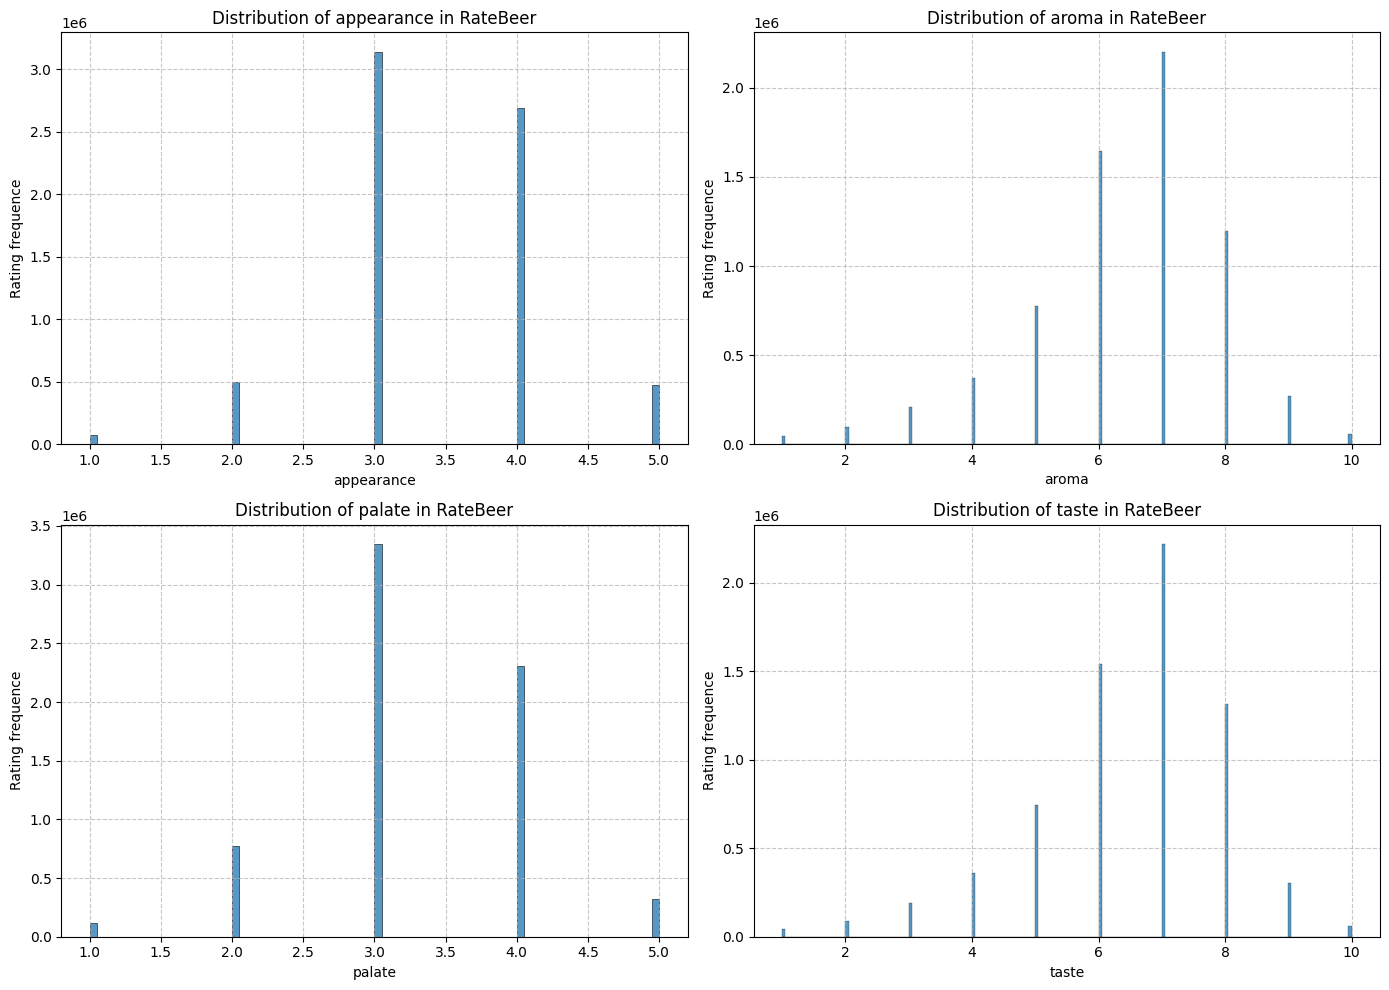

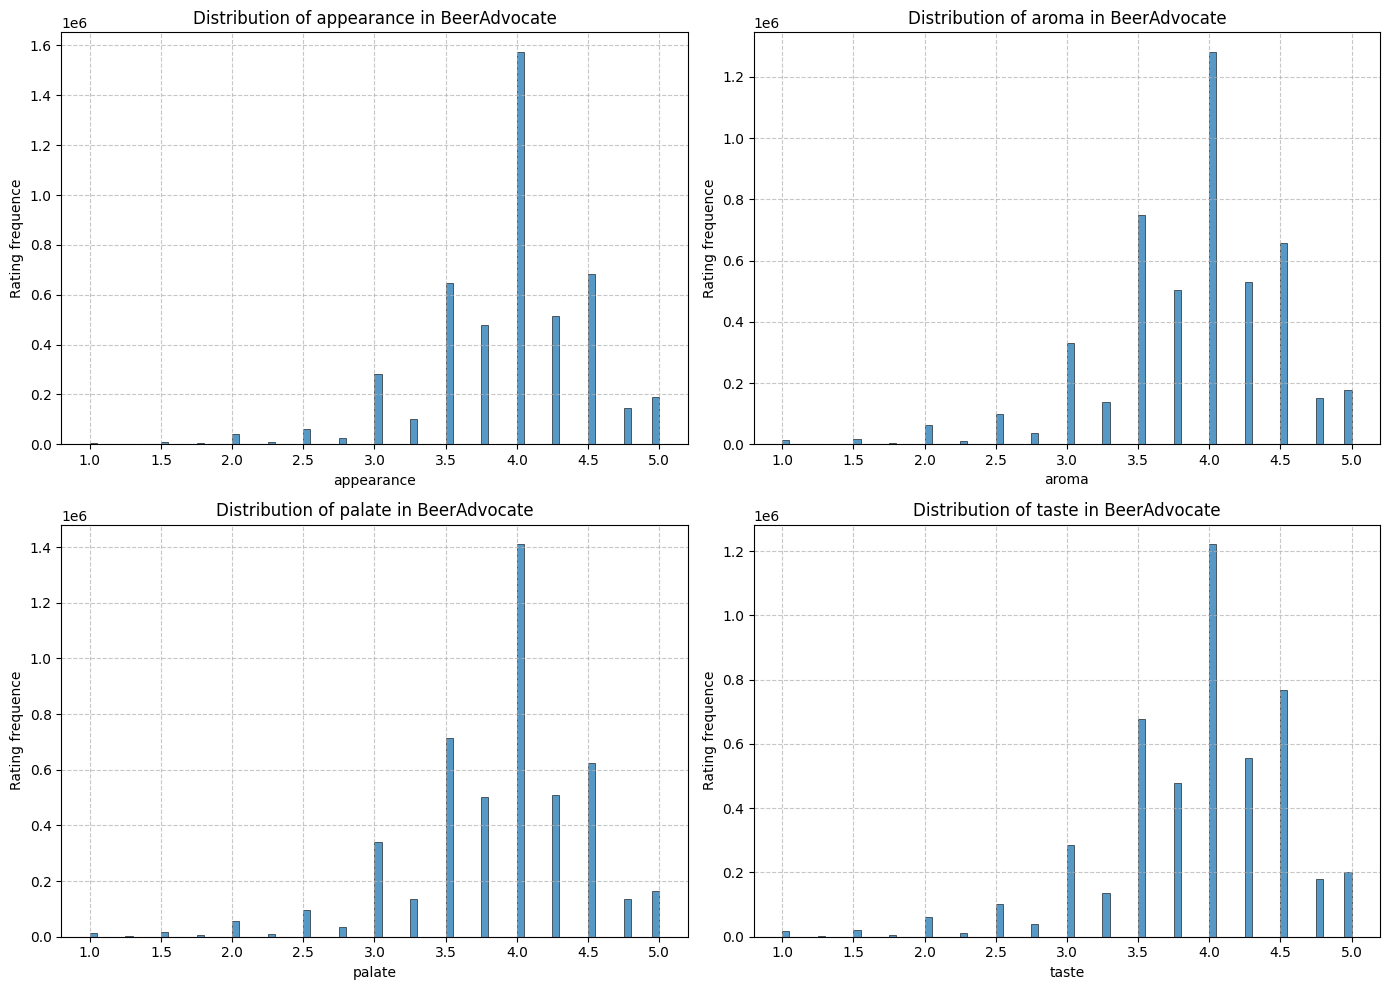

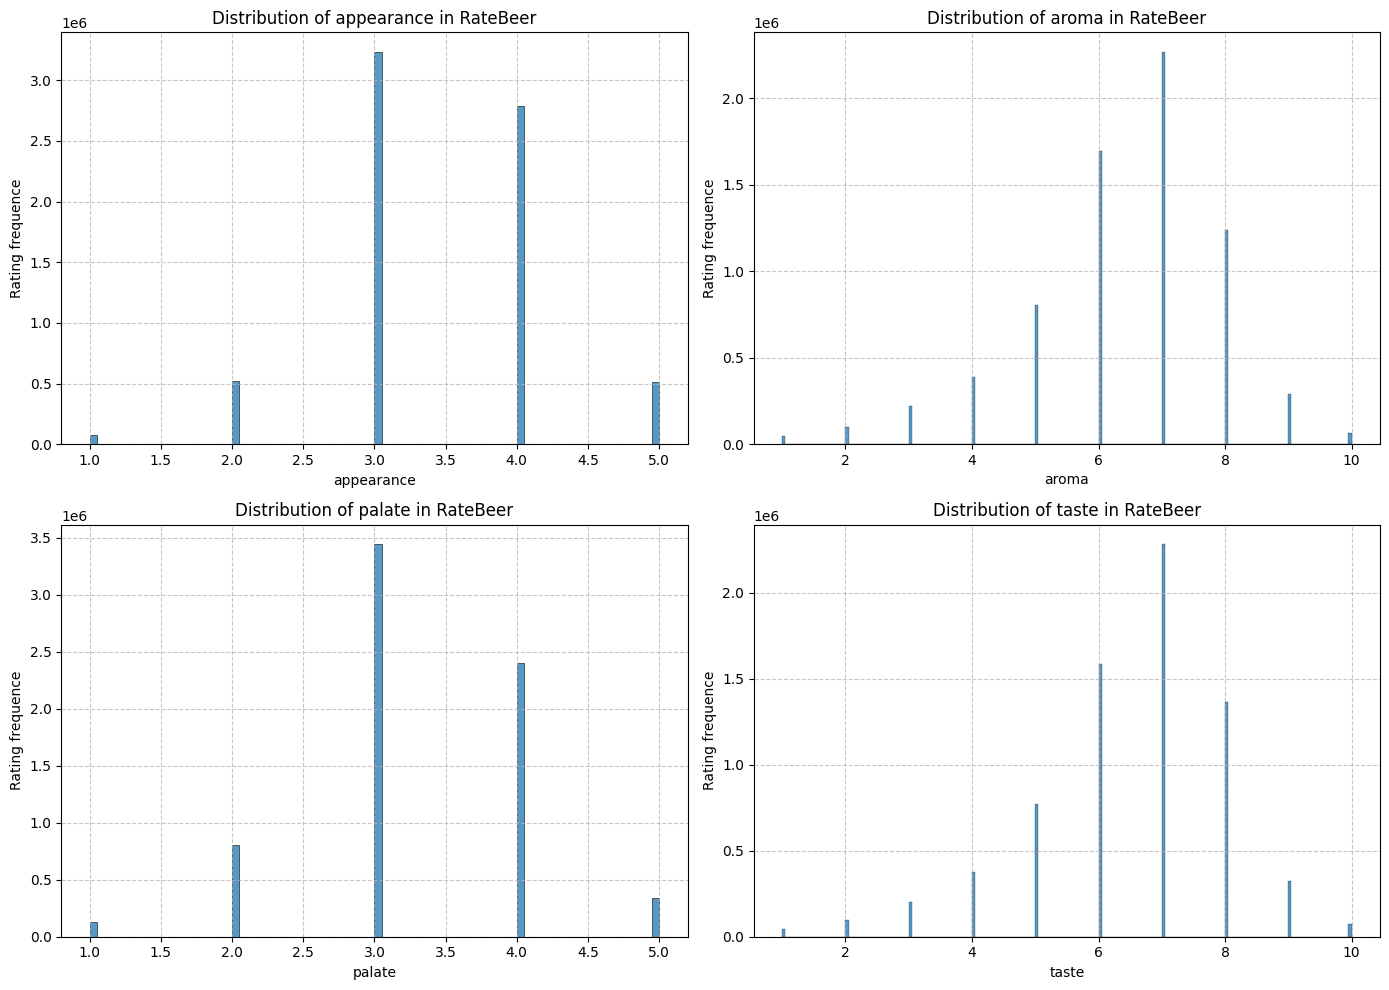

In [88]:
# Here we are plotting Beer Advocate data by creating histogram sublplots for each beer attribute.
# We are using histplot function of seaborn python library. We set the function to our preferences for a better visualization



plot_hist(attributes,ba_ratings_loc_filtered_no_missing,'BeerAdvocate')     
plot_hist(attributes,rb_ratings_loc_filtered_no_missing,'RateBeer') # Here we are doing the same  plotting for Rate Beer data
plot_hist(attributes,ba_ratings_no_missing_attributes,'BeerAdvocate')     
plot_hist(attributes,rb_ratings_no_missing_attributes,'RateBeer')
plt.close()

Here we are looking at the general distribution of the beer atributes to get a gist of the ratings to differentiate between each attribute and what are the differences between the databases. Here we can see that the ratings in the Rate Beer are more harsh compared to the Beer Advocate and they are generally lower.Also to note the rating syszem of Rate Beer seems to more strict only allowing 0.5 increments while the Beer Advocate ratings can be more precise. We see that the taste and aroma ratings are given out of ten in Rate Beer , This can cause to some problems while concanating and doing correlation analysis.So we need to scale them

In [89]:
rb_ratings_loc_filtered_no_missing['taste'] = rb_ratings_loc_filtered_no_missing['taste'] / 2
rb_ratings_loc_filtered_no_missing['aroma'] = rb_ratings_loc_filtered_no_missing['aroma'] / 2
rb_ratings_no_missing_attributes['taste'] = rb_ratings_no_missing_attributes['taste'] / 2
rb_ratings_no_missing_attributes['aroma'] = rb_ratings_no_missing_attributes['aroma'] / 2

Here we scaled the Rate Beer's taste and aroma beer attributes accordingly to the other attributes' rating scale so that we have a common scale. ( 5 point rating scale)

In [90]:
#We merge the datas vertically and drop their previous index values while adding their source dataset information,
total_ratings_loc_filtered_no_missing = pd.concat([ba_ratings_loc_filtered_no_missing, rb_ratings_loc_filtered_no_missing], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_loc_filtered_no_missing = total_ratings_loc_filtered_no_missing.reset_index(drop=True)
total_ratings_loc_filtered_no_missing.head()
total_ratings_no_missing_attributes= pd.concat([ba_ratings_no_missing_attributes, rb_ratings_no_missing_attributes], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_no_missing_attributes = total_ratings_no_missing_attributes.reset_index(drop=True)


In [91]:
total_ratings_no_missing_attributes.sample(n=6)

source                             beer_name   beer_id  \
5179632      rb                            Deusa Ísis  216011.0   
2947868      ba         The Sixth Glass Quadrupel Ale   39621.0   
8995861      rb       Yuengling Lord Chesterfield Ale     886.0   
4305280      ba                               Matilda    4318.0   
10845156     rb        Samuel Smiths Yorkshire Stingo   90838.0   
2035373      ba  Evil Twin Ryan And The Beaster Bunny   71742.0   

                       brewery_name  brewery_id                    style  \
5179632   Deusa - Cerveja Artesanal     16880.0        German Hefeweizen   
2947868       Boulevard Brewing Co.       423.0         Quadrupel (Quad)   
8995861           Yuengling Brewery       144.0     Golden Ale/Blond Ale   
4305280       Goose Island Beer Co.      1146.0  Belgian Strong Pale Ale   
10845156               Samuel Smith        17.0       English Strong Ale   
2035373           Evil Twin Brewing     24300.0   Saison / Farmhouse Ale   

           abv                date    user_name             user_id  \
5179632    5.0 2013-09-26 10:00:00    teddybeer             48017.0   
2947868   10.5 2015-09-12 10:00:00        Qbdoo        qbdoo.751737   
8995861    5.6 2007-04-11 10:00:00       cjw163             23618.0   
4305280    7.0 2015-01-01 11:00:00  Boulder5620  boulder5620.808109   
10845156   9.0 2014-10-17 10:00:00      aumentm            200039.0   
2035373    7.0 2016-01-31 11:00:00      dcmchew      dcmchew.760280   

          appearance  aroma  palate  taste  overall  rating  user_avg_rating  \
5179632         3.00   3.00    3.00   3.50     16.0    3.50         3.178993   
2947868         4.00   3.75    3.75   3.75      3.5    3.72         3.933621   
8995861         4.00   2.00    3.00   3.00     11.0    2.80         2.967442   
4305280         3.75   3.75    4.50   4.00      4.0    3.98         3.872857   
10845156        4.00   4.00    4.00   4.00     14.0    3.80         3.520497   
2035373         4.25   4.00    3.75   4.00      4.0    3.99         3.776202   

          brewery_avg_rating  style_avg_rating  
5179632             3.004000          3.164008  
2947868             3.974558          4.199219  
8995861             2.798684          3.029469  
4305280             4.119945          3.937418  
10845156            3.520550          3.301000  
2035373             4.060546          3.951112

This data frame will be the main data frame for linear regression analysis as it will allow us to analyse the total ratings

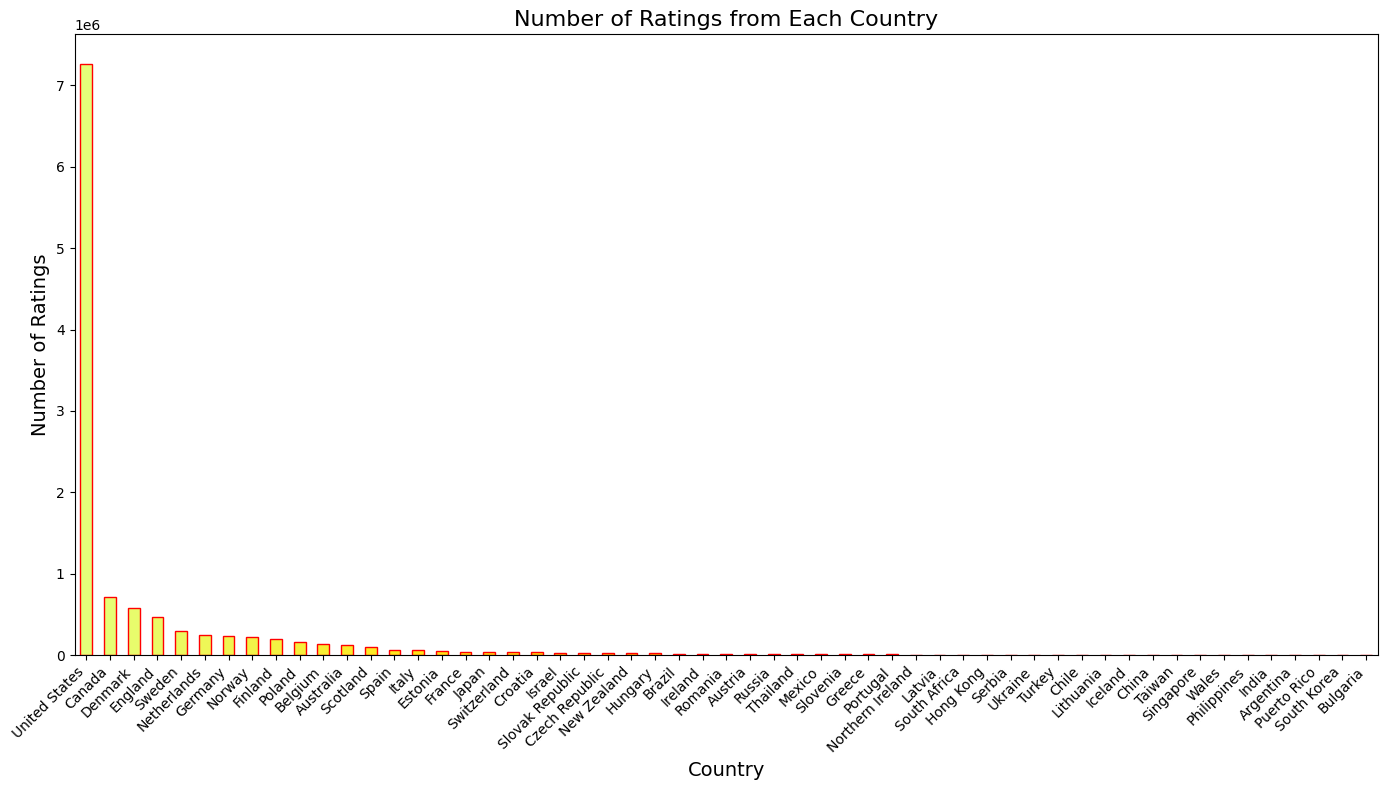

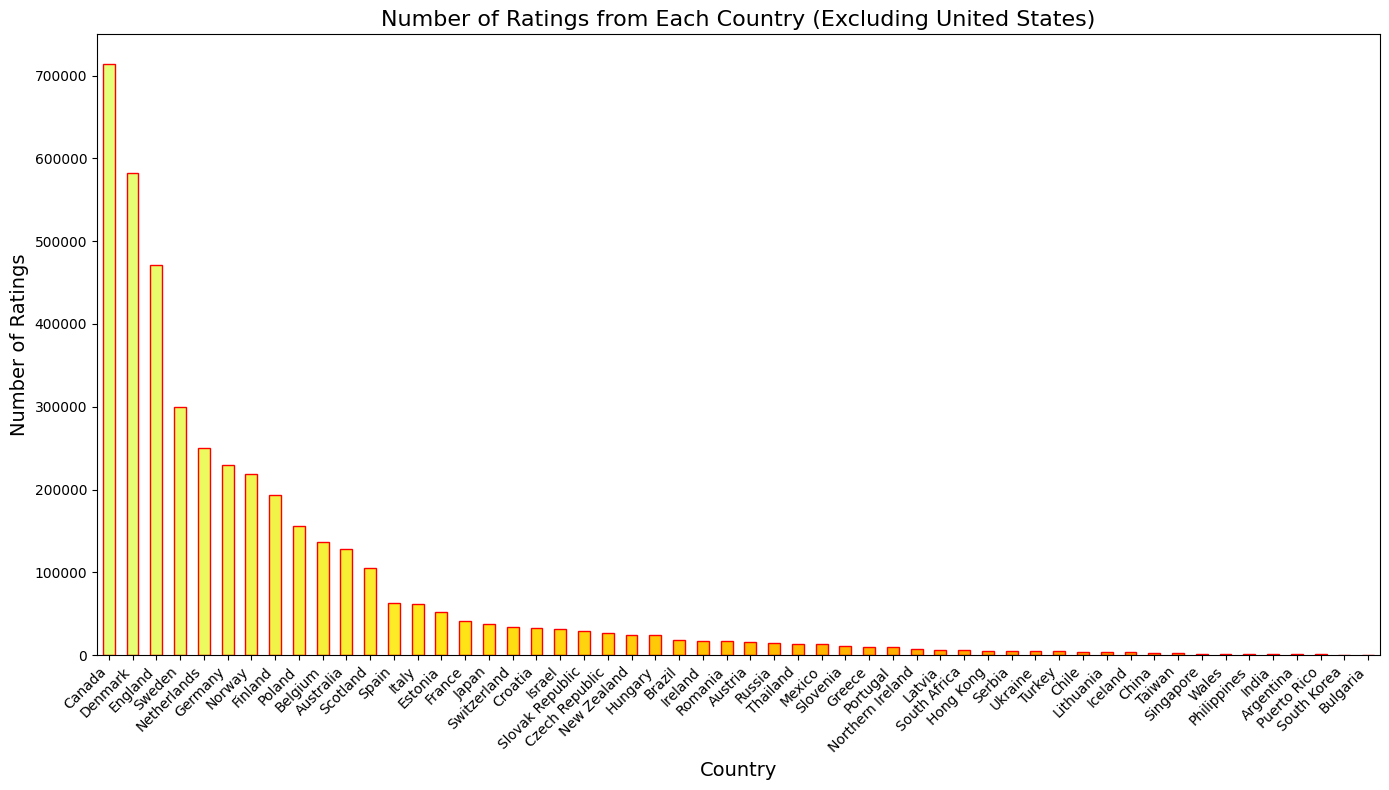

In [92]:
#Here we are creating bar plots for countries too see how much ratings are done from that specific country.
#We are using color gradient to our preference.
#We are doing more than more plots because USA has to many ratings and distrupts the flow of the plot
country_counts = total_ratings_loc_filtered_no_missing['user_location'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, len(country_counts)))
plt.figure(figsize=(14, 8))
country_counts.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Ratings from Each Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  
plt.show()

usa_filtered_ratings = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] != 'United States']

country_counts_without_usa= usa_filtered_ratings['user_location'].value_counts()

colors = plt.cm.Wistia(np.linspace(0, 1, len(country_counts)))

plt.figure(figsize=(14, 8))
country_counts_without_usa.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Ratings from Each Country (Excluding United States)", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
plt.close()

Here we wanted to see how many ratings are coming from each country and plotted it by histograms to visualize it. We have two plots of histogram one with United States and one without it.This is because United States has much more ratings data compared to other countries so the histogram plots becomes a little bit skewed, so to get a better look at other countries contribution we made another plot without USA. 

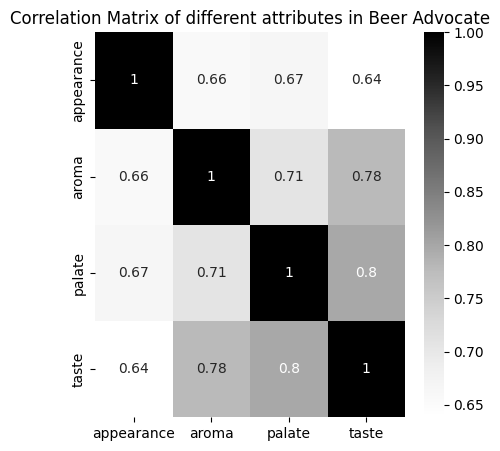

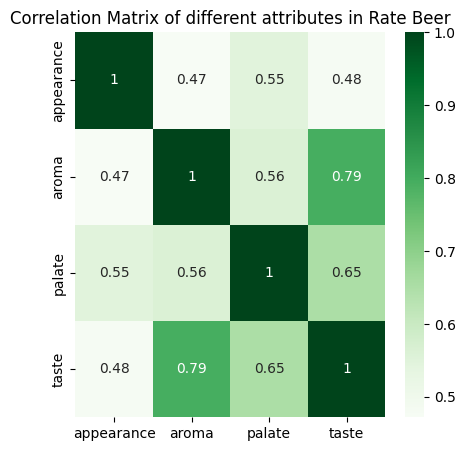

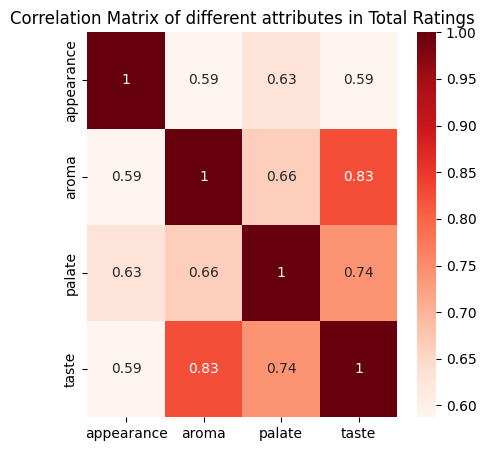

In [93]:
# We will try to see and compare how each attributes correlates between each other
# Best way to visualize this to create heat maps.We are creating heatmaps for each data set because this way
# we can see the changement of the correlation between the attributes better when we merge the two dataframe.
correlation_matrix_1 = ba_ratings_loc_filtered_no_missing[attributes].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_1, annot=True, cmap="Greys")
plt.title("Correlation Matrix of different attributes in Beer Advocate")

correlation_matrix_2 = rb_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_2, annot=True, cmap="Greens")
plt.title("Correlation Matrix of different attributes in Rate Beer")

correlation_matrix_total = total_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_total, annot=True, cmap="Reds")
plt.title("Correlation Matrix of different attributes in Total Ratings")
plt.show()
plt.close()

Here we see the correlation matrix of each data frame, including the total ratings which is created by the concatanation of Rate Beer and Beer Advocate data frames. This matrix plot gives us a good information about the correalation between beer attributes and how the ratings differentiate between the data frames. We can see that in the Beer Advocate data frame taste aroma and palate attributes have a high correlation between each other while appearance also correlating to them but not as high. In the Rate Beer data frame we see that aroma and taste correlates more between each other then with palate.Palate still correlates with them but not as strong as it was in Beer Advocate. The suprising finding here is that in the total ratings data frame, the combination of the two data frames gives us a stronger correlation between aroma and taste.These differences of correlation across each data frame indicate to us that the user profile of the two platforms might  have a distinct look on the attributes and their contribution to elavate each other.The appereance seems to be more unique when compared to other attributes since its correlation values considerably moderate accross each dataset. High correlation numbers between the attributes (especially the aroma and taste attributes) can be a sign of multicolineratiy which is important to take into account while doing the linear regression analyses.

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 4.508e+07
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:49:22   Log-Likelihood:             5.6659e+06
No. Observations:             8324222   AIC:                        -1.133e+07
Df Residuals:                 8324215   BIC:                        -1.133e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5296   4.25e-05   8.31e+04      0.0

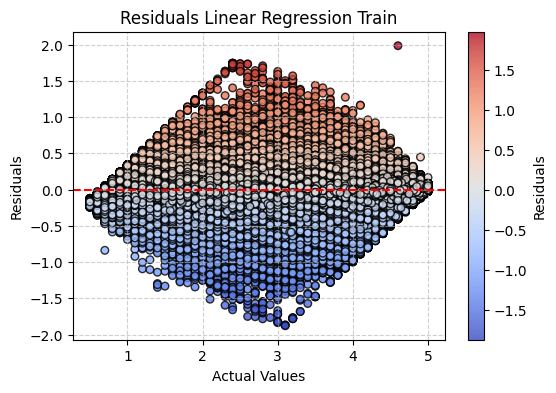

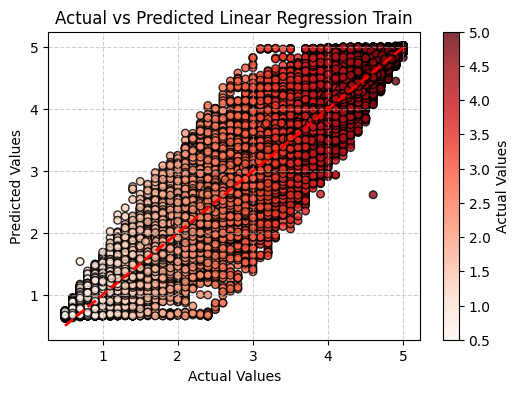

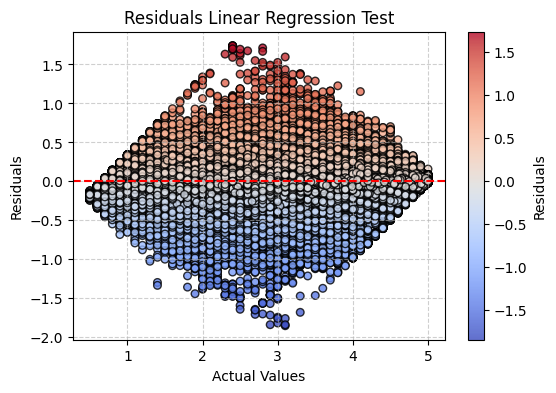

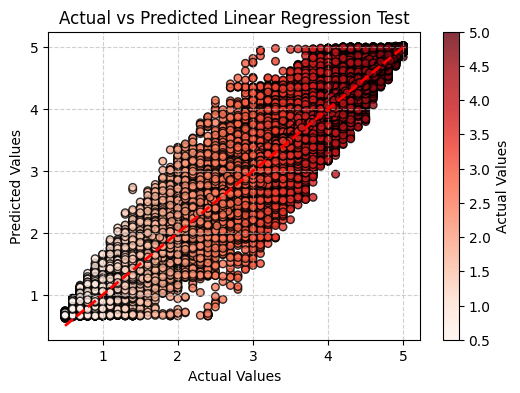

In [94]:
columns_to_drop_total = [
    'source', 'beer_id', 'beer_name', 'brewery_name', 'brewery_id', 
    'abv', 'date', 'user_name', 'user_id', 'overall', 
    'style','user_avg_rating'
]
total_ratings_no_missing_attributes= total_ratings_no_missing_attributes.drop(columns = columns_to_drop_total)
total_ratings_final= total_ratings_no_missing_attributes.dropna()

X = total_ratings_final.drop(['rating'], axis=1)
y = total_ratings_final['rating']
results, summary = advanced_linear_regression(X, y,make_plots = True,print_summary= True)
linear_coefficients = summary.params


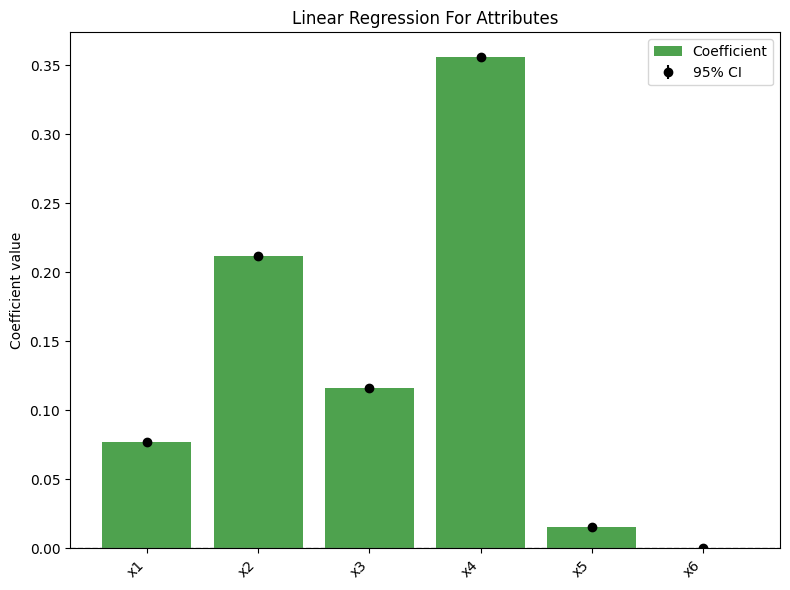

const    3.529552
x1       0.076918
x2       0.211517
x3       0.116440
x4       0.355988
x5       0.015747
x6       0.000350
dtype: float64

In [95]:
linear_coeff_int = summary.conf_int()
plot_coefficients(linear_coefficients, linear_coeff_int, 'Linear Regression For Attributes', 'forestgreen', ci_color='black')
display(linear_coefficients)

The linear regression analysis on the total dataset shows us  that the model provides nearly perfect fit to the data, since  the R squared values for both the training and testing data is 0.97 which is very high. These values indicate that 97% of the variance in the final beer ratings can be explained by the selected independent variables, which are the beer attributes (appearance, aroma, palate, and taste) as well as confounder variables such as brewery_avg_rating and style_avg_rating. The high F-statistic and its associated p-value which is close to zero further confirm the statistical significance of the model. In addition the mean squared error (MSE) values for both training and testing proves that the linear model generalises the data well and does not show any signs of underfitting or overfitting and their low results shows that the model's predictions are adequate.
The coefficients of the regression shows us the relative importance of different beer attributes and confounder variables:
Taste (x4) is the most influential variable for the predicton, with a coefficient of 0.356, this means that  it is the most dominant attribute in shaping beer ratings.
Aroma (x2) follows as the second most important attribute, with a coefficient of 0.2115. This indicates that aroma plays a significant role but it is not as impactful as taste.
Palate and Appearance (x3 and x1) have smaller but still statistically significant positive effects on ratings, with coefficients of 0.1164 and 0.0769, respectively.
Brewery reputation (x5) has a small but noticeable positive influence (coefficient = 0.0157 which is in the same decimal as the appearance), suggesting that the brewery’s established reputation subtly affects individual beer ratings while beer style (x6) has a very small coefficient of 0.0003 marking that it has a  very minimal effect. As a concluison on the cofounders affect we can say that the inclusion of brewery reputation helped us to see that even though it is small the users might get influenced by it (either by having trust to the known breweries or having a bias against them) while the effect of the beer style is negliable.
The residual plots for both the training and test datasets shows us  that the residuals are symmetrically distributed around zero which is good because it means no systematic bias in the model predictions. However, there are few outliers in the rating ranges of 1–2 and 4–5 but their number is very small compared to the rest of the data.
The actual vs predicted plots for both the training and test datasets show a strong alignment of the data along the y = x line, indicating high predictive accuracy. The clustering of data points near this line confirms the model’s ability to show the relationships between predictors and the target variable effectively.

Finally , the linear regression model provides solid informations about the factors influencing beer ratings, as expected the most important attribute in user ratings is the taste of the beer. Hovewer as we have seen in the heatmaps of correlation matrix there might be some multicolinearity, we will adress this by using Lasso and Ridge regularization techniques.



In [96]:
results, model = advanced_linear_regression(X, y,'lasso',make_plots = False)
lasso_coefficients = model.coef_ 
print("Coefficients for Lasso Regularization:", lasso_coefficients)


Optimal alpha for Lasso: 0.0001
Training MSE: 0.015007997019197205 Training R2: 0.9701429398072418 Training Pearson Correlation: 0.9849583534654256
Testing MSE: 0.014995362576033821 Testing R2: 0.9701478481369907 Testing Pearson Correlation: 0.9849608738764266
Coefficients for Lasso Regularization: [7.68872505e-02 2.11589358e-01 1.16415803e-01 3.55931089e-01
 1.56955977e-02 3.06469110e-04]


In [97]:
results, model = advanced_linear_regression(X, y,'ridge',make_plots = False)
ridge_coefficients = model.coef_  # For Ridge Regression
print("Coefficients for Ridge Regularization:", ridge_coefficients)


Optimal alpha for Ridge: 3.351602650938848
Training MSE: 0.015007982448071952 Training R2: 0.9701429687951849 Training Pearson Correlation: 0.9849583589143293
Testing MSE: 0.01499535391362482 Testing R2: 0.9701478653817588 Testing Pearson Correlation: 0.9849608548141998
Coefficients for Ridge Regularization: [7.69182721e-02 2.11517379e-01 1.16440070e-01 3.55987317e-01
 1.57467727e-02 3.49876936e-04]


In [98]:
attributes_ = ["Appearance (x1)", "Aroma (x2)", "Palate (x3)", "Taste (x4)", "Brewery Avg. Rating (x5)", "Beer Avg. Rating (x6)"]
linear_coefficients_ = linear_coefficients[1:]
# Create the table
coefficient_table = pd.DataFrame({
    "Attribute": attributes_,
    "Linear Regression": linear_coefficients_,
    "Lasso Regression": lasso_coefficients,
    "Ridge Regression": ridge_coefficients
})
display(coefficient_table)

Attribute  Linear Regression  Lasso Regression  \
x1           Appearance (x1)           0.076918          0.076887   
x2                Aroma (x2)           0.211517          0.211589   
x3               Palate (x3)           0.116440          0.116416   
x4                Taste (x4)           0.355988          0.355931   
x5  Brewery Avg. Rating (x5)           0.015747          0.015696   
x6     Beer Avg. Rating (x6)           0.000350          0.000306   

    Ridge Regression  
x1          0.076918  
x2          0.211517  
x3          0.116440  
x4          0.355987  
x5          0.015747  
x6          0.000350


We applied Lasso and Ridge regularization techniques to the dataset to investigate potential multicollinearity among the predictor variables.These methods enhance the standard linear regression model by introducing penalties to the coefficients, helping to manage both multicollinearity and overfitting. The results of these analyses indicate that multicollinearity is not a significant issue in the dataset
As we can see from the table, results across normal linear regression, lasso, and ridge are very close as all methods produced nearly identical coefficients(identical in case of ridge and normal linear regression). This consistency is a strong indication that multicollinearity is not affecting the dataset. If multicollinearity was present, lasso regularization would have significantly shrunk or eliminated certain coefficients, and ridge regularization would have redistributed the variance among correlated predictors which would affect noticeable changes to the coefficients.

In conclusion, the results of lasso and ridge regularizations acts as an evidence that multicollinearity is not a concern in this dataset. These analyses again shows us  the reliability of the linear regression model and the stability of the coefficients given to the attributes 

In [99]:
# Dictionary to store coefficients
country_coefficients = {}
columns_to_drop_usa = [
    'source', 'beer_id', 'beer_name', 'brewery_name', 'brewery_id', 
    'abv', 'date', 'user_name', 'user_id', 'overall', 
    'user_location', 'brewery_location','style','user_avg_rating'
]
columns_to_drop_im = [
    'source', 'beer_id', 'beer_name', 'brewery_name', 'brewery_id', 
    'abv', 'date', 'user_name', 'user_id', 'overall', 'rating', 
    'user_location', 'brewery_location','style','user_avg_rating'
]
# Loop through each unique country

for country in total_ratings_loc_filtered_no_missing['user_location'].unique():
    # Filter the data for the current country
    country_data = total_ratings_loc_filtered_no_missing[
        total_ratings_loc_filtered_no_missing['user_location'] == country
    ]
    if country == 'United States':
        country_data=country_data.drop(columns=columns_to_drop_usa)
        country_data=country_data.dropna()
        X = country_data.drop(['rating'], axis=1)
        y = country_data['rating']
    else:       
        # Prepare independent variables (X) and dependent variable (y)
        X = country_data.drop(columns=columns_to_drop_im)
        y = country_data['rating']
    
    try:
        # Call the advanced_linear_regression function
        metrics, model = advanced_linear_regression(X, y,make_plots = False,print_summary=False)
        
        # Extract coefficients from the model object
        coeff_dict = dict(zip(model.params.index, model.params.values))
        coeff_dict.pop('const', None)  # Remove constant term if unnecessary

        # Store coefficients for this country
        country_coefficients[country] = coeff_dict
    
    except Exception as e:
        print(f"Error processing {country}: {e}")

# Convert coefficients dictionary to a DataFrame for analysis
country_coefficients = pd.DataFrame.from_dict(country_coefficients, orient='index')
country_coefficients.reset_index(inplace=True)
country_coefficients.rename(columns={'index': 'country'}, inplace=True)

# Display the coefficients DataFrame
display(country_coefficients)


country        x1        x2        x3        x4        x5  \
0      United States  0.069324  0.196384  0.110044  0.349987  0.010270   
1   Northern Ireland  0.048822  0.196598  0.089152  0.313611  0.012293   
2            England  0.073628  0.184183  0.115414  0.290352  0.018013   
3            Ireland  0.081270  0.203428  0.143090  0.308020  0.020463   
4             Serbia  0.101543  0.220269  0.099313  0.292541  0.035247   
5              Spain  0.074970  0.207916  0.128023  0.352307  0.034026   
6            Romania  0.062120  0.191052  0.088288  0.285457  0.011309   
7          Australia  0.094590  0.239804  0.128499  0.378048  0.014398   
8             Canada  0.083802  0.211214  0.119645  0.334925  0.014901   
9            Austria  0.067214  0.200951  0.104488  0.270755  0.015274   
10       Switzerland  0.091945  0.215361  0.145459  0.314328  0.023856   
11          Slovenia  0.098923  0.211341  0.126291  0.376726  0.018094   
12            Sweden  0.073799  0.215954  0.111436  0.310385  0.028907   
13           Germany  0.066917  0.223389  0.108354  0.300353  0.029171   
14            France  0.079993  0.246962  0.117101  0.332916  0.028117   
15      South Africa  0.081103  0.265469  0.136276  0.475537  0.032623   
16          Scotland  0.071448  0.163814  0.095503  0.281067  0.013865   
17           Denmark  0.076833  0.218813  0.090420  0.309387  0.021893   
18         Hong Kong  0.088966  0.234333  0.121282  0.365548  0.066640   
19             Italy  0.075522  0.219732  0.114374  0.298082  0.039465   
20            Russia  0.080819  0.213395  0.137839  0.348029  0.021617   
21          Thailand  0.051019  0.172499  0.072502  0.284785  0.027944   
22            Brazil  0.093890  0.235627  0.137306  0.349601  0.029082   
23            Poland  0.091820  0.237449  0.122050  0.321872  0.022882   
24       Netherlands  0.078844  0.191565  0.111869  0.299097  0.024355   
25             Wales  0.111261  0.245406  0.181784  0.394593  0.021107   
26    Czech Republic  0.098404  0.219089  0.121980  0.338643  0.026265   
27           Belgium  0.080498  0.205373  0.114497  0.333967  0.024636   
28            Greece  0.088665  0.233629  0.107827  0.312950  0.034220   
29            Norway  0.085755  0.226949  0.113302  0.324569  0.016595   
30         Singapore  0.160460  0.187159  0.159984  0.353187  0.031017   
31           Ukraine  0.094262  0.266617  0.138573  0.399983  0.016469   
32             China  0.100184  0.231421  0.136213  0.371516  0.017702   
33       Philippines  0.076943  0.227595  0.138110  0.400504  0.026486   
34             Japan  0.068804  0.182994  0.111199  0.284904  0.025641   
35           Finland  0.082349  0.218848  0.104580  0.284538  0.019176   
36            Taiwan  0.086147  0.291651  0.128442  0.458606 -0.007280   
37           Estonia  0.085452  0.196687  0.120068  0.330271  0.020228   
38            Mexico  0.063292  0.204325  0.148060  0.311256  0.014537   
39         Lithuania  0.105846  0.228961  0.177986  0.367687  0.032631   
40           Croatia  0.095607  0.287436  0.104101  0.363566  0.013677   
41          Portugal  0.122931  0.224711  0.138841  0.281928  0.037279   
42           Hungary  0.105370  0.234891  0.135077  0.339020  0.025692   
43          Bulgaria  0.132651  0.281193  0.153326  0.459560  0.030527   
44       Puerto Rico  0.077144  0.288644  0.105242  0.459489  0.028756   
45            Latvia  0.067482  0.199249  0.134296  0.312540  0.027541   
46            Turkey  0.097613  0.197678  0.138177  0.289777  0.034376   
47            Israel  0.064073  0.221506  0.090660  0.331100  0.025264   
48         Argentina  0.127240  0.315503  0.143113  0.420822  0.033446   
49           Iceland  0.076697  0.267720  0.137294  0.448474 -0.000968   
50             India  0.099660  0.199134  0.134790  0.398979  0.021781   
51             Chile  0.103007  0.234770  0.135957  0.370938  0.045169   
52   Slovak Republic  0.083748  0.202365  0.136720  0.323088  0.039164   
53       New Zeal

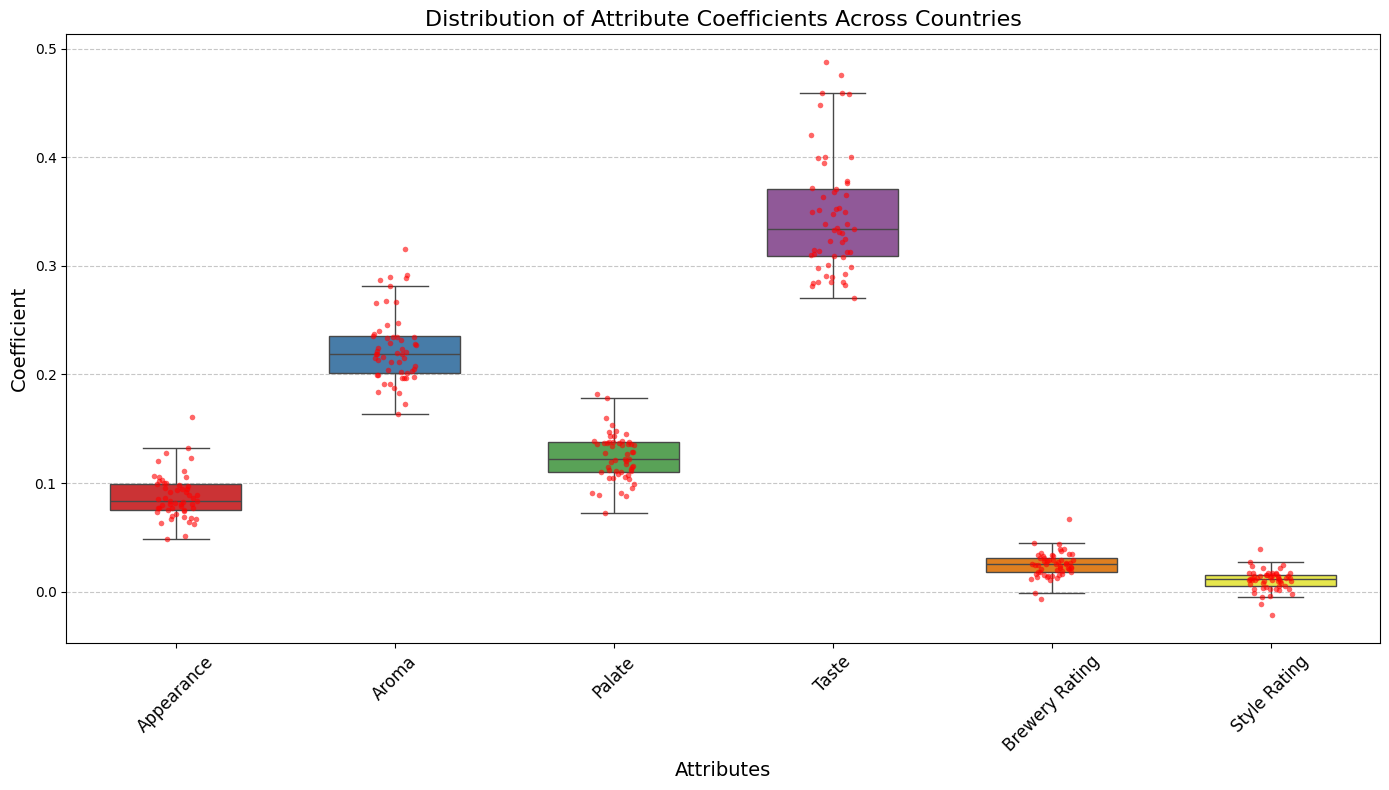

In [100]:
melted_coefficients = country_coefficients.melt(id_vars='country', var_name='attribute', value_name='coefficient')
attribute_mapping = {
    'x1': 'Appearance',
    'x2': 'Aroma',
    'x3': 'Palate',
    'x4': 'Taste',
    'x5': 'Brewery Rating',
    'x6': 'Style Rating'
}

melted_coefficients['attribute'] = melted_coefficients['attribute'].map(attribute_mapping)

plt.figure(figsize=(14, 8))
sns.boxplot(
    x='attribute', y='coefficient', data=melted_coefficients, palette='Set1', showfliers=False, width=0.6
)
sns.stripplot(
    x='attribute', y='coefficient', data=melted_coefficients, color='red', alpha=0.6, jitter=True, size=4
)

# Title and labels
plt.title('Distribution of Attribute Coefficients Across Countries', fontsize=16)
plt.xlabel('Attributes', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Median for each box
for i, box in enumerate(plt.gca().artists):
    box.set_edgecolor('black')  
    box.set_linewidth(1.2)      

plt.tight_layout()
plt.show()



Here we applied the linear regression analyses for each country which gave us information on how beer attributes and confounders influence ratings across various countries. While certain attributes show consistent importance globally, notable regional variations reflect cultural and contextual preferences.

Across thecountries, taste remains as the most influential factor while giving ratings to the beer. The boxplot helps us to illustrate its dominance,the taste having the highest coefficient median and the widest interquartile range. This variation in taste's influence might reflect country specific differences in how much importance users place give to the taste while evaluating beers . Similarly, aroma  consistently emerges as the second most significant attribute, with more tightly clustered coefficients compared to taste indicating widespread agreement on its importance. Palate and appearance contribute positively to beer ratings but with lower coefficients. Regional differences in these attributes’ coefficients suggest that some countries may focus on the visual or texture-related qualities more than others. 
The brewery rating displays moderate coefficients across most countries, shown. This shows us that users' perception of brewery reputation does play a role, but it is smaller compared to the other attributes. It implies that trust or familiarity with a brewery can subtly influence ratings but is secondary to essential beer qualities. On the other hand, style rating consistently shows the lowest influence across countries. This negligible impact suggests that the specific beer style classification is not a significant determinant of ratings for most users. Instead, sensory attributes, such as taste and aroma, carry more weight in users’ evaluations.








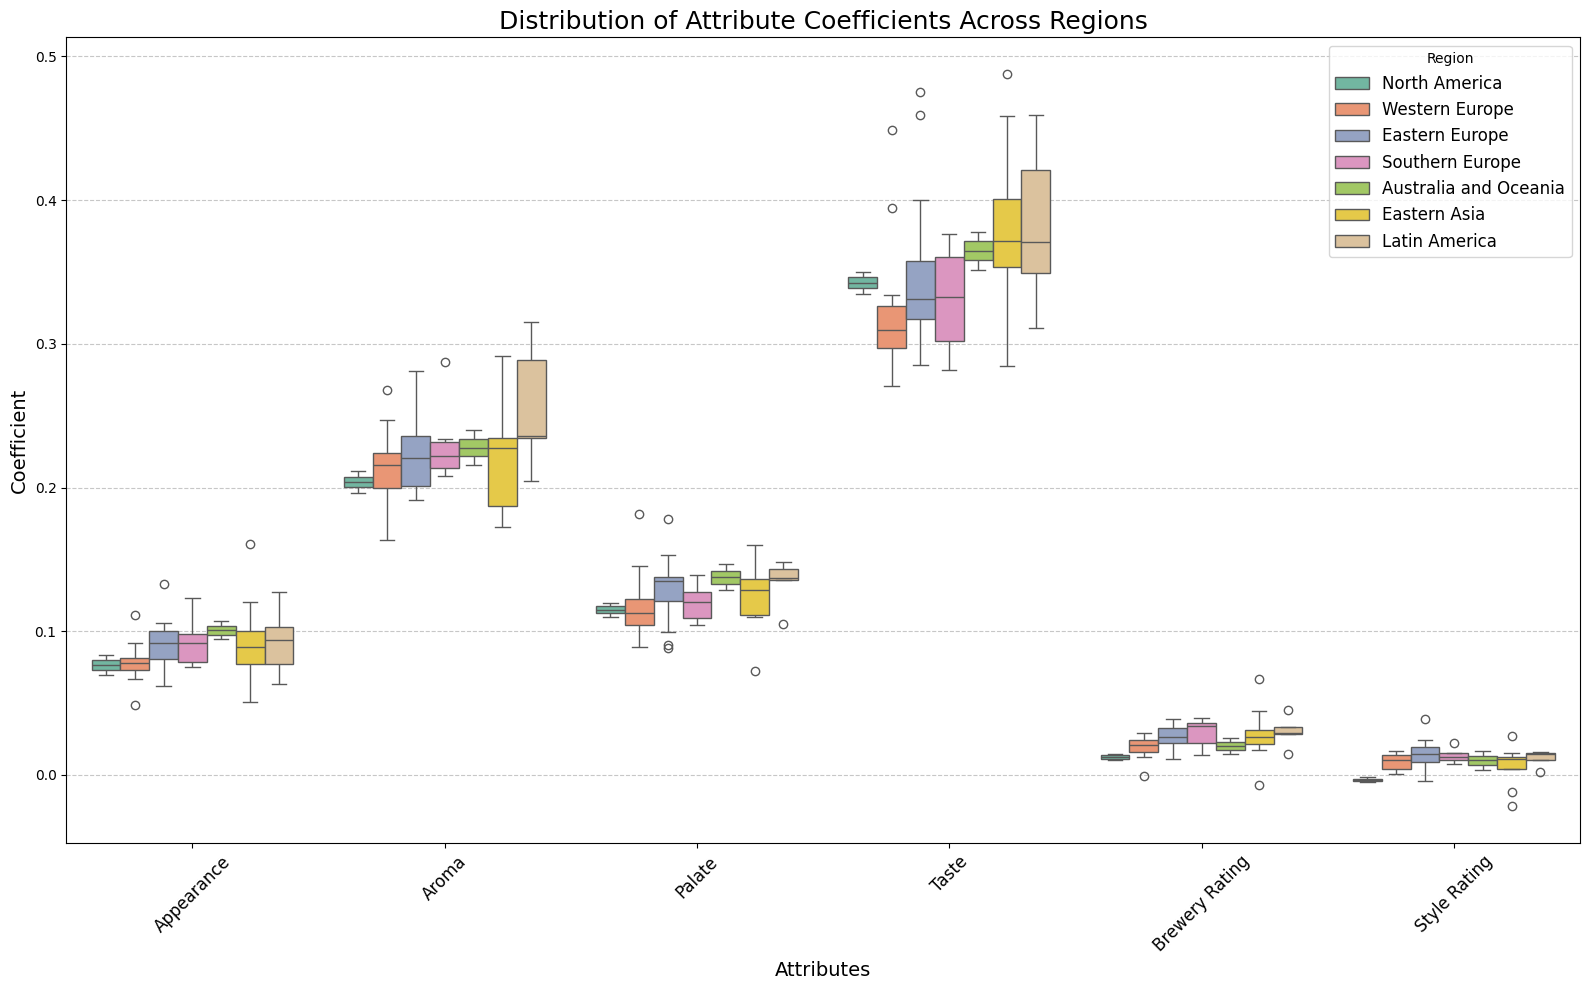

In [101]:
country_region_mapping, _ = region_mapping(country_coefficients)

# Step 1: Map countries to regions using the mapping dictionary
country_coefficients['region'] = country_coefficients['country'].map(country_region_mapping)

# Step 2: Melt the DataFrame for regional plotting
regional_coefficients = country_coefficients.melt(
    id_vars=['country', 'region'], 
    var_name='attribute', 
    value_name='coefficient'
)


regional_coefficients['attribute'] = regional_coefficients['attribute'].map(attribute_mapping)

# Creating box_plots for the regions 
plt.figure(figsize=(16, 10))
sns.boxplot(
    x='attribute', 
    y='coefficient', 
    hue='region', 
    data=regional_coefficients, 
    palette='Set2'
)

plt.title('Distribution of Attribute Coefficients Across Regions', fontsize=18)
plt.xlabel('Attributes', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Region', fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In conclusion, both the country specific and general analyses shows that beer ratings are primarily driven by sensory attributes and social effects such as brewery reputation is small compared to the essential attributes but it adds depth to our understanding of user preferences.


# 2) Location-related biases in ratings

## a) Cultural biases

In this part, we aim at determining whether users from certain countries are more generous or more critical in their ratings compared to users from other countries.

We will start by using a logistic regression model where the dependent variable is the reviewer’s country, and the independent variables are potentially relevant confounders, namely average rating for the beer style, brewery average rating and the number of reviews given by the user. The propensity scores that we will obtain will represent the likelihood of a review being associated with a particular country given these confounders. 

Using these propensity scores, we will then match individual reviews from reviewers in one country with reviews from reviewers in another country that have similar propensity scores. This matching will ensure that the paired reviews are comparable in terms of confounders, so that any differences in ratings are attributable to the reviewer’s country rather than other factors. 

**Logistic regression and matching**

We will work with the combined datasets. The corresponding dataframe is very large and contains a signficant number of reviews. Working with all of the data in this part is not reasonable. To bypass this issue, we will work with a subset of the dataset by randomly sampling up to 400 reviews from each unique user location. This will ensure proportional representation of each location in the sample.

In [206]:
# create a subset of the combined review dataframe by randomly sampling up to 400 reviews from each unique user location
subset = total_ratings_loc_filtered.groupby('user_location', group_keys=False).apply(lambda x: x.sample(min(len(x), 400), random_state=42))

We will add a unique id to each review to keep track of which reviews are paired with one another when we will later perform the matching. Then, we will perform the logistic regression.

In [207]:
# add a unique id to each review (1 for the one in the 1rst row, 2 for the second one, etc)
subset['review_id'] = range(1, len(subset) + 1)

# define the feature matrix and the target variable
X = subset[['style_avg_rating','brewery_avg_rating','user_nb_reviews']]
Y = subset['user_location']

User location is a categorical variable, hence we have to perform one-hot encoding.

In [208]:
Y = pd.get_dummies(Y, columns=['user_location'])

In [209]:
from sklearn.linear_model import LogisticRegression
def fit_logistic_regression_multi_output(X, Y, scale_data=True):
    """
    Fits multiple logistic regression models to the provided features and one-hot encoded target variable.

    parameters:
    X (pandas.DataFrame): feature matrix
    Y (pandas.DataFrame): target variable matrix (one-hot encoded)
    scale_data (bool): standardize the features before fitting the model or not

    returns:
    models (dict): dictionary of the fitted logistic regression models, keyed by target category
    propensity_scores (pandas.DataFrame): computed propensity scores for each instance and category
    """
    if scale_data:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X

    models = {}
    propensity_scores = pd.DataFrame(index=Y.index)

    # fit a logistic regression model for each country (column in Y)
    for country in Y.columns:
        model = LogisticRegression(max_iter=1000)
        model.fit(X_scaled, Y[country])
        models[country] = model
        propensity_scores[country] = model.predict_proba(X_scaled)[:, 1]  # probability of being from 'country'

    return models, propensity_scores

In [210]:
models, propensity_scores = fit_logistic_regression_multi_output(X, Y, scale_data=True)

In [211]:
# add the user_location from the original subset
X['user_location'] = subset['user_location']

# for each row, find the appropriate propensity score based on the row's index and user_location value
X['propensity_score'] = X.apply(lambda row: propensity_scores.loc[row.name, row['user_location']], axis=1)

X.head()

style_avg_rating  brewery_avg_rating  user_nb_reviews user_location  \
14464507          3.574880            3.833336                4     Argentina   
8994162           3.164008            3.309555              175     Argentina   
9383306           3.475659            3.950000                2     Argentina   
260510            3.850561            3.743380                5     Argentina   
9381340           3.329906            2.936111              175     Argentina   

          propensity_score  
14464507          0.041683  
8994162           0.036933  
9383306           0.042095  
260510            0.039132  
9381340           0.037845

In [212]:
X.describe()

style_avg_rating  brewery_avg_rating  user_nb_reviews  propensity_score
count      22000.000000        22000.000000     22000.000000      22000.000000
mean           3.334421            3.305574      2749.313773          0.031294
std            0.486454            0.512232      4848.309421          0.056713
min            1.915896            0.733333         0.000000          0.000183
25%            3.062233            3.044061        95.000000          0.017326
50%            3.453216            3.387904       909.000000          0.021789
75%            3.637258            3.650487      3069.000000          0.032566
max            4.276374            4.716667     46749.000000          0.969169

Let us now have a look at the obtained propensity scores. We can see that the scores are small. The mean propensity score is 0.0312, the median is 0.0217, and the standard deviation is 0.0567. To pair reviews with a similar propensity score, we can try to use a threshold on the order of the standard deviation, such as 0.05. This would ensure that paired reviews have propensity scores within roughly one standard deviation of one another, allowing reasonable matches while not being too lenient.

We will now use the propensity scores given to reviews to match individual reviews from reviewers in one country with reviews from reviewers in another country that have similar propensity scores. Each review will be matched to another review with a propensity score difference smaller than 0.017 and with a different value for user_location. If there is more than one such review, the chosen review will be the one with the smallest difference in propensity score. If there is no review satisfying the condition, the review will be discarded. Each review should be paired once.

Before performing the matching, we will add a unique id to each review in X, which will be the same id as the id of the corresponding review in the original subset dataframe. This will allow us to map each row in the matched dataset back to subset and retrieve additional information like "final rating".

In [213]:
# add a unique id to each review (1 for the one in the 1rst row, 2 for the second one, etc)
X['review_id'] = range(1, len(X) + 1)

In [214]:
from bisect import bisect_left

def match_reviews(data, score_col='propensity_score', location_col='user_location', max_diff=0.05):
    """
    Match reviews based on their propensity scores.
    
    Each review (row in data) should be matched to another review:
    - with a propensity score difference smaller than max_diff
    - with a different user_location
    - if multiple possible matches are found, choose the one with the smallest difference
    - if no suitable match is found, discard the review
    - each review can be paired only once

    parameters:
    data (pandas.DataFrame): dataframe containing at least two columns: user_location and propensity_score, where each row corresponds to a review
    score_col (str): name of the column containing the propensity scores
    location_col (str): name of the column containing the value of user_location
    max_diff (float): maximum allowed difference in propensity scores for matching

    returns:
    matched_df (pd.DataFrame): dataframe of matched pairs, with the columns from the original dataframe
    and matched rows; unmatched reviews are not included
    """

    # sort the data by propensity score for efficient searching
    data_sorted = data.sort_values(by=score_col).reset_index(drop=True)

    scores = data_sorted[score_col].values
    locations = data_sorted[location_col].values
    n = len(data_sorted)

    used = set() # keeps track of reviews that have already been matched
    matched_rows = []

    # iterate over each review and try to find the closest match
    for i in range(n):
        if i in used:
            continue # skip review if it's already matched
        
        current_score = scores[i]
        current_loc = locations[i]

        # use binary search to find the position where current_score would be inserted to maintain the sorted order, 
        # giving you index close to where similar scores are located
        pos = bisect_left(scores, current_score)

        best_match = None
        best_diff = max_diff

        # move left (towards lower scores) from pos to find suitable matches within max_diff of current_score,
        # updating best_match if a closer match is found
        j = pos - 1
        while j >= 0 and (current_score - scores[j]) <= max_diff:
            if j not in used and locations[j] != current_loc:
                diff = abs(current_score - scores[j])
                if diff < best_diff:
                    best_diff = diff
                    best_match = j
            j -= 1

        # move right (towards higher scores) from pos, again looking for close matches and updating best_match
        # if a better candidate is found
        j = pos
        while j < n and (scores[j] - current_score) <= max_diff:
            if j not in used and j != i and locations[j] != current_loc:
                diff = abs(current_score - scores[j])
                if diff < best_diff:
                    best_diff = diff
                    best_match = j
            j += 1

        # if a suitable match is found, record it
        if best_match is not None:
            used.add(i)
            used.add(best_match)
            # combine the two matched rows into one
            matched_pair = pd.concat(
                [data_sorted.iloc[i], data_sorted.iloc[best_match].add_suffix('_matched')],
                axis=0
            )
            matched_rows.append(matched_pair)

    if len(matched_rows) == 0:
        return pd.DataFrame()

    matched_df = pd.DataFrame(matched_rows)
    return matched_df

In [215]:
# perform review matching based on propensity score
matched_data = match_reviews(X, score_col='propensity_score', location_col='user_location', max_diff=0.05)
matched_data.head()

style_avg_rating  brewery_avg_rating  user_nb_reviews  user_location  \
0          2.046774            1.709767                2  United States   
1          2.046774            1.801400              574  United States   
2          2.046774            2.048044             2174  United States   
3          2.220336            2.274903                2  United States   
4          2.220336            2.388527              726  United States   

   propensity_score  review_id  style_avg_rating_matched  \
0          0.000183      21334                  2.046774   
1          0.000202      21466                  2.046774   
2          0.000265      21277                  2.046774   
3          0.000523      21496                  2.665326   
4          0.000593      21583                  2.649529   

   brewery_avg_rating_matched  user_nb_reviews_matched user_location_matched  \
0                    2.039452                      143               Romania   
1                    2.421802                      109               Romania   
2                    3.048372                      143               Romania   
3                    2.004783                       19               Romania   
4                    2.608215                     2391               Romania   

   propensity_score_matched  review_id_matched  
0                  0.000501              14956  
1                  0.000608              15172  
2                  0.000827              15105  
3                  0.001741              14836  
4                  0.001780              15011

In [216]:
print('Number of matches:',matched_data.shape[0])

Number of matches: 10943


We have about 11 thousand matches, we seems sufficient to continue our analysis. 

We will now retrieve the final rating corresponding to each review in each pair from the subset dataframe.

In [217]:
# merge to get final rating for the first review in each pair
matched_data = matched_data.merge(subset[['review_id', 'rating']], on='review_id', how='left')

# merge to get final rating for the matched review
matched_data = matched_data.merge(
    subset[['review_id', 'rating']], 
    left_on='review_id_matched', 
    right_on='review_id', 
    how='left', 
    suffixes=('', '_matched_temp')
)

matched_data = matched_data.drop(columns=['review_id_matched_temp'])  # drop the extra review_id column
matched_data = matched_data.rename(columns={'rating_matched_temp': 'rating_matched'})

matched_data.head()

style_avg_rating  brewery_avg_rating  user_nb_reviews  user_location  \
0          2.046774            1.709767                2  United States   
1          2.046774            1.801400              574  United States   
2          2.046774            2.048044             2174  United States   
3          2.220336            2.274903                2  United States   
4          2.220336            2.388527              726  United States   

   propensity_score  review_id  style_avg_rating_matched  \
0          0.000183      21334                  2.046774   
1          0.000202      21466                  2.046774   
2          0.000265      21277                  2.046774   
3          0.000523      21496                  2.665326   
4          0.000593      21583                  2.649529   

   brewery_avg_rating_matched  user_nb_reviews_matched user_location_matched  \
0                    2.039452                      143               Romania   
1                    2.421802                      109               Romania   
2                    3.048372                      143               Romania   
3                    2.004783                       19               Romania   
4                    2.608215                     2391               Romania   

   propensity_score_matched  review_id_matched  rating  rating_matched  
0                  0.000501              14956    3.90             1.9  
1                  0.000608              15172    1.40             2.2  
2                  0.000827              15105    2.20             3.2  
3                  0.001741              14836    2.25             3.5  
4                  0.001780              15011    3.00             2.7

**Paired analysis**

After the matching, we have pairs of reviews from different countries that are similar in terms of confounders. The differences in ratings within a pair should thus be due to the difference in country and not in confounders.

In order to determine whether users from certain countries are more generous or more critical in their ratings compared to users from other countries, we will compare paired rating differences between all pairs of user location. We will group paired reviews consisting of reviews from the same pair of countries, and for each group, we will perform a paired t-test to determine if the mean difference in ratings within pairs of the group is significantly different from zero. We will only consider country pairs with at least 10 paired reviews.

In [218]:
def standardize_pair(row):
    """
    Given a row with 'user_location', 'user_location_matched', 'rating', and 'rating_matched' columns, 
    ensures a consistent ordering of country pairs (alphabetically sorted) and adjusts the ratings accordingly
    so that the first listed country always corresponds to 'std_rating' and the second to 'std_rating_matched'.
    """
    loc1, loc2 = row['user_location'], row['user_location_matched']
    if loc1 > loc2:
        # swap countries and associated ratings
        return pd.Series({
            'user_location': loc2,
            'user_location_matched': loc1,
            'rating': row['rating_matched'],
            'rating_matched': row['rating']
        })
    else:
        # already in correct alphabetical order
        return pd.Series({
            'user_location': loc1,
            'user_location_matched': loc2,
            'rating': row['rating'],
            'rating_matched': row['rating_matched']
        })

In [256]:
def compare_countries_bidirectional(matched_data, test_func=ttest_rel):
    """
    Compares paired rating differences between all pairs of user locations, ensuring
    that (A, B) and (B, A) are grouped together and that the rating difference direction is consistent.

    parameters:
    matched_data (pandas.DataFrame): a dataFrame containing matched reviews
    (required columns: 'user_location', 'user_location_matched', 'rating', 'rating_matched')
    test_func (function): the statistical paired test to use, eg ttest_rel

    returns:
    results (pandas.DataFrame): a dataframe with one row per unique country pair (in alphabetical order)
    and columns for the test statistic, p-value, and sample size
    """

    df = matched_data.copy()
    df['user_location'] = df['user_location'].astype(str)
    df['user_location_matched'] = df['user_location_matched'].astype(str)

    # apply the standardization function row-wise
    standardized = df.apply(standardize_pair, axis=1)
    df = pd.concat([df.drop(columns=['user_location', 'user_location_matched', 'rating', 'rating_matched']), standardized], axis=1)

    # group by standardized country pairs
    grouped = df.groupby(['user_location', 'user_location_matched'], dropna=False)
    results = []

    for (loc1, loc2), group in grouped:
        if len(group) < 10:
            continue  # not enough data for a meaningful test

        # perform the paired test on rating vs rating_matched
        t_stat, p_value = test_func(group['rating'], group['rating_matched'])

        results.append({
            'country_1': loc1,
            'country_2': loc2,
            'test_stat': t_stat,
            'p_value': p_value,
            'n_pairs': len(group)
        })

    return pd.DataFrame(results)

In [257]:
# perform t-test to compare the difference in final beer rating for each pair of countries
results_df = compare_countries_bidirectional(matched_data)
results_df.head()

country_1 country_2  test_stat   p_value  n_pairs
0  Argentina    Brazil   1.051731  0.304876       22
1  Argentina  Bulgaria  -0.086377  0.931740       31
2  Argentina     Chile   0.363324  0.723249       12
3  Argentina   Estonia   2.816547  0.020160       10
4  Argentina   Germany   1.880418  0.089462       11

We will now plot the obtained p_values for each country pair to see if there are some significant differences in final beer ratings for some country pairs at a 5% significance level.

In [253]:
from matplotlib.lines import Line2D
def plot_pvalues(results_df, alpha=0.05, random_state=42):
    """
    Plots the p-values from the results dataframe for each country pair, adds a horizontal line at y=alpha, and labels only the p-values 
    smaller than alpha with their corresponding country pairs. Also shuffles the rows of the dataframe to avoid placing points 
    from the same first country consecutively, reducing label overlap.

    Additionally:
    - data points with p_value < alpha and test_stat > 0 are green
    - Data points with p_value < alpha and test_stat < 0 are red
    - other points are black

    parameters:
    results_df (pandas.DataFrame): dataframe returned by compare_countries_bidirectional
    (expected columns: ['country_1', 'country_2', 'test_stat', 'p_value'])
    alpha (float): significance level at which to draw the horizontal line (default 0.05)
    random_state (int): seed for reproducible shuffling

    returns:
    None; displays the plot
    """

    # shuffle the rows of the dataframe
    results_df = results_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # create a column that combines the country names for labeling
    results_df['pair_label'] = results_df['country_1'] + ' vs ' + results_df['country_2']

    # determine colors based on conditions
    colors = []
    for _, row in results_df.iterrows():
        if row['p_value'] < alpha:
            if row['test_stat'] > 0:
                colors.append('green')
            elif row['test_stat'] < 0:
                colors.append('red')
            else:
                # if test_stat == 0 and p_value > alpha
                colors.append('gray')
        else:
            colors.append('black')

    fig, ax = plt.subplots(figsize=(22, 8))

    # plot the p-values with assigned colors as a scatter plot
    ax.scatter(results_df.index, results_df['p_value'], color=colors, s=50)

    # draw a horizontal line at y=alpha
    ax.axhline(y=alpha, color='black', linestyle='--', linewidth=1)

    # label points with p-values < alpha
    for i, row in results_df.iterrows():
        if row['p_value'] < alpha:
            ax.text(i, row['p_value'], row['pair_label'], 
                    ha='center', va='bottom', rotation=90, fontsize=9)

    # create legend
    legend_elements = [
        Line2D([0], [0], color='green', marker='o', linestyle='None', markersize=10, label='p < 0.05, test_stat > 0'),
        Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=10, label='p < 0.05, test_stat < 0'),
        Line2D([0], [0], color='black', marker='o', linestyle='None', markersize=10, label='Other points'),
        Line2D([0], [0], color='black', linestyle='--', linewidth=1, label=f'Alpha = {alpha}')
    ]

    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

    ax.set_xlabel('Pair index')
    ax.set_ylabel('p-value')
    ax.set_title('p-values from test comparing the difference in final beer rating by country pair')

    plt.tight_layout()
    plt.show()
    plt.close()

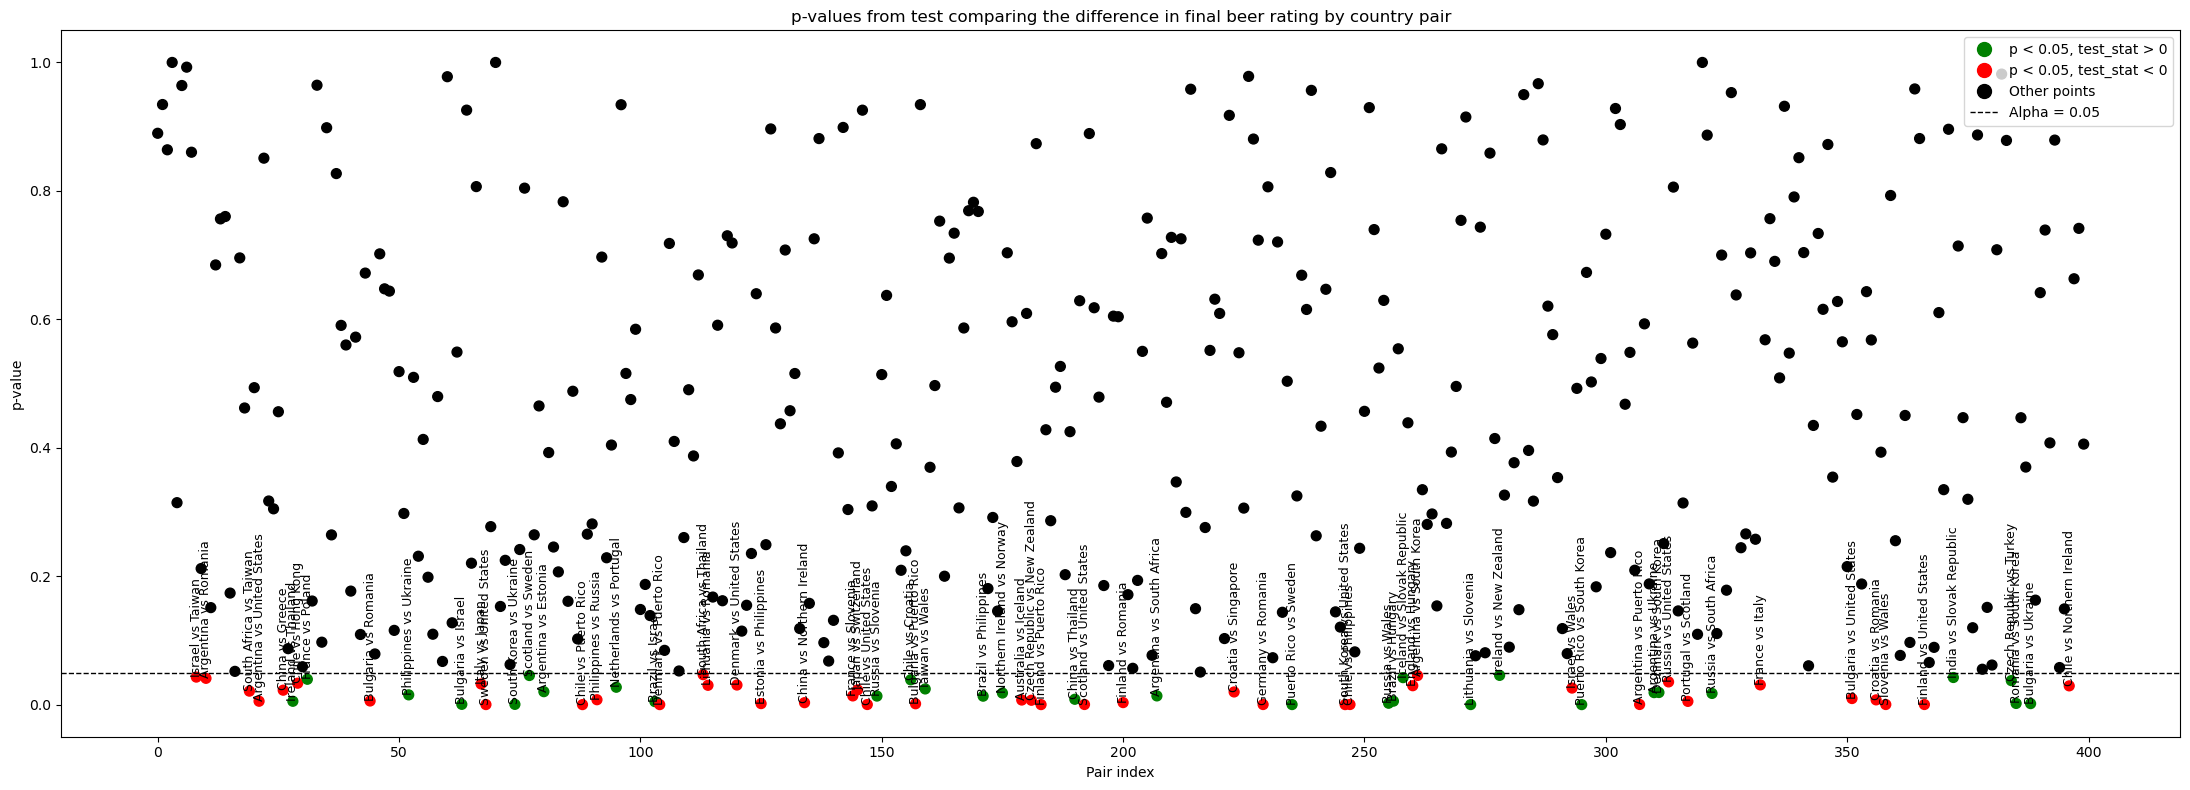

In [259]:
plot_pvalues(results_df)

We can see that the majority of tests yielded a p-value larger than 0.05, meaning that for most country pairs, the mean difference in final rating is not significant at a 5% significance level. However, there are several country pairs for which there is a significant difference in final rating. For instance, we can see that after accounting for confounders, users from Estonia tend to give ratings that are significantly lower than users from the Philippines from a statistical standpoint. On the other hand, users from Argentina tend to give ratings that are significantly higher than users from South Africa from a statistical standpoint. These results suggest that users from certain regions tend to be more generous or more critical in their ratings compared to users from other countries.

In order to determine if these differences are also meaningful from a practical standpoint, we will look at their magnitude. We will plot a boxplot to visualize the distribution of differences in final beer rating between matched reviews for the 10 country pairs for which the t-test yielded the lowest p-values. This will allow us to assess both the direction and size of the differences in ratings.

In [242]:
def plot_top_10_pairs_boxplot(matched_data, results_df):
    """
    Plots a boxplot of rating differences for the top 10 country pairs (smallest p-values) from the results_df. 
    Each box represents the distribution of rating differences (rating - rating_matched) for one country pair.

    parameters:
    matched_data (pandas.DataFrame): contains matched reviews with columns:
    ['user_location', 'user_location_matched', 'rating', 'rating_matched']
    results_df (pandas.DataFrame): results of compare_countries_bidirectional, with columns:
    ['country_1', 'country_2', 'test_stat', 'p_value', 'n_pairs']

    the function:
    1) sorts results_df by p_value and selects the top 10
    2) standardizes matched_data so that each pair is represented consistently as (A, B) where A < B
    3) filters matched_data to include only those top 10 pairs
    4) plots the boxplot of rating differences
    """
    
    # 1) get the top 10 country pairs by smallest p-value
    top_10 = results_df.sort_values(by='p_value', ascending=True).head(10)
    
    # create a set of (country_1, country_2) tuples representing these pairs for easy filtering
    top_10_pairs = set(zip(top_10['country_1'], top_10['country_2']))

    # 2) standardize matched_data to ensure a consistent pair labeling
    # standardize_pair should return columns: user_location, user_location_matched, rating, rating_matched
    df = matched_data.copy()
    standardized = df.apply(standardize_pair, axis=1)
    df = pd.concat([df.drop(columns=['user_location', 'user_location_matched', 'rating', 'rating_matched']), standardized], axis=1)

    # create a pair_label column for filtering and plotting
    df['pair_label'] = df['user_location'] + ' vs ' + df['user_location_matched']

    # create a tuple column to match with top_10_pairs
    df['pair_tuple'] = list(zip(df['user_location'], df['user_location_matched']))

    # 3) filter the dataframe to only include top 10 pairs
    df_filtered = df[df['pair_tuple'].isin(top_10_pairs)].copy()

    # compute the rating difference within pairs
    df_filtered['rating_difference'] = df_filtered['rating'] - df_filtered['rating_matched']

    # order pairs by p-value
    pair_order = top_10.apply(lambda row: (row['country_1'], row['country_2']), axis=1).tolist()

    # 4) plot boxplot 
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_filtered, x='pair_label', y='rating_difference', 
                order=[f"{a} vs {b}" for (a,b) in pair_order], color='orange')
    
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.title('Distribution of rating differences for top 10 country pairs by p-value')
    plt.xlabel('Country pair')
    plt.ylabel('Rating difference (country_1 - country_2)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    plt.close()

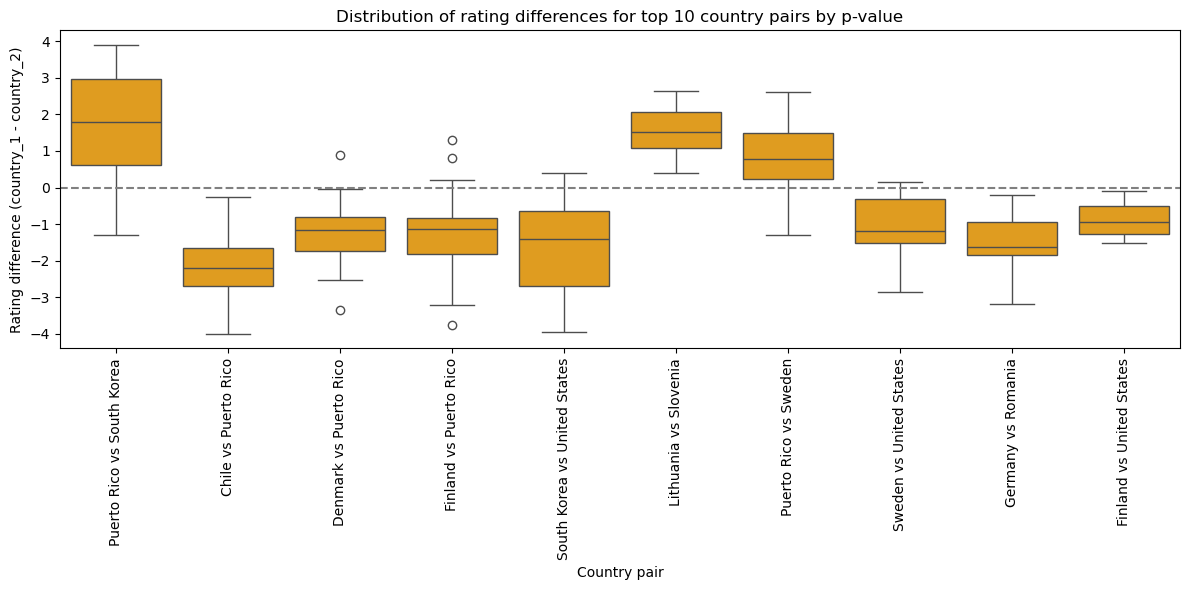

In [243]:
# plot a boxplot of rating differences for the top 10 country pairs (smallest p-values)
plot_top_10_pairs_boxplot(matched_data, results_df)

We observe that none of the boxes contain zero (zero is not comprised between Q1 and Q3). This means that for each of the top 10 country pairs with the lowest p-values, ratings from one country (country 1) are consistently higher or lower than those from the other country (country 2) for most paired reviews in the sample. This implies that the majority of matched reviews for each of these country pairs show a meaningful and unidirectional difference in ratings. In addition, the median for nearly all country pairs is larger than 1 in absolute value. A difference of 1 out of 5 is large, which means that for these country pairs, the differences in ratings are not only statistically significant but also meaningful from a practical standpoint.

**Conclusion**

Our analysis suggests that after accounting for potential confounders, users from certain countries are more generous in their ratings compared to users from other countries. There seems to be clear trends in rating differences for certain country pairs, and the differences in ratings appear significant from both a statistical and a practical standpoint. We conclude that there does seem to be a "cultural bias" among beer reviewers, which can have a meaningful impact on beer reviews.

## b) Beer origin bias

In this part, we will investigate whether users rate domestic beers higher than foreign ones. 

To do so, we will first identify users who have rated both domestic and foreign beers and filter for the reviews from those users. We will label each review as either domestic (reviewing a beer produced in the reviewer’s country) or foreign. For each user, we will match their reviews of domestic and foreign beers to ensure that comparisons are made between beers reviewed by the same user. We will also make sure that matched reviews correspond to the same beer style to account for the effect of beer style on ratings.

We will then perform a paired t-test to determine whether the mean difference in ratings within pairs is significantly different from zero. We will repeat this analysis focusing only on reviews from beer enthusiasts —users who have written a substantial number of reviews— who might prioritize intrinsic qualities of the beers over external factors such as location.

In this analysis, we will combine the data from the 2 review platforms.

In [111]:
# combine Beer Advocate and Rate Beer rating dataframes
ba_rb_combined = pd.concat([ba_ratings_loc_filtered, rb_ratings_loc_filtered], ignore_index=True)

The average ratings of foreign beers: 3.40 vs domestic beers: 3.69


foreign
False    10276083
True      4461631
Name: count, dtype: int64

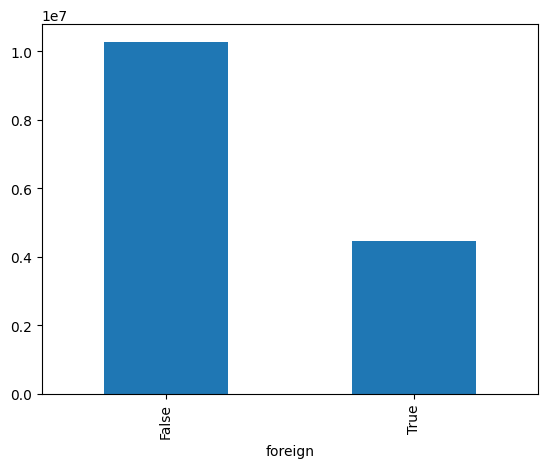

In [113]:
ba_rb_combined_filtered["foreign"]=ba_rb_combined['brewery_location'] != ba_rb_combined['user_location']
#display(ba_rb_combined_filtered)
#ba_rb_combined_filtered["domestic"]=ba_rb_combined[ba_rb_combined['brewery_location'] == ba_rb_combined['user_location']]

print(f'The average ratings of foreign beers: {ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==1]["rating"].mean():.2f} vs domestic beers: {ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==0]["rating"].mean():.2f}')


display(ba_rb_combined_filtered["foreign"].value_counts())
ba_rb_combined_filtered["foreign"].value_counts().plot(kind="bar")
plt.show()

As seen here, reviewers have provided ratings for domestic beers more frequently than for foreign ones. Additionally, we observe that reviewers tend to give higher ratings to domestic beers compared to foreign ones.

In [114]:
shapiro_domestic = shapiro(ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==1]["rating"])
shapiro_foreign = shapiro(ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==0]["rating"])
print("Shapiro-Wilk Test (Domestic):", shapiro_domestic)
print("Shapiro-Wilk Test (Foreign):", shapiro_foreign)

Shapiro-Wilk Test (Domestic): ShapiroResult(statistic=0.9695672487523745, pvalue=1.4062929172427075e-127)
Shapiro-Wilk Test (Foreign): ShapiroResult(statistic=0.9529238720272774, pvalue=2.774501527262888e-139)


To perform a t-test, it is crucial to ensure that the assumptions of normality and independence are met. Normality refers to the requirement that the ratings in each group should be approximately normally distributed. To verify this, the Shapiro-Wilk test was conducted for both groups. The results confirmed normality, as the p-values for both groups were greater than 0.05, indicating no significant deviation from a normal distribution. Therefore, the data satisfies the normality assumption necessary for conducting the t-test.

In [115]:
stats.ttest_ind(ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==1]["rating"], ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==0]["rating"])

TtestResult(statistic=-733.5596449691911, pvalue=0.0, df=14737712.0)

Here, we obtained a negative t-value, indicating that foreign beers have lower ratings compared to domestic beers. This suggests a potential bias based on the origin of the beer.

In [116]:
pearsonr(ba_rb_combined_filtered["foreign"], ba_rb_combined_filtered["rating"])

PearsonRResult(statistic=-0.18768654536373147, pvalue=0.0)

There is a statistically significant, weak negative correlation between whether a beer is foreign and its rating. This suggests that foreign beers, on average, receive slightly lower ratings compared to domestic beers, although the relationship is not strong. This finding may point to a potential bias or systematic preference for domestic beers among the reviewers.


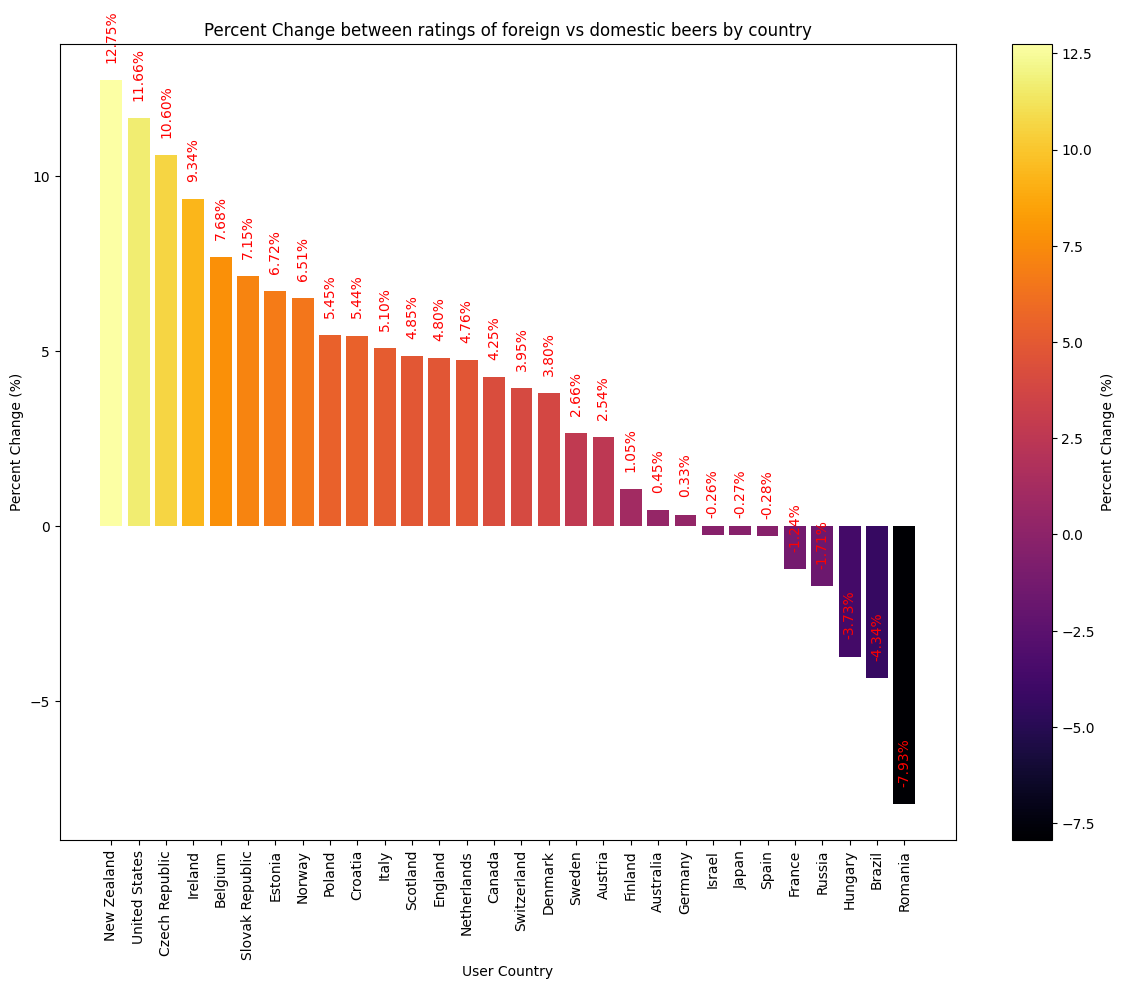

In [117]:
data1 = ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==1].groupby("user_location")["rating"].mean().sort_values(ascending=False).copy()
data2 = ba_rb_combined_filtered[ba_rb_combined_filtered["foreign"]==0].groupby("user_location")["rating"].mean().sort_values(ascending=False).copy()
data1 = data1/data1.sum()
data2 = data2/data2.sum()


#aligns data and calculates percent change
common_indices = data1.index.intersection(data2.index)
#print(common_indices)
percent_change = ((data2[common_indices] - data1[common_indices]) / data1[common_indices] * 100).sort_values(ascending=False)
percent_change=percent_change[percent_change.index.isin(ba_rb_combined_filtered["user_location"].value_counts().sort_values(ascending=False).head(30).index)]
#Extract sorted labels
labels_countries = percent_change.index

#Normalize values for colormap
norm = plt.Normalize(percent_change.min(), percent_change.max())
colors = plt.cm.inferno(norm(percent_change))

fig, ax = plt.subplots(figsize=(12,10))
bars = ax.bar(labels_countries, percent_change, color=colors)

#Annotate bars with values
for bar, value in zip(bars, percent_change):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.5, f'{value:.2f}%', ha='center', va='bottom', color='red', rotation=90)

ax.set_xlabel('User Country')
ax.set_ylabel('Percent Change (%)')
ax.set_title('Percent Change between ratings of foreign vs domestic beers by country')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='inferno', norm=norm), ax=ax)
cbar.set_label('Percent Change (%)')

plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

This graph shows the percentage change in ratings between foreign and domestic beers for the top 20 user locations. Positive values indicate that users rated domestic beers higher than foreign beers, while negative values show a preference for foreign beers. The bar lengths and colors highlight the magnitude and direction of these differences across countries. Additionally, it is evident that many of the top countries gave higher ratings to domestic beers compared to foreign ones.

# 3) Other biases

## a) Seasonal biases

In this part, we will examine how seasonal changes influence the ratings of different beer styles.

**Season labeling**

To start with, we will use the time information to determine the season during which each rating was posted. This task may be complex as some countries are in the Northern hemisphere and others are in the Southern hemisphere, and some may be located close to the Equator and may thus not even experience seasons! We will simplify things by only considering reviews from the 10 countries with the most reviews. We will determine whether they are in the Northern or Southern hemisphere and use the time information in the reviews to determine the season during which each review was posted.

Let us first identify the 10 countries with the most reviews.

In [119]:
# combine user locations from Beer Advocate and Rate Beer review dataframes
combined_user_locations = pd.concat([ba_ratings_loc_filtered['user_location'], rb_ratings_loc_filtered['user_location']])

# get the 10 most frequent values in the combined 'user_location' column
top_10_combined_locations = combined_user_locations.value_counts().head(10).index.tolist()

top_10_combined_locations

['United States',
 'Canada',
 'Denmark',
 'England',
 'Sweden',
 'Netherlands',
 'Germany',
 'Norway',
 'Finland',
 'Poland']

Let us know filter reviews from these countries only.

In [120]:
ba_ratings_top_10_locations = ba_ratings_loc_filtered[ba_ratings_loc_filtered['user_location'].isin(top_10_combined_locations)]
ba_ratings_top_10_locations['user_location'].value_counts()

user_location
United States    7303869
Canada            274512
England            41597
Sweden             29914
Netherlands        22952
Germany            17460
Finland             3076
Norway              3037
Poland              2225
Denmark              893
Name: count, dtype: int64

In [121]:
rb_ratings_top_10_locations = rb_ratings_loc_filtered[rb_ratings_loc_filtered['user_location'].isin(top_10_combined_locations)]
rb_ratings_top_10_locations['user_location'].value_counts()

user_location
United States    3108958
Denmark           581975
Canada            522693
England           440845
Sweden            283459
Netherlands       233741
Germany           218794
Norway            216892
Finland           191900
Poland            154391
Name: count, dtype: int64

We can see that the 10 locations with the highest number of reviews are all countries located in the Northern hemisphere. This will make it easier to determine the season during which reviews were posted. To do this, we will use a function called 'get_season', which determines the season based on the month information contained in a date (eg,'Winter' if the month is December, January or February) and that we have written in src/utils/data_utils.py, to create a new column called 'season' in rating dataframes.

In [122]:
ba_ratings_top_10_locations['season'] = ba_ratings_top_10_locations['date'].apply(lambda x: get_season(pd.to_datetime(x)))
rb_ratings_top_10_locations['season'] = rb_ratings_top_10_locations['date'].apply(lambda x: get_season(pd.to_datetime(x)))
ba_ratings_top_10_locations.head()

beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
5       Legbiter   19827.0       Strangford Lough Brewing Company Ltd   
6       Legbiter   19827.0       Strangford Lough Brewing Company Ltd   
7       Legbiter   19827.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date       user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00         nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00     StJamesGate   
5     10093.0  English Pale Ale  4.8 2014-12-01 11:00:00       Hellpop65   
6     10093.0  English Pale Ale  4.8 2014-05-29 10:00:00        Latarnik   
7     10093.0  English Pale Ale  4.8 2014-02-26 11:00:00  RochefortChris   

                 user_id  appearance  ...  palate  taste  overall  rating  \
0         nmann08.184925        3.25  ...    3.25   2.75      3.0    2.88   
1     stjamesgate.163714        3.00  ...    3.50   4.00      3.5    3.67   
5        hellpop65.48993         NaN  ...     NaN    NaN      NaN    3.25   
6         latarnik.52897         NaN  ...     NaN    NaN      NaN    3.50   
7  rochefortchris.697017         NaN  ...     NaN    NaN      NaN    3.50   

   user_avg_rating  brewery_avg_rating  style_avg_rating  user_location  \
0         3.730887            2.880000          2.986608  United States   
1         3.885664            3.526513          3.542445  United States   
5         3.317313            3.526513          3.542445  United States   
6         3.438060            3.526513          3.542445  United States   
7         3.910482            3.526513          3.542445  United States   

   brewery_location  season  
0             Gabon  Summer  
1  Northern Ireland  Winter  
5  Northern Ireland  Winter  
6  Northern Ireland  Spring  
7  Northern Ireland  Winter  

[5 rows x 21 columns]

In [124]:
ba_ratings_top_10_locations['season'].value_counts()

season
Summer    1972440
Winter    1956038
Spring    1929090
Fall      1841967
Name: count, dtype: int64

**Linear regression**

We will now perform a linear regression analysis with the final rating as the dependent variable and key predictors, namely season, average rating for the beer style, average rating for the brewery, user’s average rating and ABV as the independent variables. 

We will then examine the regression coefficients for the season variable to see whether ratings are significantly higher or lower in certain seasons after accounting for confounders. Using these coefficients, we  will calculate predicted ratings for each beer style in each season and visualize the results with line charts, showing seasonal trends for different beer styles. This will allow us to visualize how ratings fluctuate with the seasons and how these patterns differ by beer style.

#### Step 1: 
We will perform linear regression.

In [142]:
print(ba_ratings_top_10_locations[['user_name', 'user_avg_rating']].head())

        user_name  user_avg_rating
0         nmann08         3.730887
1     StJamesGate         3.885664
5       Hellpop65         3.317313
6        Latarnik         3.438060
7  RochefortChris         3.910482


We will concatanate both RateBeer and BeerAdvocate datasets.

In [143]:
# merging BeerAdvocate and RateBeer datasets
combined_ratings = pd.concat([ba_ratings_top_10_locations, rb_ratings_top_10_locations], ignore_index=True)

print("Combined Ratings Dataset:")
print(combined_ratings.head())

MemoryError: Unable to allocate 104. MiB for an array with shape (1, 13653183) and data type object

In [ ]:
columns_to_keep = ['season', 'style', 'abv', 'user_avg_rating', 'brewery_avg_rating', 'style_avg_rating', 'rating']
data_reduced = combined_ratings[columns_to_keep].dropna()

In [ ]:
#we use one-hot encoding for the season variable. 
# due to the structure of the onehotencode we drop the first column to gather insights 
data_reduced = pd.get_dummies(data_reduced, columns=['season'], drop_first=True)


In [ ]:
# we concataneted all the independent variables
data_reduced = data_reduced.drop(columns=['style'])

X = data_reduced.drop(columns=['rating'])
y = data_reduced['rating']


In [ ]:
# linear regression drom data_utils.py 
metrics, model = advanced_linear_regression(X, y, model_type='linear', scale_data=True, make_plots=False, print_summary=True)


#### Step 2:
We will examine the coefficients for the season. They indicate whether ratings are significantly higher or lower in certain seasons, after accounting for confounders.

In [ ]:
#we get coefficients from the model 
linear_coefficients = model.params  

feature_names = ['Intercept'] + list(X.columns)
linear_coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': linear_coefficients})

display(linear_coefficients_df)

When we observe the coefficients, brewery_avg_rating and user_avg_rating are the largest coefficients. They incluence mostly the beer ratings. The coefficients of season_Spring, season_Summer and  season_Winter are very close to zero, hence we conclude that the seasonal changes on beer ratings is very very small. 

In [ ]:
# extract coefficients and their confidence intervals from the model
conf_int = model.conf_int()

# plot coefficients
plot_coefficients(linear_coefficients, conf_int, "Linear regression coefficient plot", bar_color='orange')

x3 which is brewery_avg_rating is the highest coefficent, and has the highest effect on predicted beer ratings. x2 and x4 which are user_avg_rating and style_avg_rating have significant but smaller effect on the predicted ratings. abv coefficient has small but positive effect. The season coefficients are very close to zero hence they have a negiligible effect on the beer ratings. 

#### Step 3: 
Using the regression coefficients, we will calculate the predicted ratings for each beer style in each season, and create a table with columns for season, beer style and predicted rating.

In [ ]:
season_columns = [col for col in data_reduced.columns if col.startswith('season_')]
seasons = [col.replace('season_', '') for col in season_columns]  # Remove 'season_' prefix
seasons

In [ ]:
styles = combined_ratings['style'].unique()

In [ ]:
# we will have combinations of all unique seasons and styles
combinations = pd.DataFrame(list(product(seasons, styles)), columns=['season', 'style'])

grouped_data = combined_ratings.groupby('style').agg({
    'abv': 'mean',
    'user_avg_rating': 'mean',
    'brewery_avg_rating': 'mean',
    'rating': 'mean'
}).reset_index()

In [ ]:
combinations = combinations.merge(grouped_data, on='style', how='left')

#one-hot encoded columns
for season in seasons:
    combinations[f'season_{season}'] = (combinations['season'] == season).astype(int)

In [ ]:
#filling missing values
combinations['abv'] = combinations['abv'].fillna(data_reduced['abv'].mean())
combinations['user_avg_rating'] = combinations['user_avg_rating'].fillna(data_reduced['user_avg_rating'].mean())
combinations['brewery_avg_rating'] = combinations['brewery_avg_rating'].fillna(data_reduced['brewery_avg_rating'].mean())

In [ ]:
#scaling 
scaler = StandardScaler()
numerical_features = ['abv', 'user_avg_rating', 'brewery_avg_rating']
combinations[numerical_features] = scaler.fit_transform(combinations[numerical_features])

In [ ]:
combinations = combinations.drop(columns=['season'])

X_pred = combinations.drop(columns=['style'])
X_pred = sm.add_constant(X_pred)#added intercept

In [ ]:
#prediction
predicted_ratings = model.predict(X_pred)
combinations['predicted_rating'] = predicted_ratings

We put the predicted ratings into a table where rows represent beer styles, columns represent seasons and each cell contain the predicted ratings.

In [ ]:
#one-hot encoded columns
combinations['season'] = combinations.apply(
    lambda row: 'Spring' if row['season_Spring'] == 1 else
                'Summer' if row['season_Summer'] == 1 else
                'Winter' if row['season_Winter'] == 1 else None, axis=1
)

predicted_table = combinations.pivot_table(
    values='predicted_rating',
    index='style',
    columns='season',
    fill_value=0
)

display(predicted_table)


In [ ]:

plt.figure(figsize=(14, 10))

sorted_styles = predicted_table.mean(axis=1).sort_values(ascending=False).index
sorted_table = predicted_table.loc[sorted_styles]

#heatmap for beer styles across seasons
sns.heatmap(
    sorted_table,
    annot=False,
    cmap="coolwarm",
    cbar_kws={'label': 'Predicted Rating'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Seasonal Trends in Predicted Ratings by Beer Style", fontsize=18)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Beer Style", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


We expected minimal variations in average predicted ratings becuase of the coefficients that we found above. As there is a dominance of user_avg_rating and the small coefficients for season, style, and season_style, we expected for the predicted ratings to be similar. Hence we conclude that user_avg_rating is the most critical determinant of beer ratings. 

Most beer styles show little color variations accross seasons. We understand that the predicted ratings for the beer styles are the same regardless of the season. The season has small effect on the predicted ratings. We conclude that the seasonal changes have small but statistically significant effect on predicted ratings.

#### Step 4: 
We will use line charts to show the seasonal trends for each beer style: plot beer styles on the y-axis and seasons on the x-axis, with a line for each beer style.

In [ ]:
predicted_table['average_rating'] = predicted_table.mean(axis=1)

# we look at top 10 beer styles by average predicted rating
top_10_styles = predicted_table.sort_values(by='average_rating', ascending=False).head(10)
top_10_styles = top_10_styles.drop(columns=['average_rating'])

top_10_predicted(top_10_styles,'Top')

There is very small variation in seasons for beer styles. The lines appear to be mostly flat. The beer styles which are American Double, Quadrupel, Gueuze etc. are consistennyly rated highly regardless of the season. The top 10 beer styles are generally can be considered as that their ratings are not very affected by the seasons.

In [ ]:
bottom_10_styles = predicted_table.sort_values(by='average_rating', ascending=False).tail(10)
bottom_10_styles = bottom_10_styles.drop(columns=['average_rating'])

# we look at bottom 10 beer styles by average predicted rating

top_10_predicted(bottom_10_styles,'Bottom')

These are lowly rated beers and they all received low ratings accross seasons. There is not a visible difference of ratings between the seasons for these beer styles. We again get that seasons is not an important factor in determining the beer ratings. 

In [ ]:
# we will first calculate the average predicted rating for each season
average_ratings_by_season = combinations.groupby('season')['predicted_rating'].mean()

# results
print("Average Predicted Ratings by Season:")
print(average_ratings_by_season)

In [ ]:
# average predicted ratings by season
plt.figure(figsize=(8, 6))
average_ratings_by_season.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Predicted Ratings by Season")
plt.xlabel("Season")
plt.ylabel("Average Predicted Rating")
plt.show()

In [ ]:
#  the range (max - min) of predicted ratings for each beer style between seasons
predicted_table['rating_range'] = predicted_table.max(axis=1) - predicted_table.min(axis=1)

styles_with_seasonal_variation = predicted_table.sort_values(by='rating_range', ascending=False)

# we get beer styles with highest seasonal variations
print("Beer Styles with Highest Seasonal Variation in Predicted Ratings:")
top_10_variations = styles_with_seasonal_variation.head(10)
display(top_10_variations)


In [ ]:
least_10_variations = styles_with_seasonal_variation.tail(10)
display(least_10_variations)

We observe that the rating_range values are the same. Ans we can conclude that the seasonals is not a meaningful predictor for beer ratings, and the model's predictions are largely inaffected by the seasonal changes.

In [ ]:
rating_variations = predicted_table.max(axis=1) - predicted_table.min(axis=1)

plt.figure(figsize=(10, 6))
plt.hist(rating_variations, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Seasonal Variation (Max-Min) in Predicted Ratings", fontsize=16)
plt.xlabel("Rating Range (Max - Min)", fontsize=14)
plt.ylabel("Number of Beer Styles", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In this histogram we observe that most of the beer styles are in a small max- min rating range. Most of them have low rating range. This shows that the effects of season on ratings are generally few. Max-min values are not spreaded out, hence the predicted ratings are generally very similar accross seasons for beer styles.  

## b) Experience biais

**Data preparation**

To analyze how users’ rating tendencies evolve with experience, we will focus on users who have posted a substantial number of reviews, based on a chosen threshold. Let us set that threshold arbitrarily to 15 reviews, which seems like a number of reviews that is high enough to be able to define different experience levels.

First, let us verify that we have enough users who wrote at least this many reviews.

In [113]:
REVIEW_NB_THRESHOLD = 15

# calculate the counts of each 'user_id' in the review dataframes
ba_user_counts = ba_ratings['user_id'].value_counts()
rb_user_counts = rb_ratings['user_id'].value_counts()

# keep only user_id values that appear at least 15 times
ba_prolific_users = ba_user_counts[ba_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()
rb_prolific_users = rb_user_counts[rb_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()

print("Number of users who wrote at least",REVIEW_NB_THRESHOLD,"reviews:")
print('Beer Advocate:',len(ba_prolific_users))
print('Rate Beer:',len(rb_prolific_users))

Number of users who wrote at least 15 reviews:
Beer Advocate: 39945
Rate Beer: 13832


We have about 40 and 14 thousand users who wrote at least 15 reviews on Beer Advocate and Rate Beer, respectively, which seems to be enough data to do perform our analysis. We can also note that we have significantly more data from Beer Advocate than from Rate Beer.
Let us now isolate reviews from these users.

In [114]:
# filter rating dataframes to isolate users who wrote at least 15 reviews
prolific_ba_users_ratings = ba_ratings[ba_ratings.user_id.isin(ba_prolific_users)]
prolific_rb_users_ratings = rb_ratings[rb_ratings.user_id.isin(rb_prolific_users)]

Our analysis will start by sorting the reviews of each user chronologically and assigning an "experience level" to each rating based on the number of reviews they had posted up to that point. These levels will be predefined and consistent across all users: new reviewer (first n reviews), amateur (from the n+1th to the oth review), and expert (from the o+1th review onward).

Let us define these experience levels arbitrarily: we will consider that a user is a new reviewer for the first 5 reviews, an amateur for the 6th to the 10th review and and expert starting from the 11th review. In our analysis, we will compare reviews from "new reviewers" and from "expert reviewers", which correspond to the extremes of the defined experience spectrum.

In [115]:
# define experience levels
NEW_REVIEWER_THRESHOLD = 5
AMATEUR_THRESHOLD = 10

Let us now add experience levels to the reviews of users who wrote at least 15 reviews

In [116]:
ba_ratings_with_experience_levels = assign_experience_level(prolific_ba_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
ba_ratings_with_experience_levels.sample(5)

beer_name  beer_id  \
6786826  Atwater Conniption Fit Double IPA  59143.0   
4271973                             Ranger  55081.0   
2848735              Whale's Tale Pale Ale   1439.0   
2278633                        Sculpin IPA  29619.0   
5623189           Harvest Time Pumpkin Ale  38934.0   

                          brewery_name  brewery_id  \
6786826                Atwater Brewery     15280.0   
4271973            New Belgium Brewing       192.0   
2848735             Cisco Brewers Inc.       261.0   
2278633  Ballast Point Brewing Company       199.0   
5623189               Big Boss Brewing     15189.0   

                                  style  abv                date    user_name  \
6786826  American Double / Imperial IPA  8.0 2010-06-29 10:00:00        Durge   
4271973                    American IPA  6.5 2014-07-12 10:00:00   MikeDAdams   
2848735                English Pale Ale  5.6 2004-12-21 11:00:00  NeroFiddled   
2278633                    American IPA  7.0 2015-07-19 10:00:00        JCoff   
5623189                     Pumpkin Ale  5.5 2012-12-03 11:00:00  hopsolutely   

                    user_id  appearance  aroma  palate  taste  overall  \
6786826        durge.139656         4.0    2.5     3.5    3.0     4.00   
4271973   mikedadams.821193         NaN    NaN     NaN    NaN      NaN   
2848735     nerofiddled.526         4.5    4.0     4.0    4.0     4.50   
2278633        jcoff.818453         4.0    4.0     4.0    4.5     4.25   
5623189  hopsolutely.513175         3.5    3.5     3.5    3.5     3.50   

         rating  user_avg_rating  brewery_avg_rating  style_avg_rating  \
6786826    3.19         3.850078            3.403446          4.163594   
4271973    3.75         4.229210            3.744626          3.957763   
2848735    4.13         3.968742            3.707002          3.542445   
2278633    4.25         4.002105            4.087921          3.957763   
5623189    3.50         3.735349            3.663810          3.720077   

        experience_level  
6786826           expert  
4271973           expert  
2848735           expert  
2278633           expert  
5623189           expert

In [117]:
rb_ratings_with_experience_levels = assign_experience_level(prolific_rb_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
rb_ratings_with_experience_levels.sample(5)

beer_name   beer_id  \
3127261                     Lagunitas New DogTown Pale Ale   86876.0   
803652                 To Øl Dont Gose Towards The Light!  471065.0   
923400   Waren des Täglichen Bedarfs BIER - Geschmack b...  150101.0   
6379212                                 La Rulles Estivale   48719.0   
3514302                         Jacks Abby Hoponius Union  148148.0   

                                         brewery_name  brewery_id  \
3127261  Lagunitas Brewing Company &#40;Heineken&#41;      1167.0   
803652                                          To Øl     12119.0   
923400                            Einsiedler Brauhaus      1727.0   
6379212                Brasserie Artisanale de Rulles      1896.0   
3514302                           Jacks Abby Brewing     13049.0   

                                 style  abv                date     user_name  \
3127261              American Pale Ale  6.2 2016-03-22 11:00:00        k0mpsa   
803652   Grodziskie/Gose/Lichtenhainer  3.5 2017-06-18 10:00:00      anders37   
923400               Dortmunder/Helles  5.3 2013-01-31 11:00:00      Brandman   
6379212                    Belgian Ale  5.2 2010-07-04 10:00:00   Borresteijn   
3514302              India Style Lager  6.5 2017-02-22 11:00:00  meccahh69lol   

          user_id  appearance  aroma  palate  taste  overall  rating  \
3127261  168560.0         4.0    8.0     4.0    8.0     14.0     3.8   
803652    18419.0         3.0    6.0     3.0    6.0     14.0     3.2   
923400    85449.0         2.0    4.0     2.0    6.0     10.0     2.4   
6379212   78296.0         3.0    8.0     3.0    8.0     16.0     3.8   
3514302  444539.0         4.0    7.0     4.0    8.0     18.0     4.1   

         user_avg_rating  brewery_avg_rating  style_avg_rating  \
3127261         3.436902            3.671363          3.329906   
803652          3.223536            3.658444          3.448252   
923400          3.024613            2.918744          2.906902   
6379212         3.154225            3.570931          3.288888   
3514302         3.751136            3.634492          3.453216   

        experience_level  
3127261           expert  
803652            expert  
923400            expert  
6379212           expert  
3514302           expert

**Linear regression**

The first part of our analysis will consist of a linear regression aiming at quantifying the effect of experience level on ratings while simultaneously adjusting for potential confounders. The dependent variable will be the final rating of the beer, and the key independent variable will be the experience level of the user. We will also include additional independent variables corresponding to potential confounders, namely the average rating for the corresponding beer style, the average rating for the corresponding brewery and user generosity (the average rating for the corresponding user).

Let us start by removing potential NaN values from the dataframes produced in the previous part.

In [118]:
print("Initial number of reviews (BeerAdvocate):",ba_ratings_with_experience_levels.shape[0])
ba_ratings_with_experience_levels = ba_ratings_with_experience_levels.dropna()
print("Number of reviews after NaN removal (BeerAdvocate):",ba_ratings_with_experience_levels.shape[0])

print("Initial number of reviews (RateBeer):",rb_ratings_with_experience_levels.shape[0])
rb_ratings_with_experience_levels = rb_ratings_with_experience_levels.dropna()
print("Number of reviews after NaN removal (RateBeer):",rb_ratings_with_experience_levels.shape[0])

Initial number of reviews (BeerAdvocate): 8014572
Number of reviews after NaN removal (BeerAdvocate): 4457719
Initial number of reviews (RateBeer): 6959995
Number of reviews after NaN removal (RateBeer): 6787430


We will now perform linear regression using the advanced_linear_regression helper function in data_utils.py.

In [119]:
# define features and the target variable
X_ba = ba_ratings_with_experience_levels[["experience_level","style_avg_rating","user_avg_rating","brewery_avg_rating"]]
y_ba = ba_ratings_with_experience_levels["rating"]

X_rb = rb_ratings_with_experience_levels[["experience_level","style_avg_rating","user_avg_rating","brewery_avg_rating"]]
y_rb = rb_ratings_with_experience_levels["rating"]

Experience level is a categorical variable, hence we need to perform one-hot encoding for the corresponding column.

In [120]:
X_ba = pd.get_dummies(X_ba, columns=['experience_level'], drop_first=True)
X_rb = pd.get_dummies(X_rb, columns=['experience_level'], drop_first=True)
X_ba.head()

style_avg_rating  user_avg_rating  brewery_avg_rating  \
8066930          4.199219         4.187515            4.293222   
7506943          4.189310         4.187515            3.814326   
5304312          4.163594         4.187515            3.957581   
6886756          3.957763         4.187515            4.000324   
4486754          4.163594         4.187515            3.949614   

         experience_level_expert  experience_level_new_reviewer  
8066930                    False                           True  
7506943                    False                           True  
5304312                    False                           True  
6886756                    False                           True  
4486754                    False                           True

In [121]:
# perform linear regression on BeerAdvocate data
metrics_ba, model_ba = advanced_linear_regression(X_ba, y_ba, model_type='linear', make_plots=False, scale_data=True, test_size=0.2, print_summary=True)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                 5.134e+05
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:11:05   Log-Likelihood:            -2.0186e+06
No. Observations:             3566175   AIC:                         4.037e+06
Df Residuals:                 3566169   BIC:                         4.037e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8910      0.000   1.72e+04      0.0

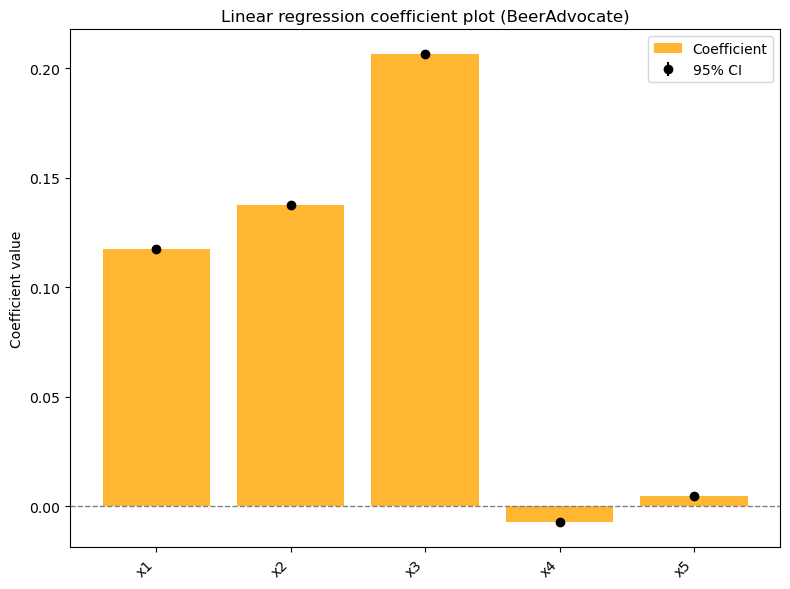

In [122]:
# extract coefficients and their confidence intervals from the model
coefficients_ba = model_ba.params
conf_int_ba = model_ba.conf_int()

# plot coefficients
plot_coefficients(coefficients_ba, conf_int_ba, "Linear regression coefficient plot (BeerAdvocate)", bar_color='orange')

We can make several observations:
- R2 = 0.41, meaning that 41% of the variation in the final rating is explained by the model; 59% remains unexplained and is likely due to other factors that we did not include in the model
- the p-values of all coefficients, including those corresponding to user experience levels, namely x4 and x5, are extremely small (written as null in the model summary), which indicates that the chosen features are useful in explaining variations in the final rating
- the coefficients corresponding to user experience levels are much smaller than the other coefficients, meaning that though they useful in explaining variations in the final rating, they have a much smaller effect on the final rating than the average rating of the beer style, the average rating of the brewery and user generosity
- x4, which correponds to the expert experience level, is negative; this means that being an expert reviewer is associated with lower final ratings
- x5, which correponds to the new reviewer experience level, is positive; this means that being a new reviewer is associated with higher final ratings.

In [123]:
# perform linear regression on RateBeer data
metrics_rb, model_rb = advanced_linear_regression(X_rb, y_rb, model_type='linear', make_plots=False, scale_data=True, test_size=0.2,  print_summary=True)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                 1.098e+06
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:11:16   Log-Likelihood:            -3.6603e+06
No. Observations:             5429944   AIC:                         7.321e+06
Df Residuals:                 5429938   BIC:                         7.321e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2834      0.000   1.61e+04      0.0

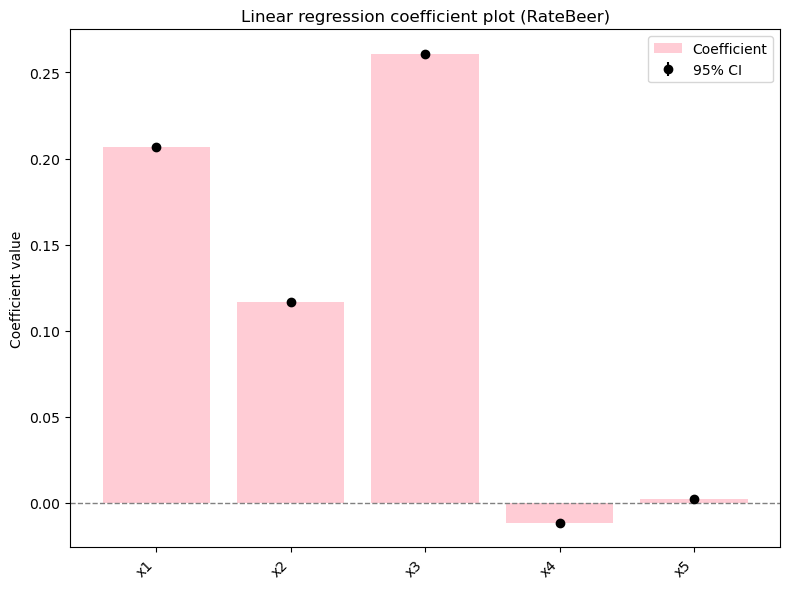

In [124]:
# extract coefficients and their confidence intervals from the model
coefficients_rb = model_rb.params
conf_int_rb = model_rb.conf_int()

# plot coefficients
plot_coefficients(coefficients_rb, conf_int_rb, "Linear regression coefficient plot (RateBeer)", bar_color='pink')

As seen in the output of the linear regression performed on the BeerAdvocate data, R2 is small, p-values of all coefficients are extremely low, coefficients corresponding to user experience levels are much smaller than the other coefficients. We again observe that the coefficient correponding to the expert experience level (x4) is negative and that the coefficient correponding to the new reviewer experience level (x5) is positive.

In this way, the linear regression analysis on both datasets a suggests that user experience levels significantly influence the final rating, as indicated by their small p-values. However, their effect size is smaller compared to factors like beer style, brewery reputation, and user generosity. The results imply that new reviewers are more generous, while expert reviewers are more critical, leading to lower ratings, but the overall influence of experience level on the final rating appears to be relatively subtle.

**Paired analysis**

In the second part of our analysis, we will conduct a paired study to examine how individual users’ ratings change as they gain experience. 

By comparing reviews from the same user, we can control for confounding factors related to user-specific characteristics. To further isolate the effect of experience on ratings, we will pair reviews with a "new reviewer" and an "expert" experience level within each user, matching them based on beer style and brewery reputation, which may be confounders. We will then perform a one-tailed paired t-test to determine if ratings given by a user when they are a new reviewer are higher than those they give when they are an expert, as suggested by the previous results.

We will start by pairing reviews with 'new_reviewer' and 'expert' experience levels for the same user, style, and brewery.

In [125]:
# filter for 'new_reviewer' and 'expert' reviews
newbie_reviews_ba = ba_ratings_with_experience_levels[ba_ratings_with_experience_levels['experience_level'] == 'new_reviewer']
expert_reviews_ba = ba_ratings_with_experience_levels[ba_ratings_with_experience_levels['experience_level'] == 'expert']

newbie_reviews_rb = rb_ratings_with_experience_levels[rb_ratings_with_experience_levels['experience_level'] == 'new_reviewer']
expert_reviews_rb = rb_ratings_with_experience_levels[rb_ratings_with_experience_levels['experience_level'] == 'expert']

# merge new reviewer and expert reviews on user_id, style, and brewery_id
paired_reviews_ba = pd.merge(newbie_reviews_ba, expert_reviews_ba, on=['user_id', 'style', 'brewery_id'], suffixes=('_new', '_expert'))
paired_reviews_rb = pd.merge(newbie_reviews_rb, expert_reviews_rb, on=['user_id', 'style', 'brewery_id'], suffixes=('_new', '_expert'))

# remove unmatched pairs
paired_reviews_ba = paired_reviews_ba.dropna(subset=['rating_new', 'rating_expert'])
paired_reviews_rb = paired_reviews_rb.dropna(subset=['rating_new', 'rating_expert'])

We will now perform a one-tailed t-test to determine if ratings given by a user when they are a new reviewer are higher than those they give when they are an expert.

In [126]:
# one-tailed paired t-test on BeerAdvocate data
t_stat, p_value = ttest_rel(paired_reviews_ba['rating_new'], paired_reviews_ba['rating_expert'],alternative='greater')
print("Results of one-tailed paired t-test on BeerAdvocate data:")
print("t-statistic =", t_stat)
print("p-value =", p_value)

Results of one-tailed paired t-test on BeerAdvocate data:
t-statistic = 31.776258228704247
p-value = 2.3198452340221017e-216


In [127]:
# one-tailed paired t-test on RateBeer data
t_stat, p_value = ttest_rel(paired_reviews_rb['rating_new'], paired_reviews_rb['rating_expert'],alternative='greater')
print("Results of one-tailed paired t-test on RateBeer data:")
print("t-statistic =", t_stat)
print("p-value =", p_value)

Results of one-tailed paired t-test on RateBeer data:
t-statistic = 12.146781634921936
p-value = 3.680645533781585e-34


The one-tailed paired t-tests performed on both datasets yielded a positive test statistic and a very small p-value. This suggests that on average, the final rating given by a specific user to beers from the same brewery and with the same style is higher when the user is a new reviewer than when they have become an expert reviewer. These findings align with the results of the linear regression, which suggested that new reviewers are more generous, while expert reviewers are more critical.

The t-tests performed above evaluated the statistical significance of the mean difference in ratings between matched reviews. In order to get a better idea of the magnitude and distribution of the difference in ratings between matched reviews, we will plot a boxplot.

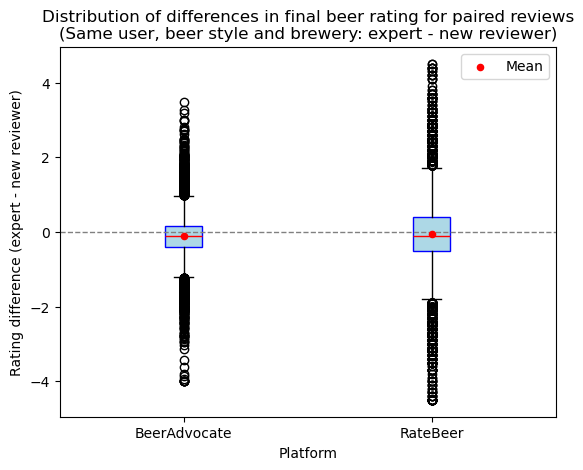

In [128]:
# calculate the difference in final rating within each pair of reviews
differences_ba = paired_reviews_ba['rating_expert'] - paired_reviews_ba['rating_new']
differences_rb = paired_reviews_rb['rating_expert'] - paired_reviews_rb['rating_new']

# plot a boxplot to show the ditribution of the differences
data = [differences_ba, differences_rb]
labels = ['BeerAdvocate', 'RateBeer']
means = [differences_ba.mean(), differences_rb.mean()]

plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(facecolor="lightblue", color="blue"), medianprops=dict(color="red"))
plt.scatter([1, 2], means, color='red', marker='o', s=20, zorder=3, label='Mean')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title('Distribution of differences in final beer rating for paired reviews\n(Same user, beer style and brewery: expert - new reviewer)') 
plt.ylabel('Rating difference (expert - new reviewer)')
plt.xlabel('Platform')
plt.legend()
plt.show()
plt.close()

In [129]:
# explicitely calculate the mean differences
mean_diff_ba = differences_ba.mean()
mean_diff_rb = differences_rb.mean()
print("Mean Difference (BeerAdvocate):", mean_diff_ba)
print("Mean Difference (RateBeer)" ,mean_diff_rb)

Mean Difference (BeerAdvocate): -0.12189246314052994
Mean Difference (RateBeer) -0.06419153896128713


We observe that for both datasets, the mean difference is negative but very small and close to zero. In addition, there are many paired reviews where the expert review is associated with a much smallerfinal rating than the paired new reviewer review, as shown by the numerous data points with a large negative value for the difference. However, there are also some cases where the expert review has a much larger rating, leading to high positive values.

The t-tests performed previously detected a statistically significant difference, showing that new reviewers tend to give slightly higher ratings than expert reviewers on average. This significance is likely due to the large sample size, which can make even small and differences statistically significant.

The boxplots showed that the mean difference is close to zero in practical terms, with many extreme positive and negative differences balancing each other out. They revelade the high variability and the presence of outliers in rating differences, which are aspects that were not captured by the t-tests.

These results illustrate the difference between statistical and practical significance: while the t-tests demonstrate a statistically significant difference, the actual effect size (difference in final ratings between matched reviews) is small and not practically meaningful. New reviewers appear to be slightly more generous than experts on average, but the difference is minimal and likely negligible in practical terms.

**Conclusion**

Both the linear regression and the paired analysis concluded that the user’s experience level has a measurable effect on their ratings, with more experienced users tending to be slightly more critical. They both showed that while the difference in ratings across different experience levels is real and significant from a statistical perspective, it is numerically small. The small impact of experience level on ratings was shown by the relatively small coefficients of experience levels in the linear regression, and by the very small mean difference revealed by the paired analysis.

Thus, while user experience level has a detectable influence on ratings, it is not the dominant factor driving rating behavior. Other factors, such as beer style, brewery reputation, and user generosity, play a much larger role.